<a href="https://colab.research.google.com/github/zakonreal/etc./blob/main/project_bank_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Банки — cегментация пользователей по потреблению продуктов

**Заказчик**
ПАО «Метанпром»



**Цель исследования**  
Анализ и сегментация клиентов регионального банка по количеству потребляемых продуктов:

- провединие исследовательского анализа данных,
- сегментация пользователей на основе данных о количестве потребляемых продуктов,
- формулировка и проверка статистических гипотез.
    
    *- гипотеза различия дохода между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним;*    
    *- гипотеза о различии в скоринговых баллах действующих и ушедших клиентов банка.*
    
По результатам исследования необходимо подготовить:
- презентацию,
- дашборд (диаграмму, отражающая количество клиентов в зависимости от числа используемых продуктов)



**Входные данные**    
Датасет содержит данные о клиентах банка, файл `banc_dataset.csv`.  

Колонки:     
- `userid` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `City` — город,
- `Gender` — пол,
- `Age` — возраст,
- `Objects` — количество объектов в собственности,
- `Balance` — баланс на счёте,
- `Products` — количество продуктов, которыми пользуется клиент,
- `CreditCard` — есть ли кредитная карта,
- `Loyalty` — активный клиент,
- `estimated_salary` — заработная плата клиента,
- `Churn` — ушёл или нет.


**Ход исследования**
1. *Обзор и предобработка данных.*     

О качестве данных ничего не известно. Поэтому перед работой с данными и проверкой гипотез понадобится обзор и предобработка данных.

После знакомства с данными мы проверим их на наличие ошибок (например, дубликатов), несоответствие типов данных, приведем наименование колонок к единому стилю, оценим влияние пропусков на исследование.      
Затем поищем возможность исправить самое критичное.

2. *EDA*    

На данном этапе мы  исследуем и анализируем распределения признаков и их влияние на отток клиентов. Построим столбчатые диаграммы для категориальных признаков и гистограммы распределения для числовых признаков, а так же диаграммы размаха, чтобы обратить внимание на наличие выбросов.

Далее построим матрицу корреляции, чтобы выявить признаки мультиколлениарности.

Проведем сегментацию клиентов по количеству продуктов: исследуем взаимосвязь количества продуктов на распределение признаков. Построим столбчатые диаграммы для категориальных признаков и гистограммы распределения для числовых признаков, а так же диаграммы размаха.

Сделаем и опишем промежуточные выводы.

3. *Проверка гипотез*  

Проверяем  2 гипотезы, включая проверку распределений на нормальность, формулирование нулевой и альтернативной гипотез.


4. *Кластеризация пользователей*    

Проведем класторизацию клиентов. Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму, после чего обучим модель кластеризации на основании алгоритма K-Means.
Описываем полученные портреты пользователей.

5. *Выводы и рекомендации*    

По результатам анализа выявляем признаки, наиболее влияющие на отток и даем рекомендации, в том числе, в разрезе портретов пользователей.

## Обзор и предобработка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings; warnings.filterwarnings(action = 'ignore')

from scipy import stats as st
from plotly import graph_objects as go
from IPython.display import set_matplotlib_formats
from pandas.plotting import register_matplotlib_converters
#from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#from sklearn.linear_model import LogisticRegression
#from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

register_matplotlib_converters()

In [2]:
# снимаем ограничение на количество столбцов
pd.set_option('display.max_columns', 50)

# снимаем ограничение на ширину столбцов
pd.set_option('display.max_colwidth', 120)

# игнорируем предупреждения
pd.set_option('chained_assignment', 'warn')
warnings.simplefilter(action='ignore', category=FutureWarning)

# выставляем ограничение на показ знаков после запятой
pd.options.display.float_format = '{:,.2f}'.format

# устанавливаем стиль графиков
sns.set(rc={'figure.dpi':200, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style('ticks')
sns.set_style('whitegrid')

In [3]:
# чтение файлов с данными и сохранение в df
data = pd.read_csv('bank_dataset.csv')

In [4]:
# знакомимся с датафреймом
data.info()
display(data.head(5))
print('Явных дубликатов:', data.duplicated().sum(), 'Доля дубликатов:', data.duplicated().sum() / len(data))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,"101,348.88",1
1,15690047,608,Рыбинск,Ж,41,1,"83,807.86",1,0,1,"112,542.58",0
2,15662040,502,Ярославль,Ж,42,8,"159,660.80",3,1,0,"113,931.57",1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,"93,826.63",0
4,15780624,850,Рыбинск,Ж,43,2,"125,510.82",1,1,1,"79,084.10",0


Явных дубликатов: 0 Доля дубликатов: 0.0


In [5]:
# приведем названия заголовков к нижнему регистру, изменим названия на более удобные:
data.columns = data.columns.str.lower()
data = data.rename(columns={'creditcard': 'credit_card', 'userid' : 'user_id'})

data.columns

Index(['user_id', 'score', 'city', 'gender', 'age', 'objects', 'balance',
       'products', 'credit_card', 'loyalty', 'estimated_salary', 'churn'],
      dtype='object')

In [6]:
data['city'].value_counts()

Ярославль         5014
Ростов Великий    2509
Рыбинск           2477
Name: city, dtype: int64

In [7]:
data['objects'].value_counts()

2     1048
1     1035
7     1028
8     1025
5     1012
3     1009
4      989
9      984
6      967
10     490
0      413
Name: objects, dtype: int64

In [8]:
data['products'].value_counts()

1    5084
2    4590
3     266
4      60
Name: products, dtype: int64

In [9]:
# выводим первые строки таблицы с клиентами, у которых не заполнено значение balance.
data_no_balances = data[data['balance'].isnull()]
data_no_balances.head(5)

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,"101,348.88",1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,"93,826.63",0
6,15635267,822,Ярославль,М,50,7,NaN,2,1,1,"10,062.80",0
11,15779909,497,Рыбинск,М,24,3,NaN,2,1,0,"76,390.01",0
12,15675000,476,Ярославль,Ж,34,10,NaN,2,1,0,"26,260.98",0


In [10]:
# выводим первые строки таблицы с клиентами, у которых заполнено значение balance.
data[data['balance'].notnull()].head(5)

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
1,15690047,608,Рыбинск,Ж,41,1,"83,807.86",1,0,1,"112,542.58",0
2,15662040,502,Ярославль,Ж,42,8,"159,660.80",3,1,0,"113,931.57",1
4,15780624,850,Рыбинск,Ж,43,2,"125,510.82",1,1,1,"79,084.10",0
5,15616748,645,Рыбинск,М,44,8,"113,755.78",2,1,0,"149,756.71",1
7,15698884,376,Ростов Великий,Ж,29,4,"115,046.74",4,1,0,"119,346.88",1


Попытаемся понять, почему нет данных про баланс на счете.

In [11]:
data_no_balances.describe()

,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
count,"3,617.00","3,617.00","3,617.00","3,617.00",0.00,"3,617.00","3,617.00","3,617.00","3,617.00","3,617.00"
mean,"15,734,685.59",649.45,38.43,5.07,NaN,1.78,0.72,0.52,"98,983.56",0.14
std,"71,947.49",96.16,10.49,2.86,NaN,0.50,0.45,0.50,"57,730.83",0.35
min,"15,608,442.00",350.00,18.00,0.00,NaN,1.00,0.00,0.00,90.07,0.00
25%,"15,672,255.00",583.00,31.00,3.00,NaN,1.00,0.00,0.00,"49,506.82",0.00
50%,"15,736,083.00",651.00,37.00,5.00,NaN,2.00,1.00,1.00,"98,618.79",0.00
75%,"15,796,286.00",717.00,43.00,7.00,NaN,2.00,1.00,1.00,"148,330.97",0.00
max,"15,858,100.00",850.00,88.00,10.00,NaN,4.00,1.00,1.00,"199,992.48",1.00


In [12]:
data_no_balances['city'].unique()

array(['Ярославль', 'Рыбинск'], dtype=object)

In [13]:
data_no_balances['products'].unique()

array([1, 2, 3, 4])

Нет никаких отличий по признакам между клиентами с балансом и клиентами, у которых баланс не заполнен, кроме того, что таких клиентов нет в Ростове Великом.    

Так же мы заметили, что в столбце заработная плата (estimated_salary) есть экстремально низкие значения. С учетом того, что банк работает на территории России, заработная плата может начисляться только в рублях. Посмотрим, сколько клиентов указало ЗП ниже минимального размера заработной платы (возьмем значение МРОТ на 2017г.).

In [14]:
data.query('estimated_salary < 7800').describe()

,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
count,387.00,387.00,387.00,387.00,225.00,387.00,387.00,387.00,387.00,387.00
mean,"15,728,870.12",647.66,38.65,4.78,"117,904.15",1.54,0.66,0.52,"3,711.40",0.20
std,"73,424.88",98.74,10.58,2.86,"28,012.99",0.57,0.47,0.50,"2,201.41",0.40
min,"15,608,947.00",413.00,18.00,0.00,"27,517.15",1.00,0.00,0.00,11.58,0.00
25%,"15,664,537.50",583.00,31.00,2.00,"99,340.83",1.00,0.00,0.00,"1,789.16",0.00
50%,"15,727,284.00",647.00,37.00,5.00,"117,833.30",2.00,1.00,1.00,"3,701.63",0.00
75%,"15,790,495.50",712.00,44.00,7.00,"134,168.50",2.00,1.00,1.00,"5,616.78",0.00
max,"15,856,396.00",850.00,77.00,10.00,"204,510.94",4.00,1.00,1.00,"7,797.01",1.00


Думаем, что достаточно будет убрать выбросы снизу по 2 процентилю, т.к. мы не знаем, на какую дату подготовлены данные и какой МРОТ был на тот момент.

In [15]:
print('Количество строк до удаления выбросов:', len(data))

data = data[data['estimated_salary'] >= np.percentile(data['estimated_salary'], 2)]

print('Количество строк после удаления выбросов:', len(data))

Количество строк до удаления выбросов: 10000
Количество строк после удаления выбросов: 9800


**Выводы**

Окончательная таблица содержит информацию о 9800 тысячах клиентах банка.     
Банк представлен в городах Ярославль, Ростов Великий и Рыбинск. Клиенты банка могут использовать от одного до четырех продуктов. Клиентские данные обезличены.  

По набору полей (скоринг, ЗП, наличие недвижимости в собственности) можно предположить, что речь идет о кредитных продуктах банка (ипотека, потребительский кредит, автокредит, покупка товаров в рассрочку и т.д.). Исходя их этого, сделаем  предположение, что столбец Баланс на счете (`balance`) означает сумму задолженности клиента перед банком.

В таблице нет явных дубликатов, но есть пропуски в столбце `balance` у клиентов из Ярославля и Рыбинска. Пока сложно сказать, чем они вызваны - можем предположить, что это связано с локальными особенностями одного из продуктов, поэтому самостоятельно заполнять пропуски не будем.

## Исследовательский анализ данных (EDA)

In [16]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,"9,800.00","15,733,939.46","71,928.88","15,608,437.00","15,671,446.50","15,734,157.00","15,796,285.25","15,858,426.00"
score,"9,800.00",650.42,96.59,350.00,584.00,652.00,717.00,850.00
age,"9,800.00",38.93,10.49,18.00,32.00,37.00,44.00,92.00
objects,"9,800.00",5.02,2.89,0.00,3.00,5.00,7.00,10.00
balance,"6,269.00","119,865.91","30,085.32","3,768.69","100,249.41","119,919.12","139,532.34","250,898.09"
products,"9,800.00",1.53,0.58,1.00,1.00,1.00,2.00,4.00
credit_card,"9,800.00",0.71,0.46,0.00,0.00,1.00,1.00,1.00
loyalty,"9,800.00",0.52,0.50,0.00,0.00,1.00,1.00,1.00
estimated_salary,"9,800.00","102,094.43","56,338.96","3,769.71","54,128.12","101,970.47","150,103.84","199,992.48"
churn,"9,800.00",0.20,0.40,0.00,0.00,0.00,0.00,1.00


Итак, что мы можем сказать предварительно:       
1. возраст клиентов колеблется от 18 до 92 лет;
2. клиент может как не иметь недвижимость в собственности вовсе, так и владеть 10 объектами;   
3. все клиенты пользуются продуктами банка (минимум одним, максимум - четырьмя);   
4. 71% клиентов пользуется кредитной картой банка;   
5. почти половина клиентов не является активными пользователями продуктов;    
6. отток - 20%.  

### Влияние признаков на отток

Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток (1)  и тех, кто остался (0).

In [17]:
data.groupby('churn').agg('mean').T

churn,0,1
user_id,"15,734,173.82","15,733,027.74"
score,651.76,645.21
age,37.41,44.83
objects,5.04,4.92
balance,"119,623.49","120,627.93"
products,1.54,1.48
credit_card,0.71,0.70
loyalty,0.56,0.36
estimated_salary,"101,833.57","103,109.25"


1. у тех, кто остался, скоринговый бал выше (но не сильно);   
2. средний возраст клиентов, попавших в отток, - 45 лет, у оставшихся - 37 лет;
3. активность оставшихся клиентов  была выше;
4. наличие кредитной карты, количество объектов недвижимости в собственности, остаток средств на балансе  и ЗП на отток существенного влияния не оказывают (в обеих группах показатели практически одинаковы).

#### Гистограммы и распределения признаков

При помощи функций построим столбчатые диаграммы для категориальных признаков и гистограммы распределения для числовых признаков, а так же диаграммы размаха.

In [18]:
# функция по отрисовке гистограммы распределения и диаграммы размаха для числовых признаков;
# на входе функции передем параметры: датафрейм, название столбца, по которому строим график, название графика;

def numeric_plots(df, col, title):
    fig, ax = plt.subplots(figsize = (15, 5))

    sns.histplot(df[df['churn']==0][col], color = '#EFC87B', ax = plt.subplot(1, 2, 1))
    sns.histplot(df[df['churn']==1][col], label = 'отток', color = '#184562', ax = plt.subplot(1, 2, 1), alpha=.4)
    plt.xlabel('')
    plt.ylabel('количество пользователей')
    plt.legend()

    sns.boxplot(y = col, x = 'churn', data = df, ax = plt.subplot(1, 2, 2), palette='Pastel2_r')
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(np.arange(2), ('Действующие клиенты', 'Отток'))

    fig.suptitle(title + ' (' + col + ')')
    plt.show()

In [19]:
# функция по отрисовке столбчатых диаграмм и диаграммы размаха для категориальных признаков;
# на входе функции передем параметры: датафрейм, название столбца, по которому строим график, название графика;

def categorical_plots(df, col, title):
    fig, ax = plt.subplots(figsize = (15, 5))

    sns.countplot(x = col, hue = 'churn', data = df, ax = plt.subplot(1, 2, 1),  palette='Pastel2')
    plt.ylabel('количество пользователей')
    plt.xlabel('')
    plt.legend()

    gr = df.groupby([col, 'churn']).agg(count=('age', 'count')).reset_index()
    sns.boxplot(x = col, y = 'count', data = gr, ax = plt.subplot(1, 2, 2), palette='Pastel2_r')
    plt.xlabel('')
    plt.ylabel('')


    fig.suptitle(title + ' (' + col + ')')
    plt.show()

In [20]:
# соберём для удобства в DataFrame название колонок и названия графиков:

numeric = pd.DataFrame({'col' : ['score', 'age', 'objects', 'balance', 'products', 'estimated_salary'],
                        'title' : ['Баллы кредитного скорринга', 'Возраст',
                                   'Количество объектов недвижимости в собственности',
                                   'Баланс', 'Количество продуктов банка',
                                   'Заработная плата клиента']
                       })

categorical = pd.DataFrame({'col' : ['gender', 'city', 'credit_card', 'loyalty'],
                            'title' : ['Пол', 'Город', 'Наличие кредитной карты', 'Активность']
                            })


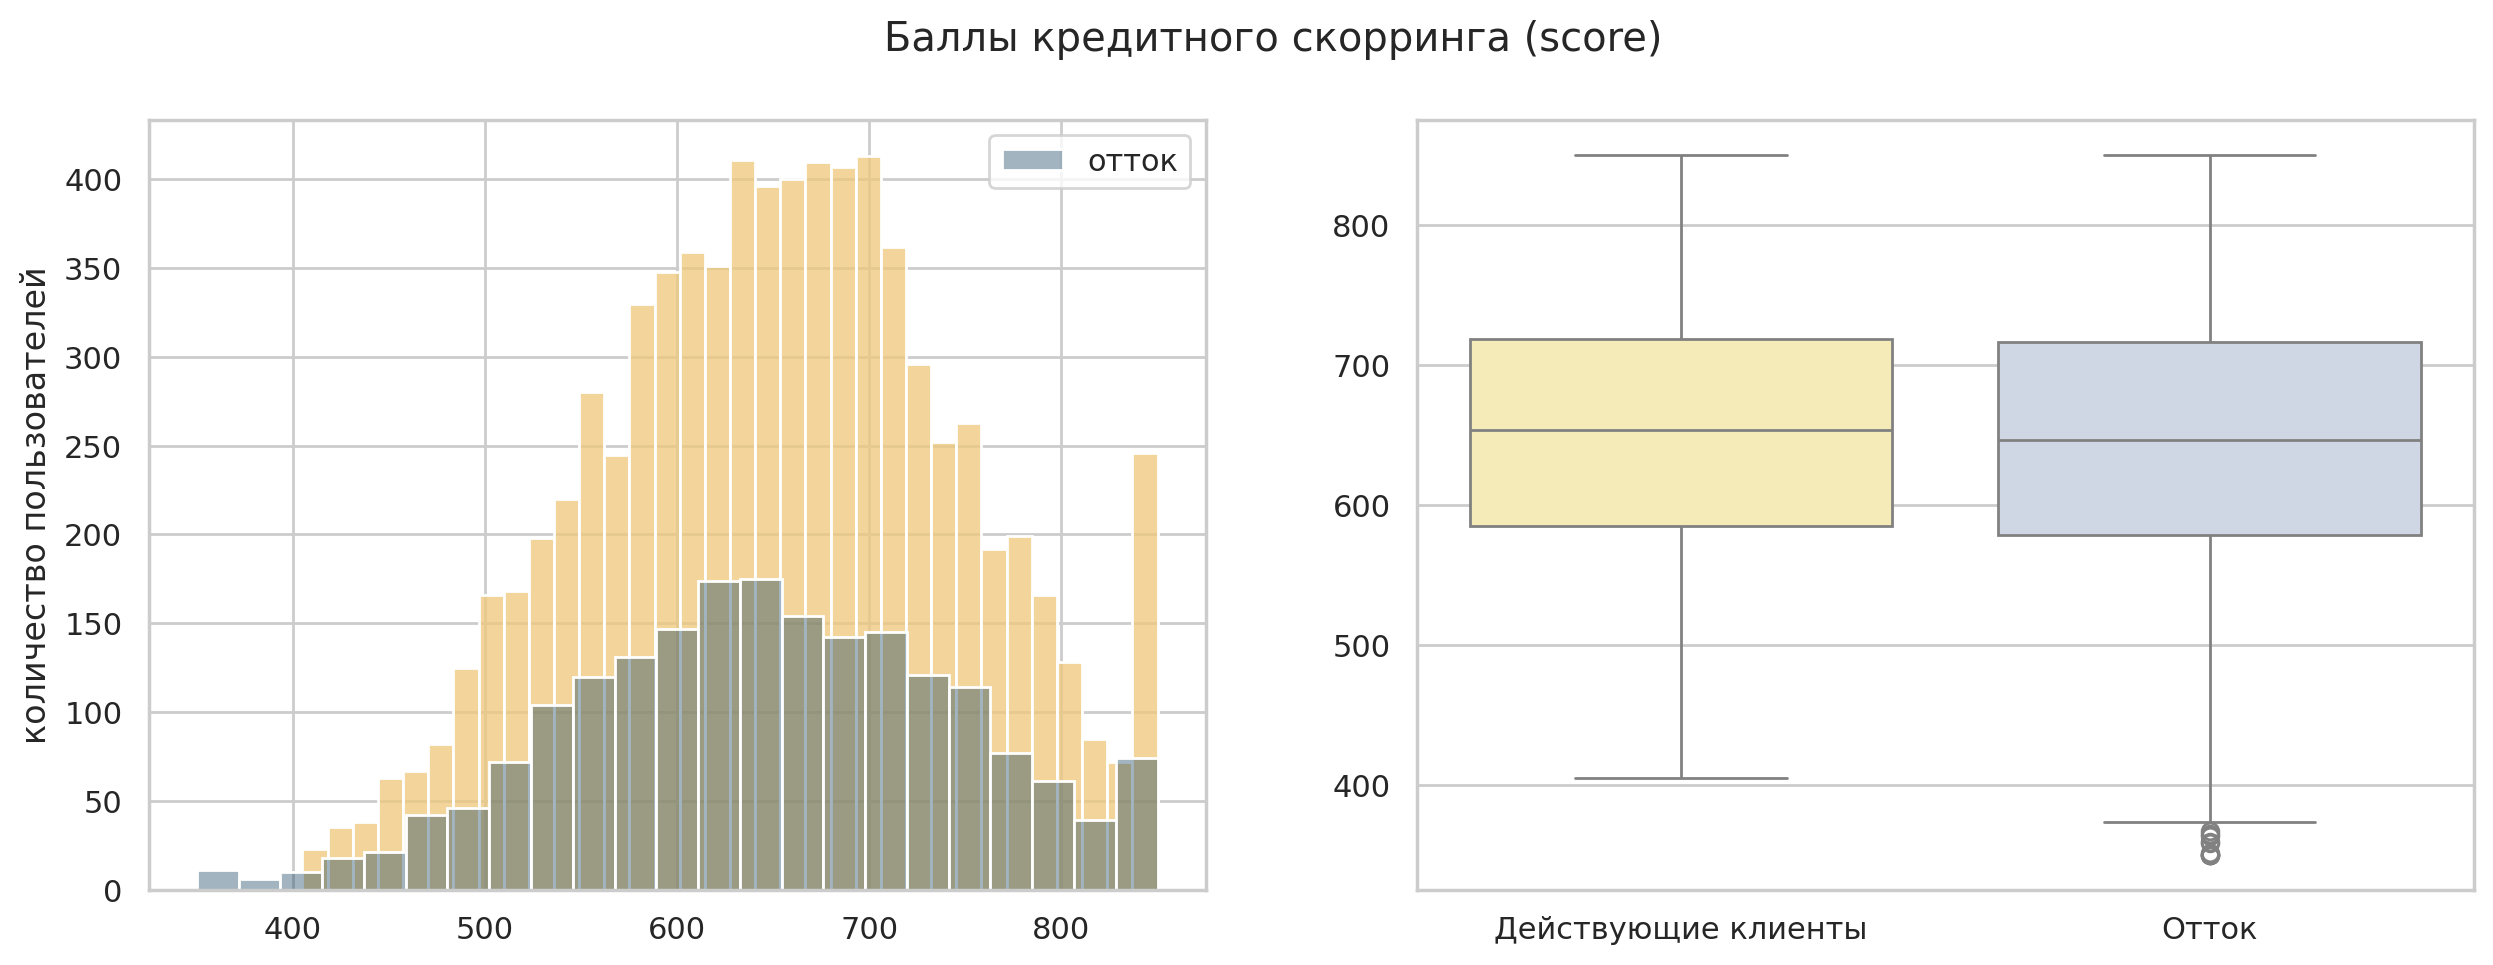

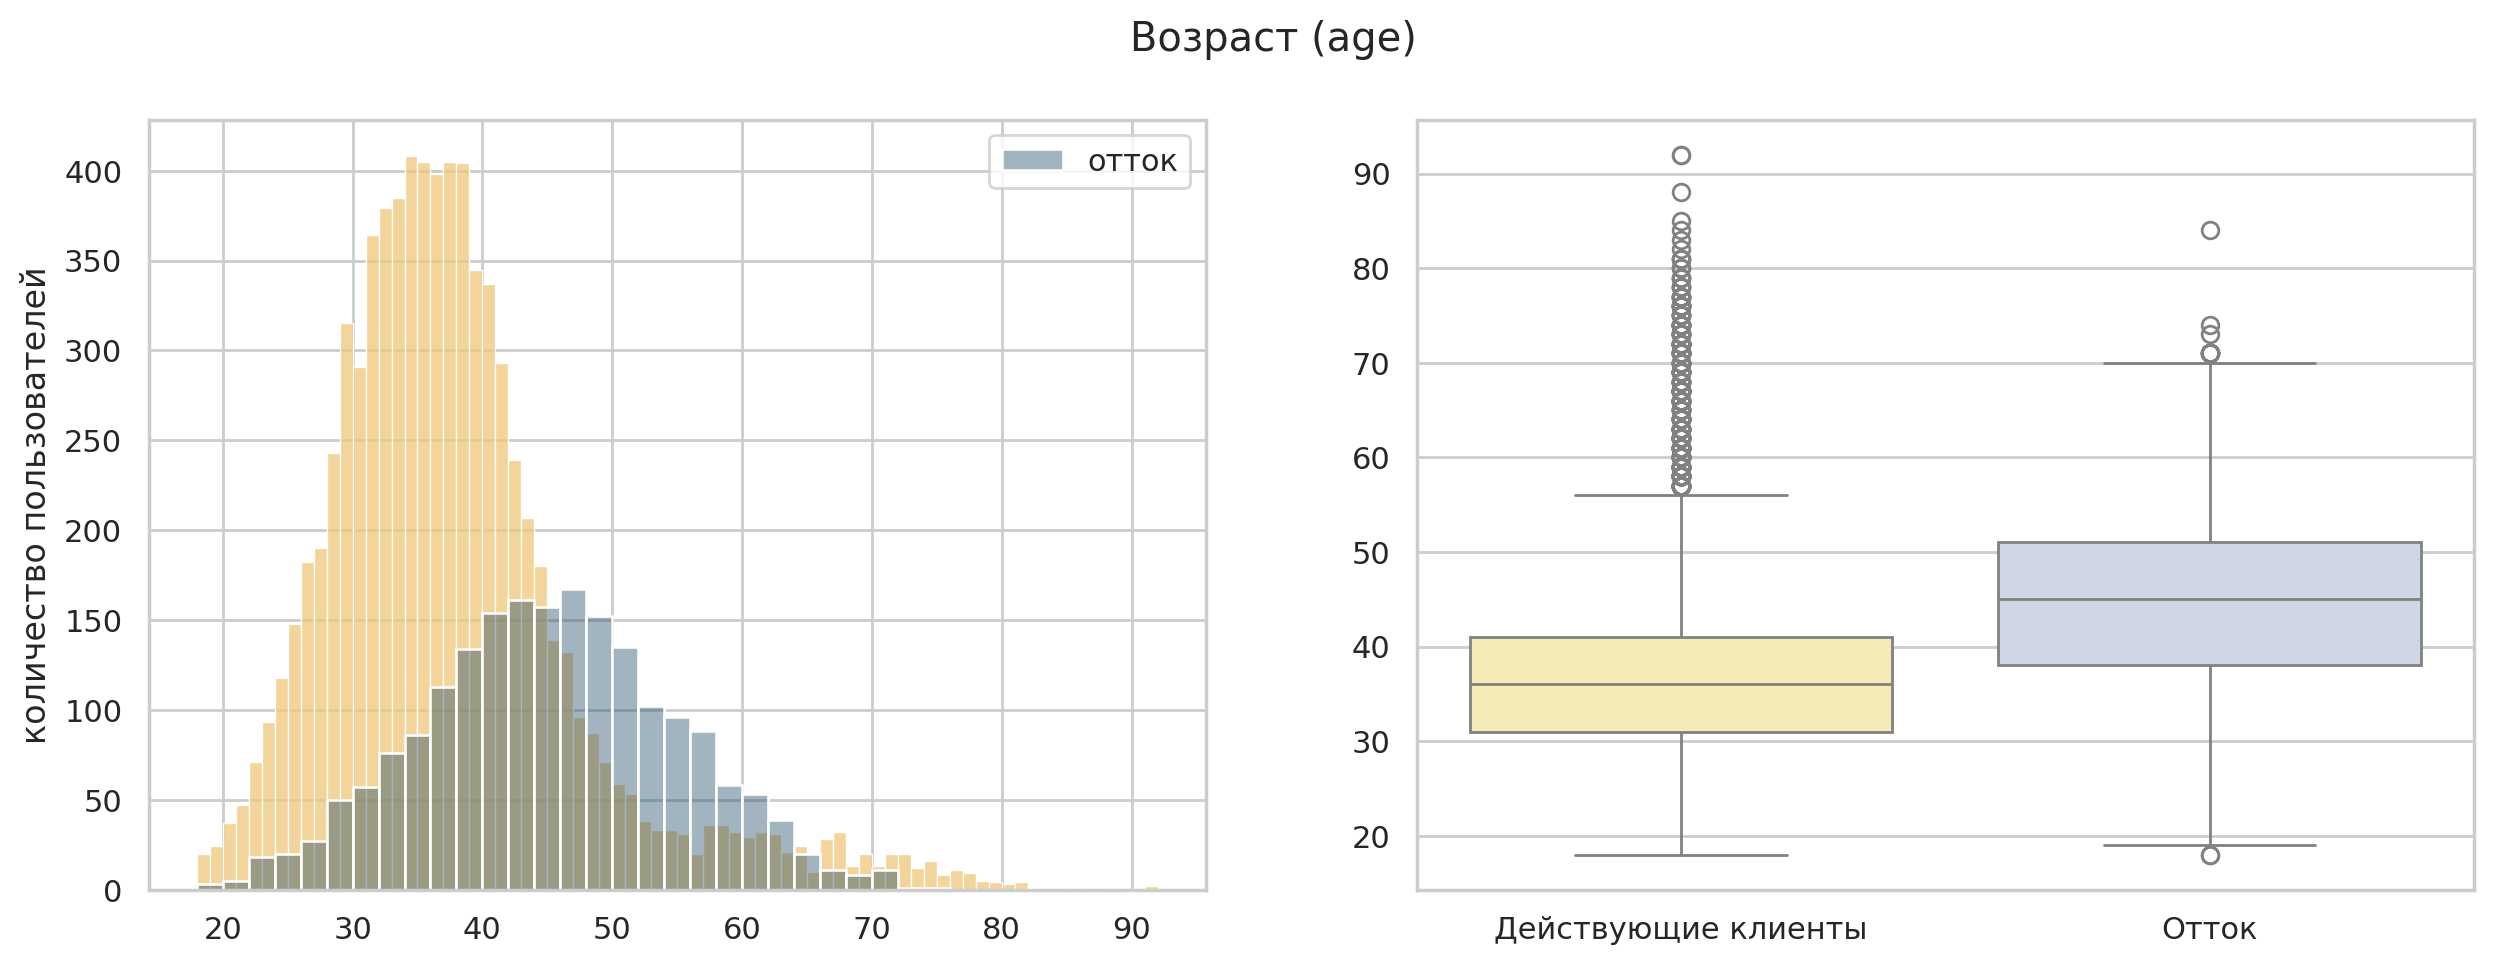

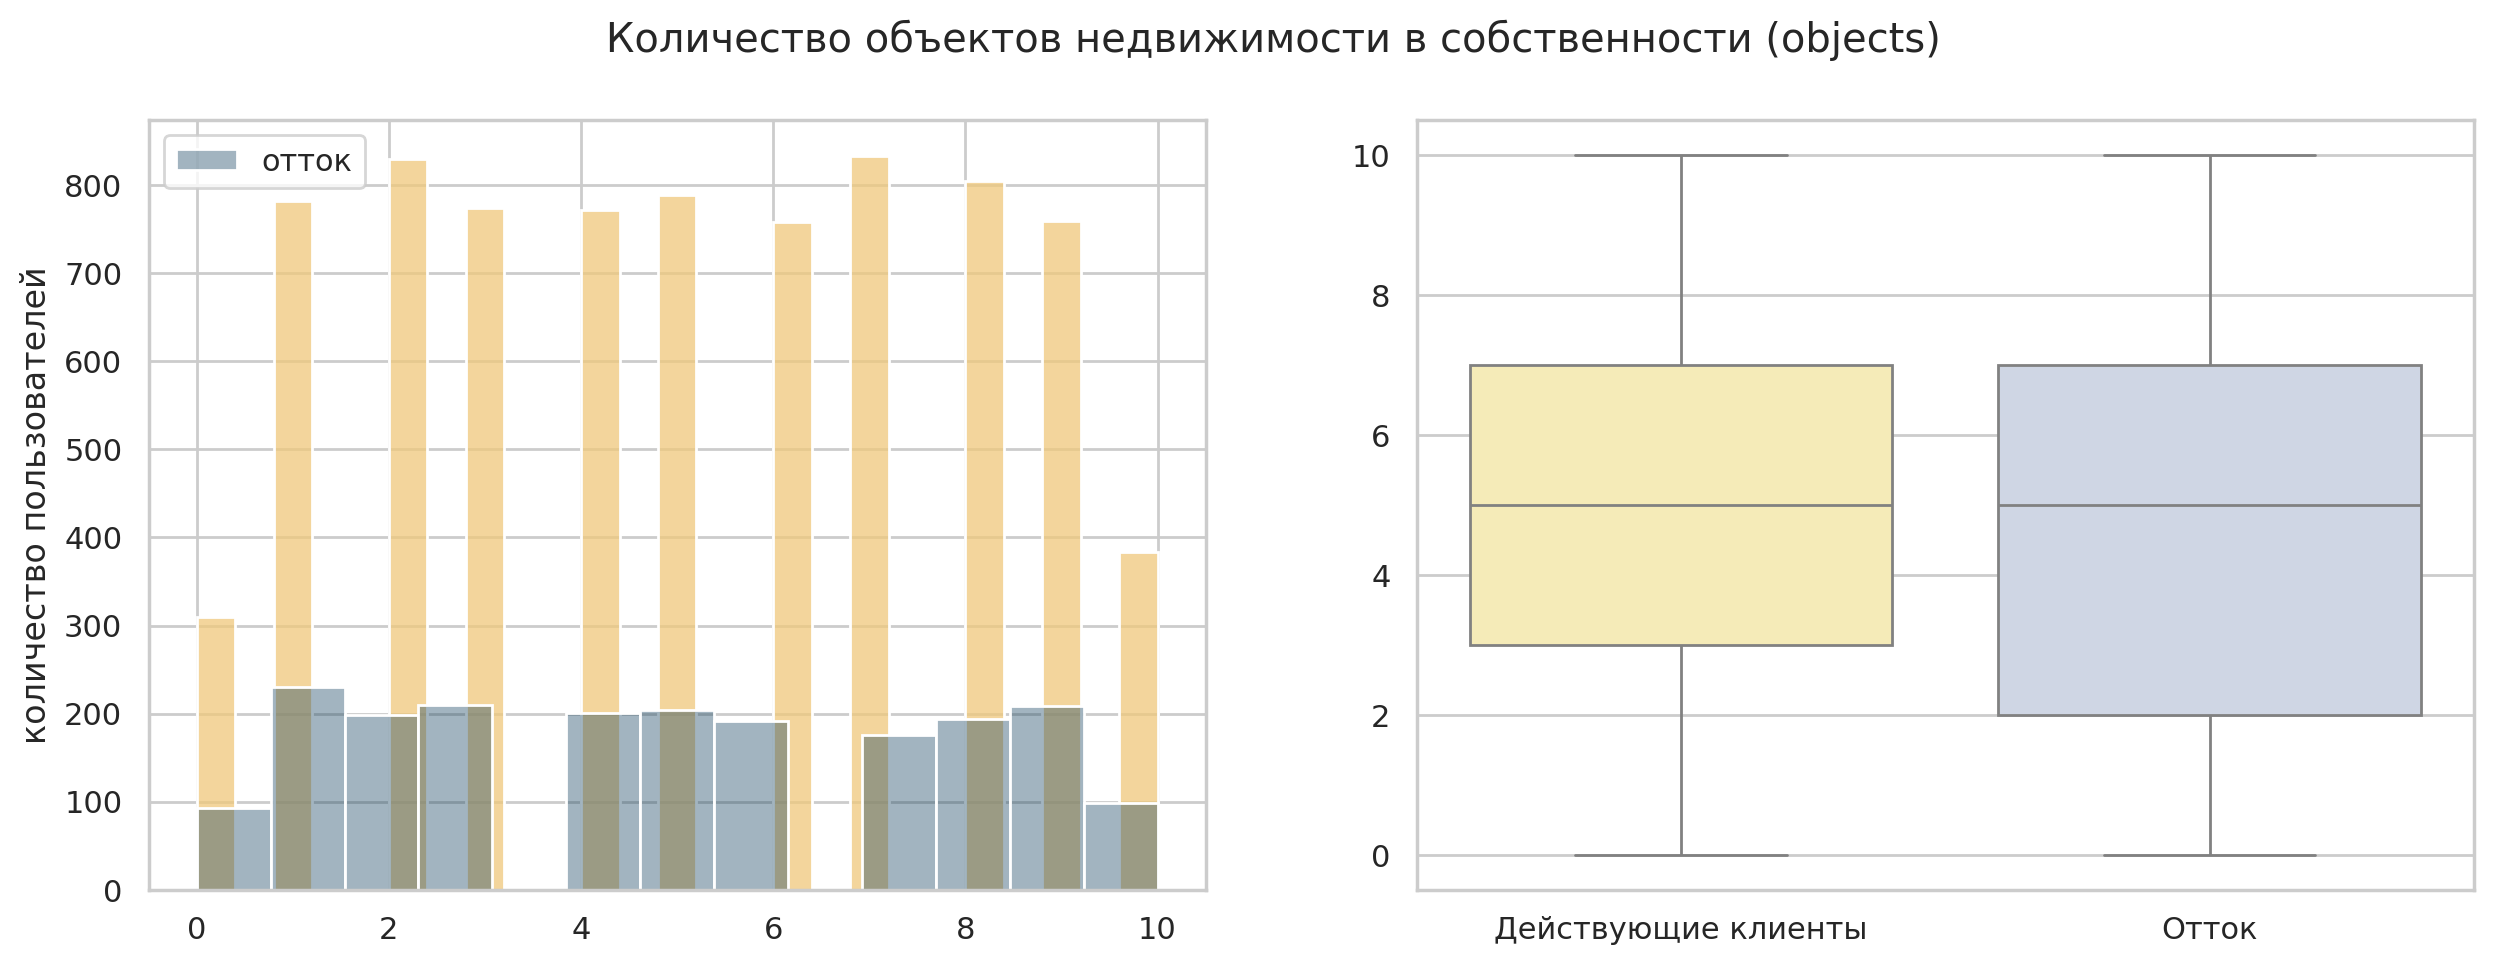

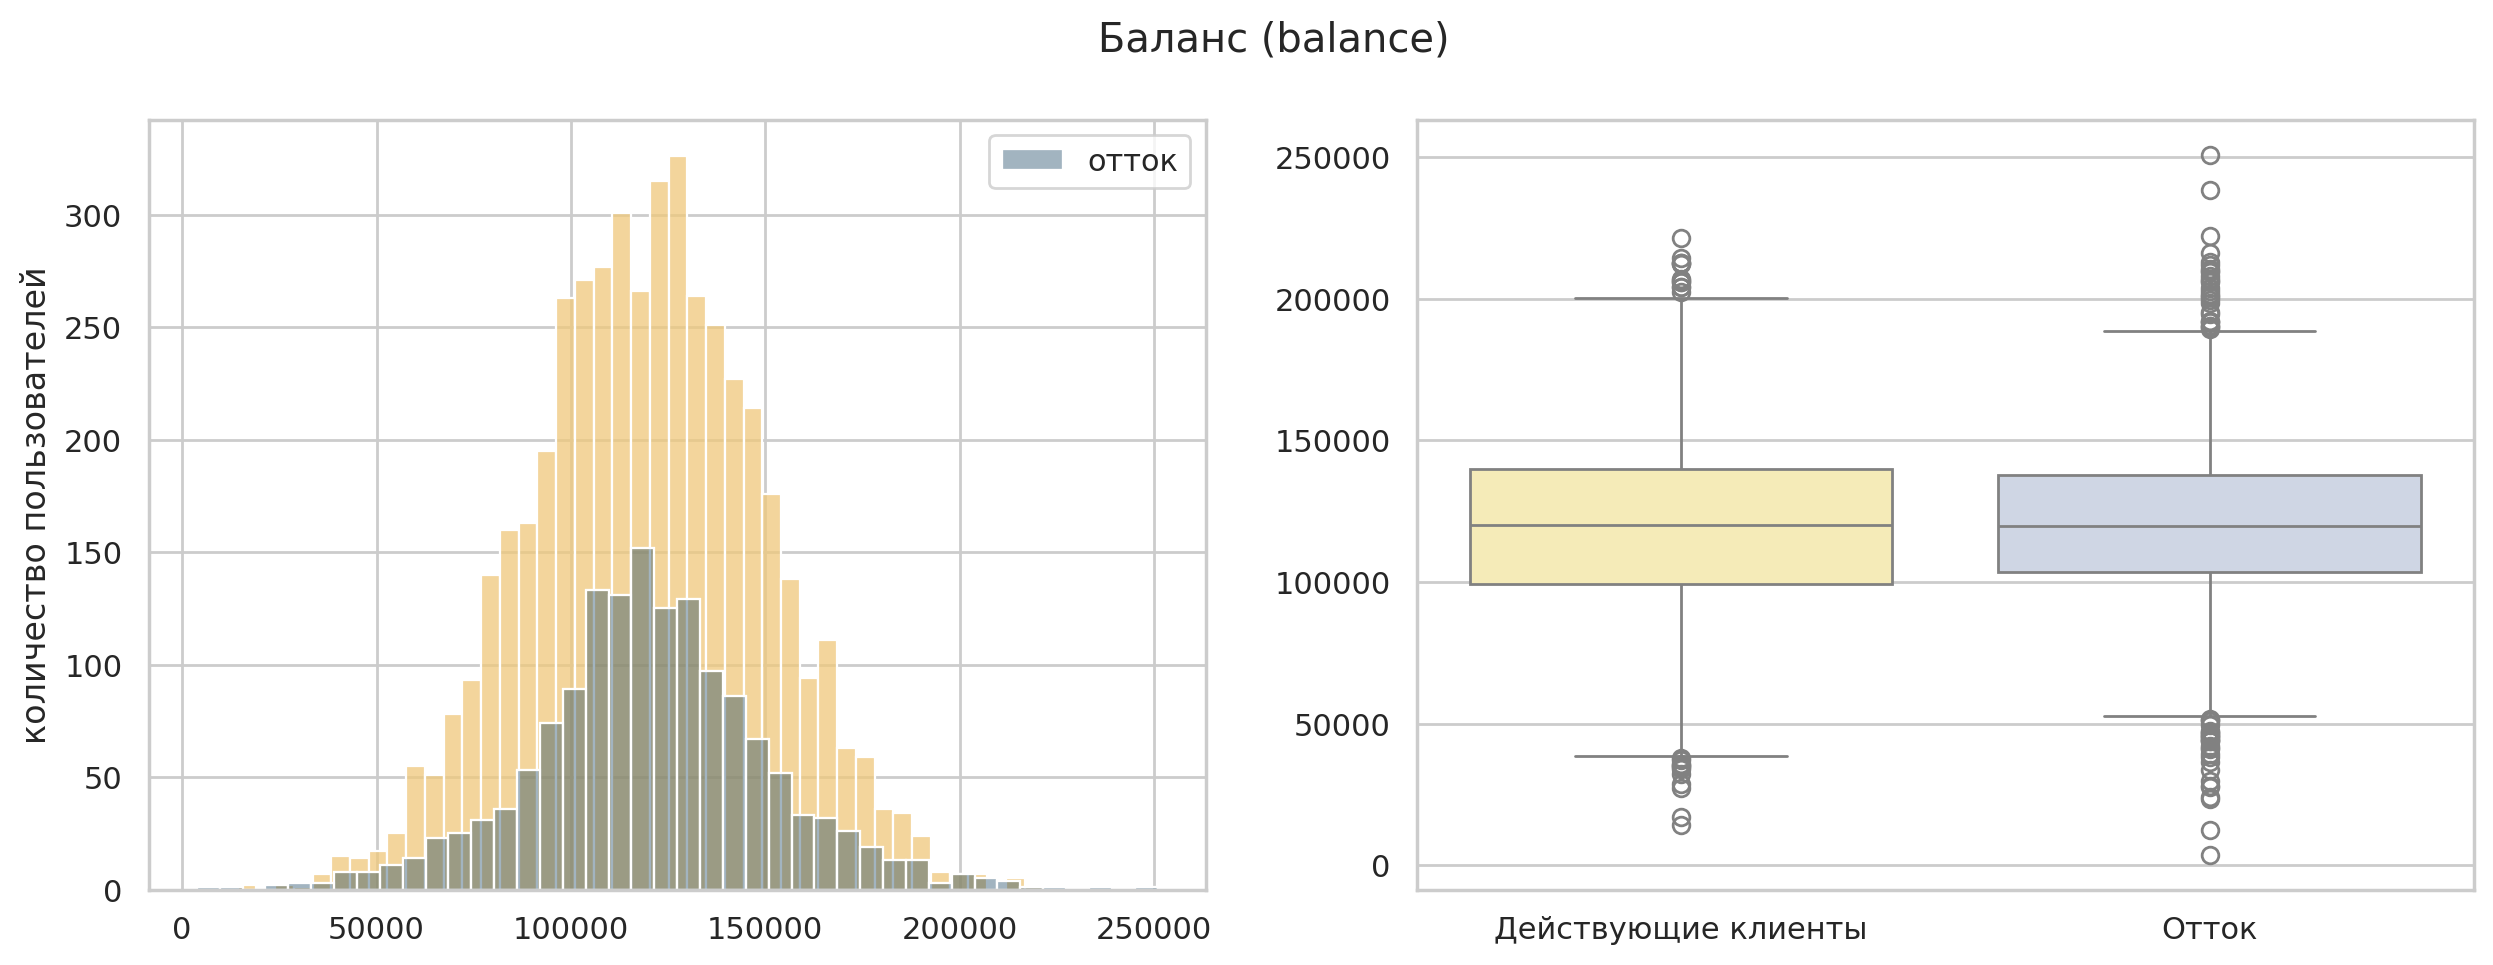

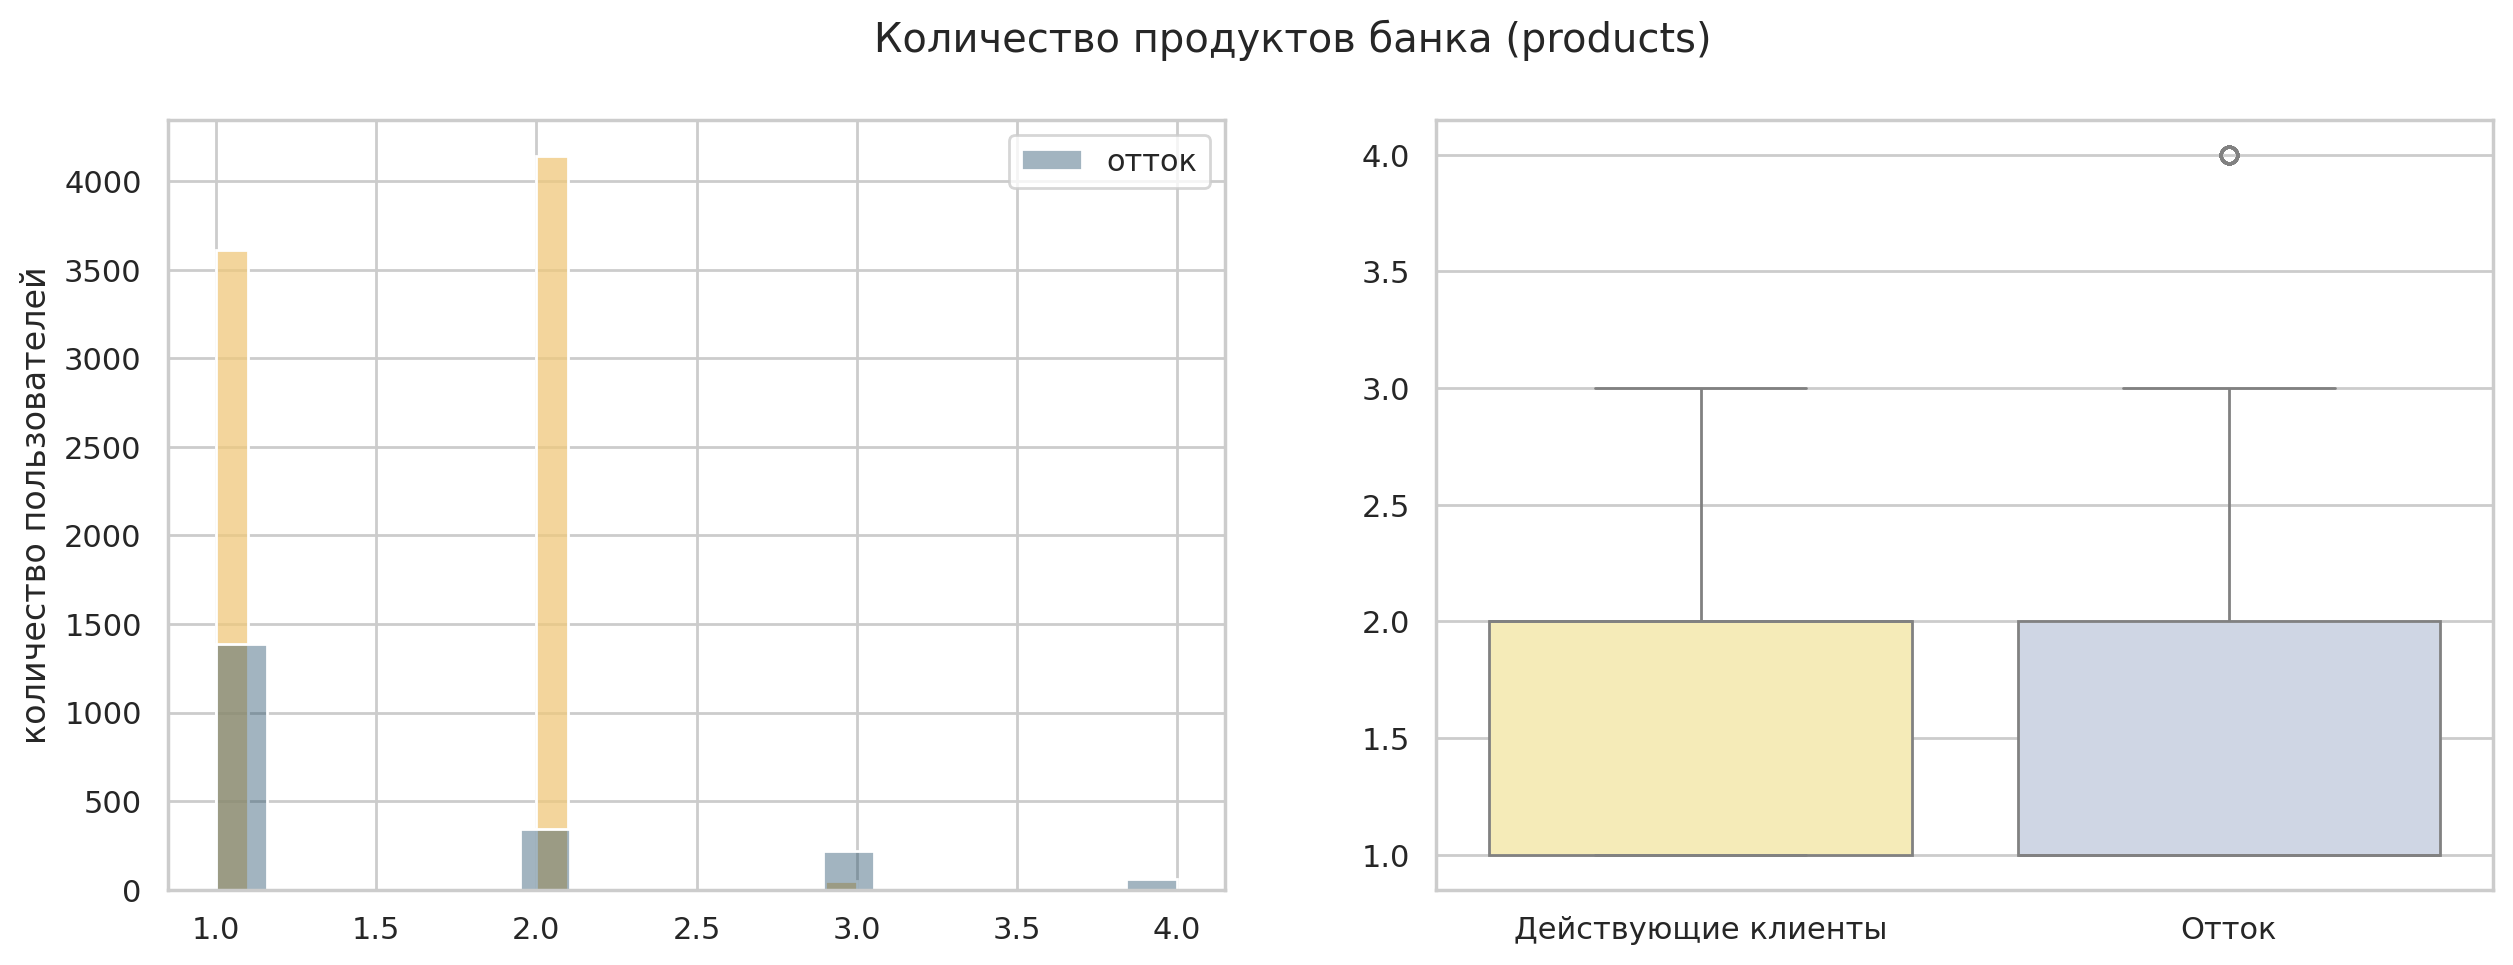

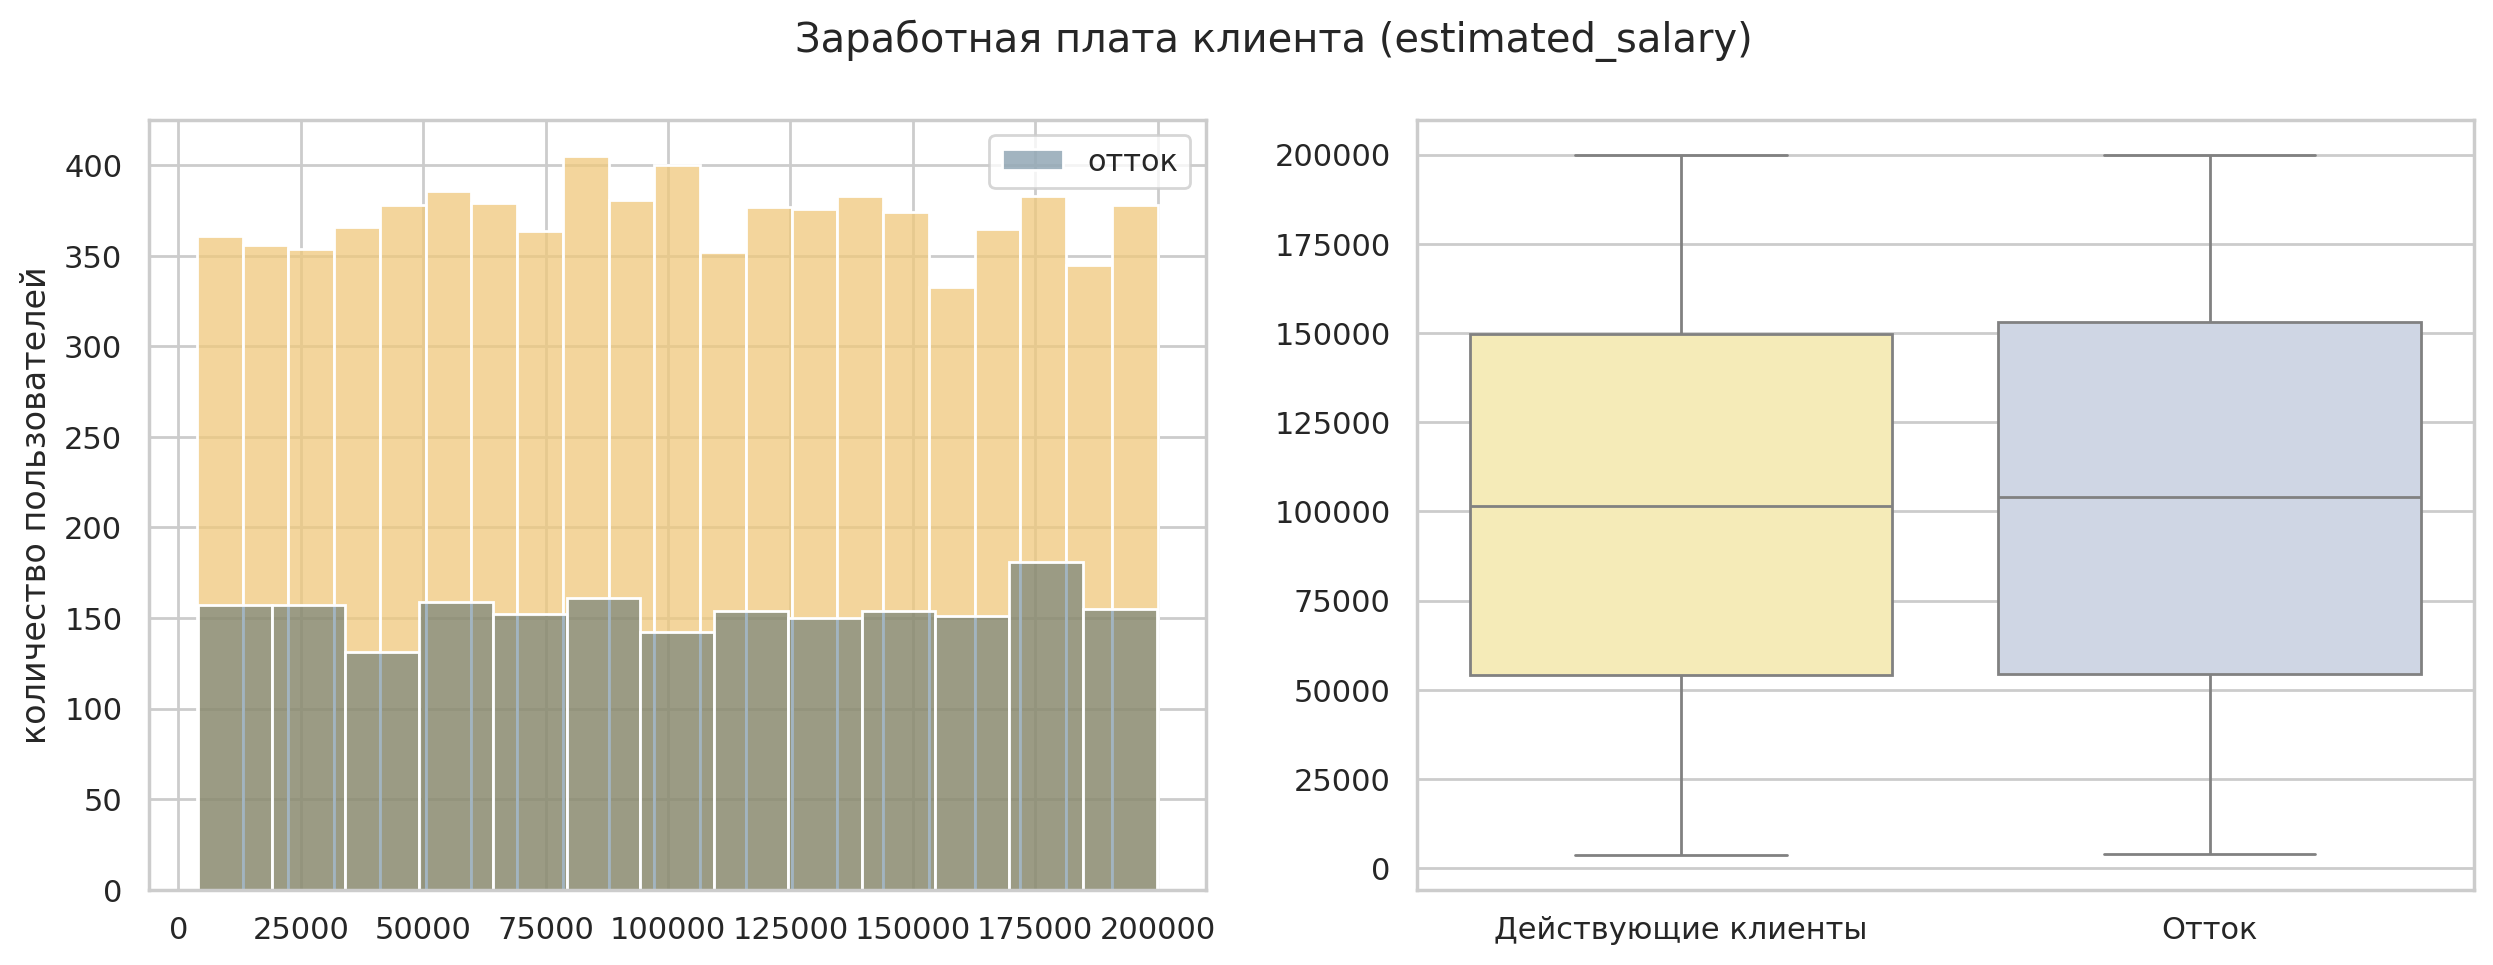

In [21]:
for index, row in numeric.iterrows():
    numeric_plots(data, row[0], row[1])

То же самое проделаем с категориальными данными.

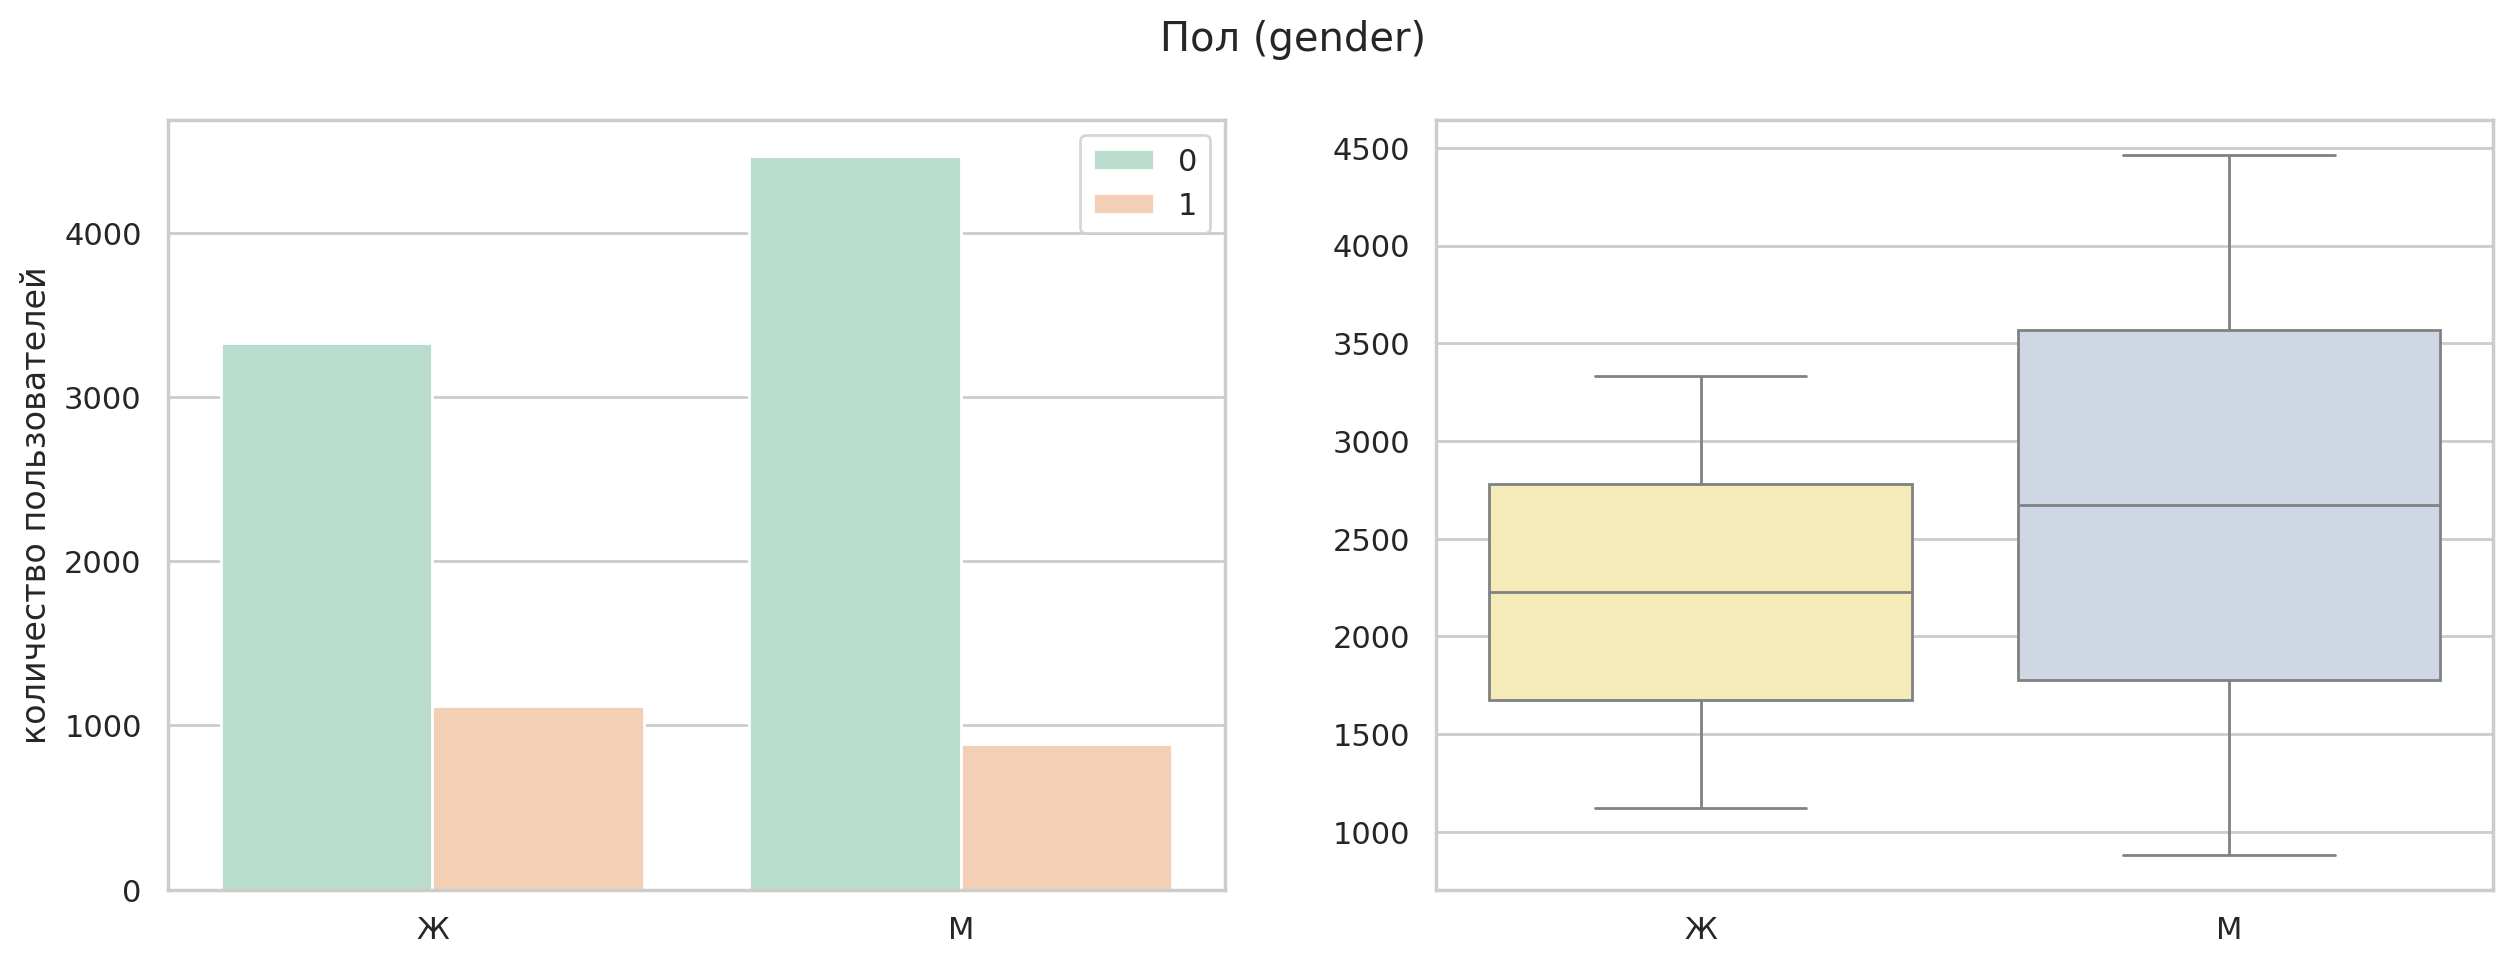

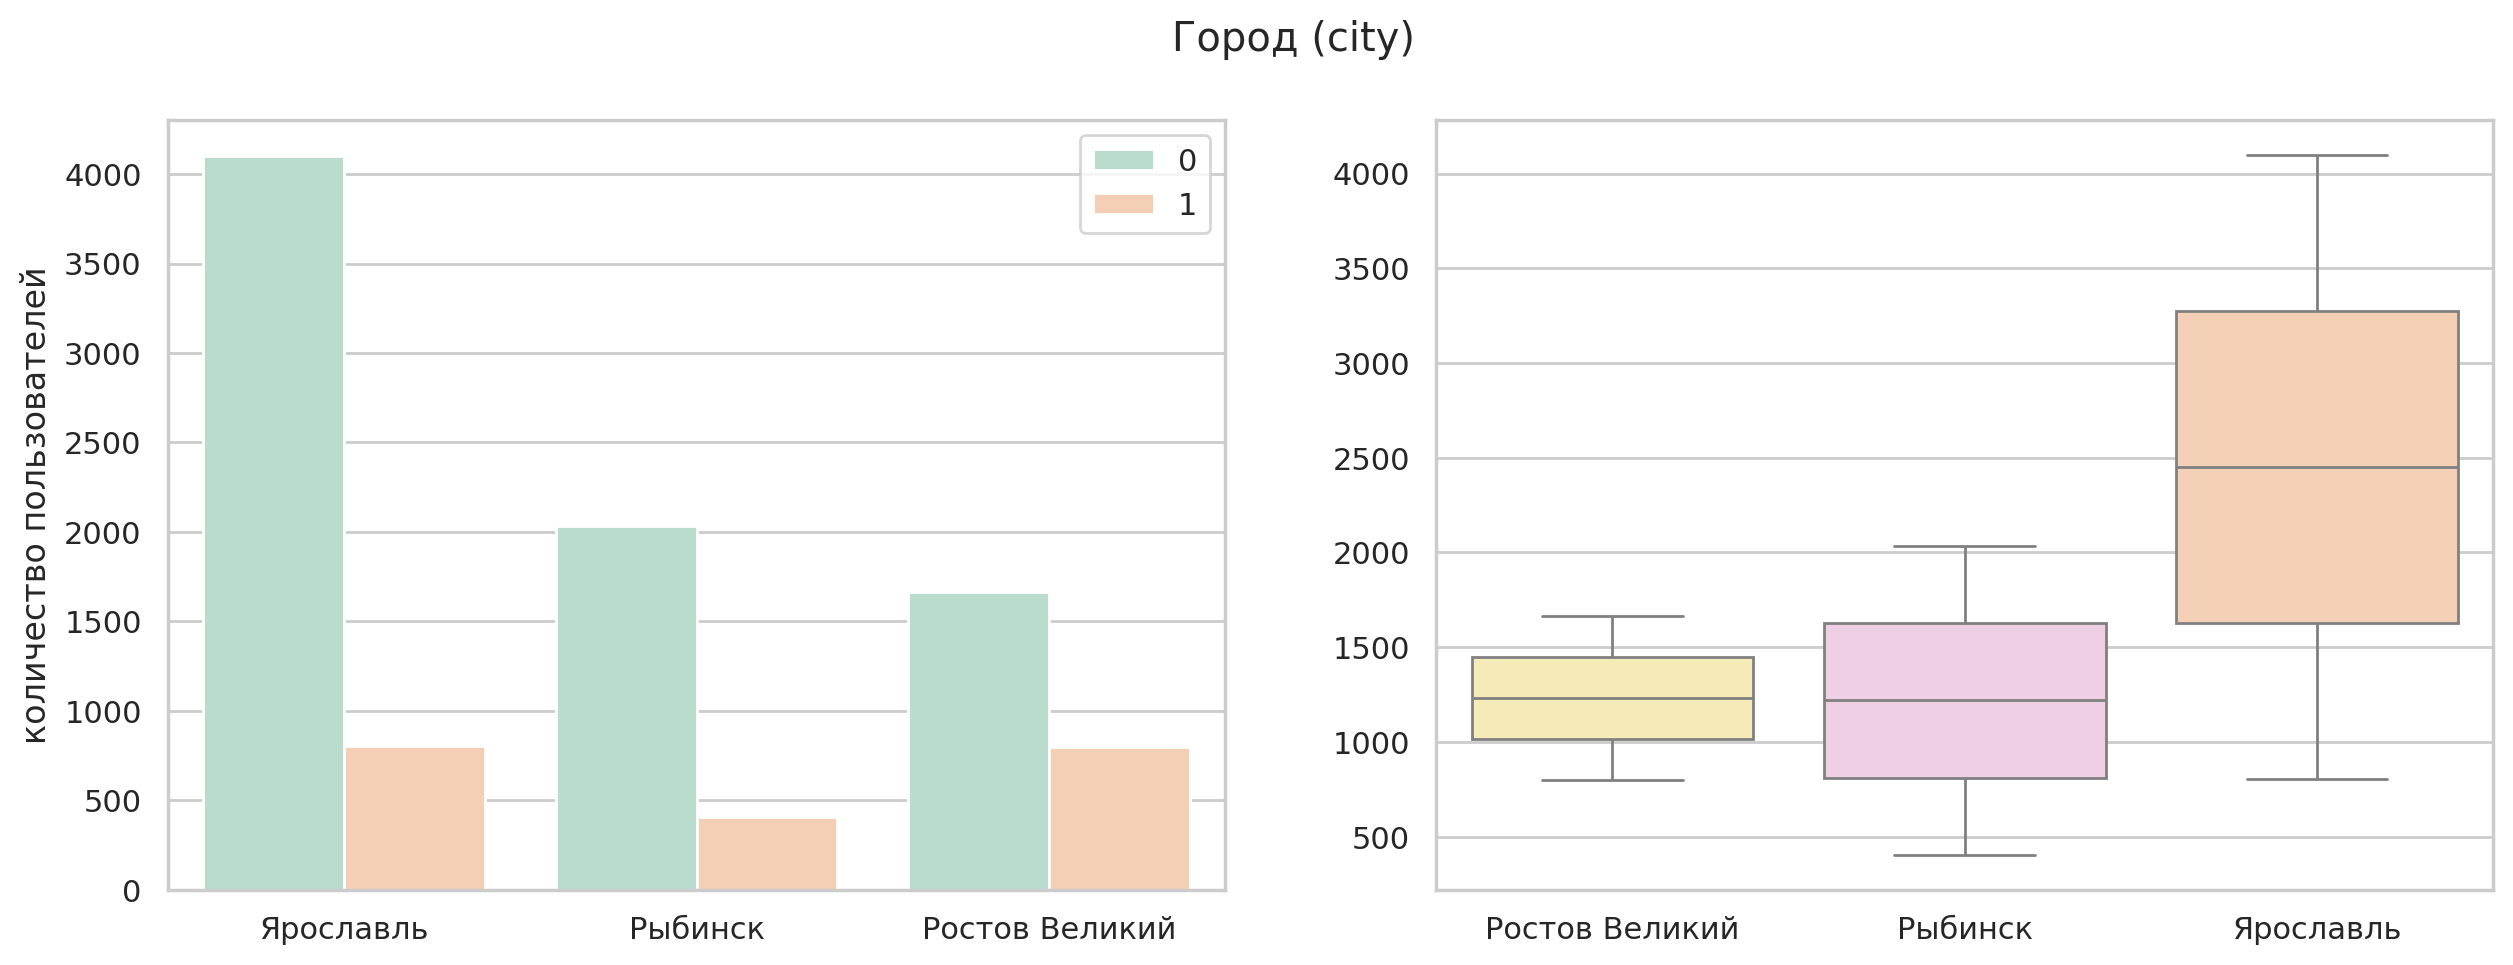

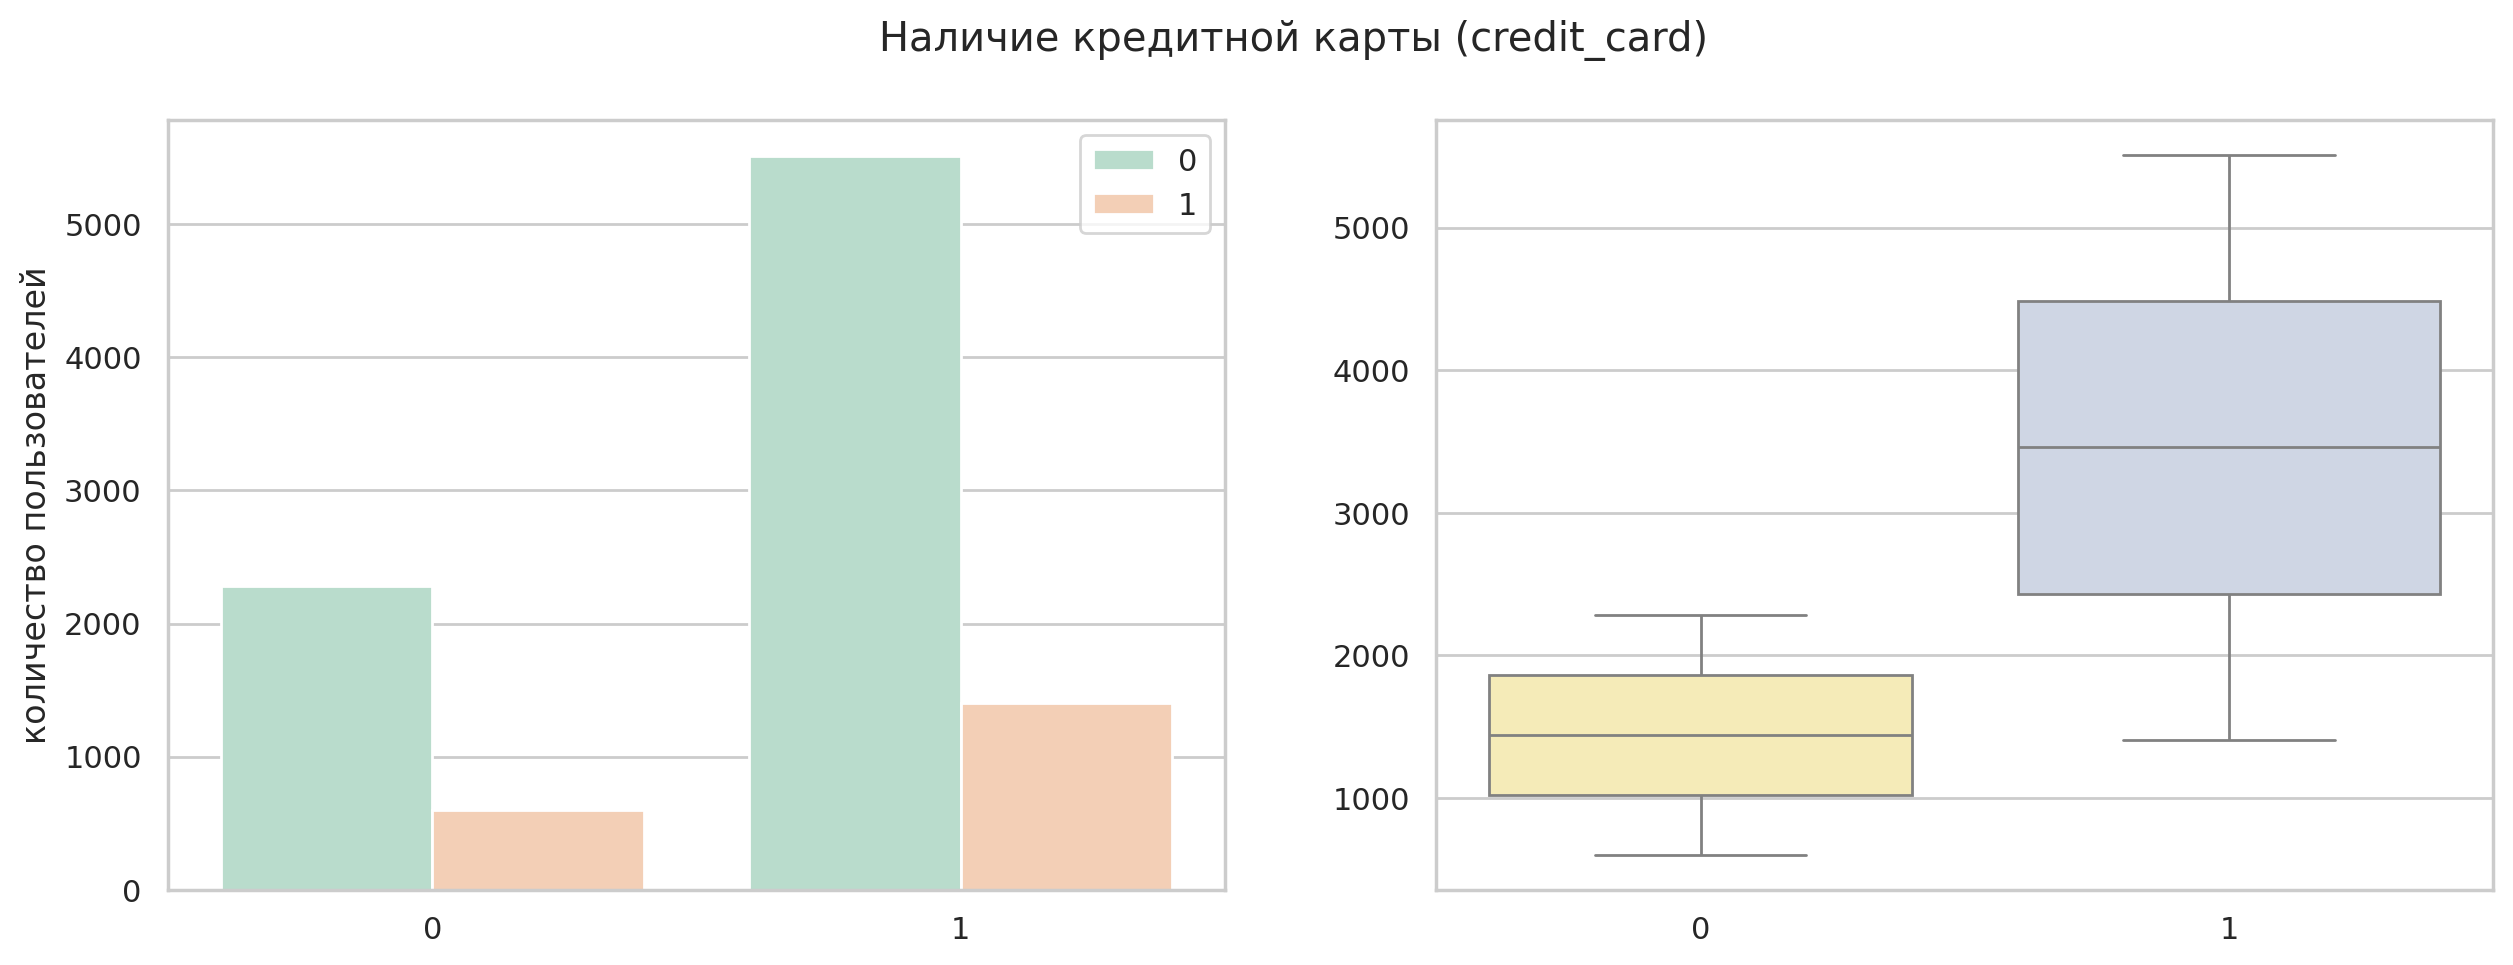

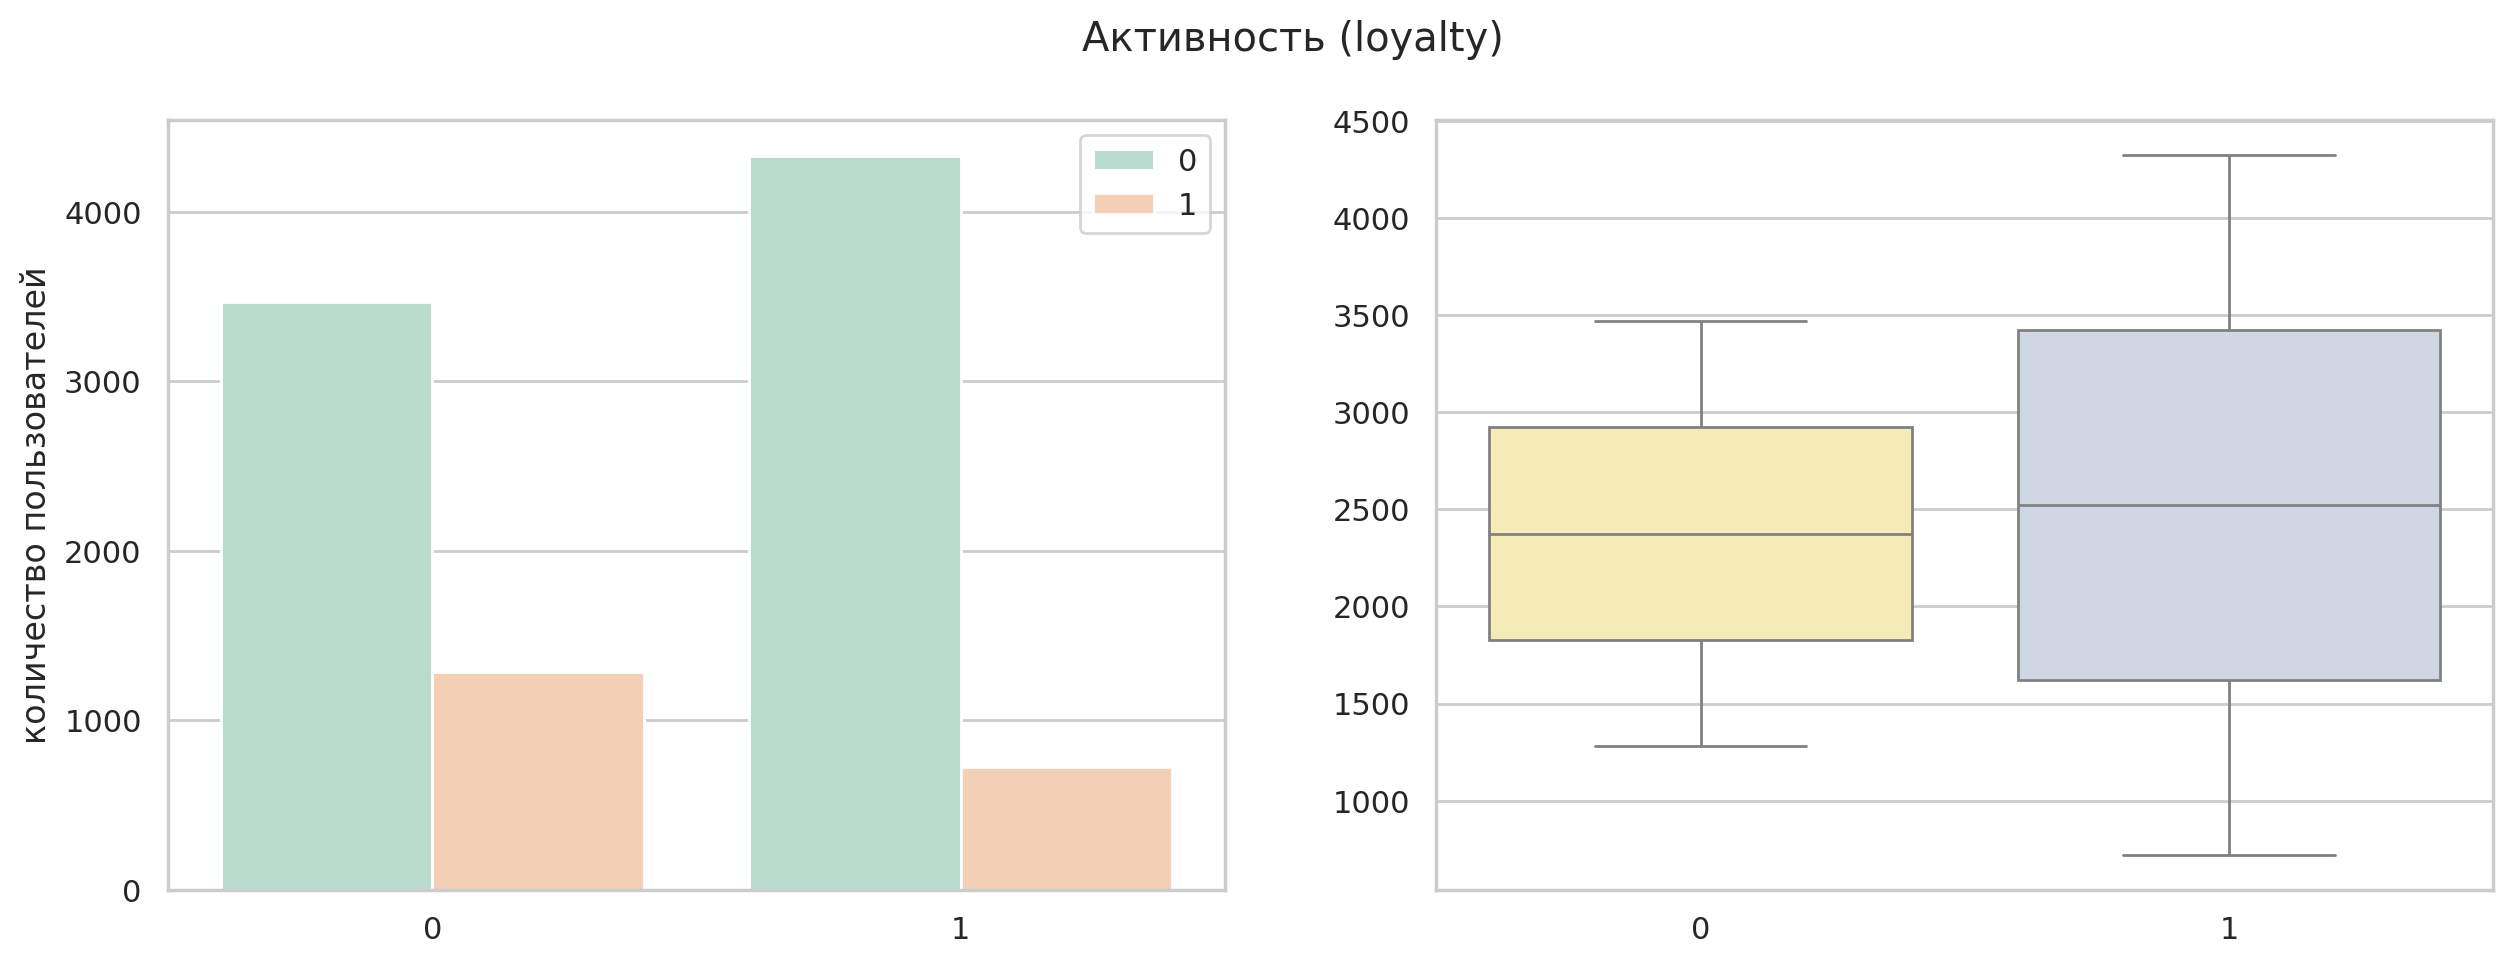

In [22]:
for index, row in categorical.iterrows():
    categorical_plots(data, row[0], row[1])

**Выводы**

По графикам можно сказать, что на отток **влияют** признаки :
1. пол (женщины попадают в эту категорию чаще);
2. возраст (пик - клиенты в диапазоне 40-50 лет);
3. город (наблюдается странная аномалия в городе Ростов Великий - половина клиентов попадает в отток);
4. количество используемых банковских продуктов (клиенты, использующие более 2х продуктов уходят в отток очень сильно);

#### Матрица корреляции

Построим матрицу корреляции признаков.

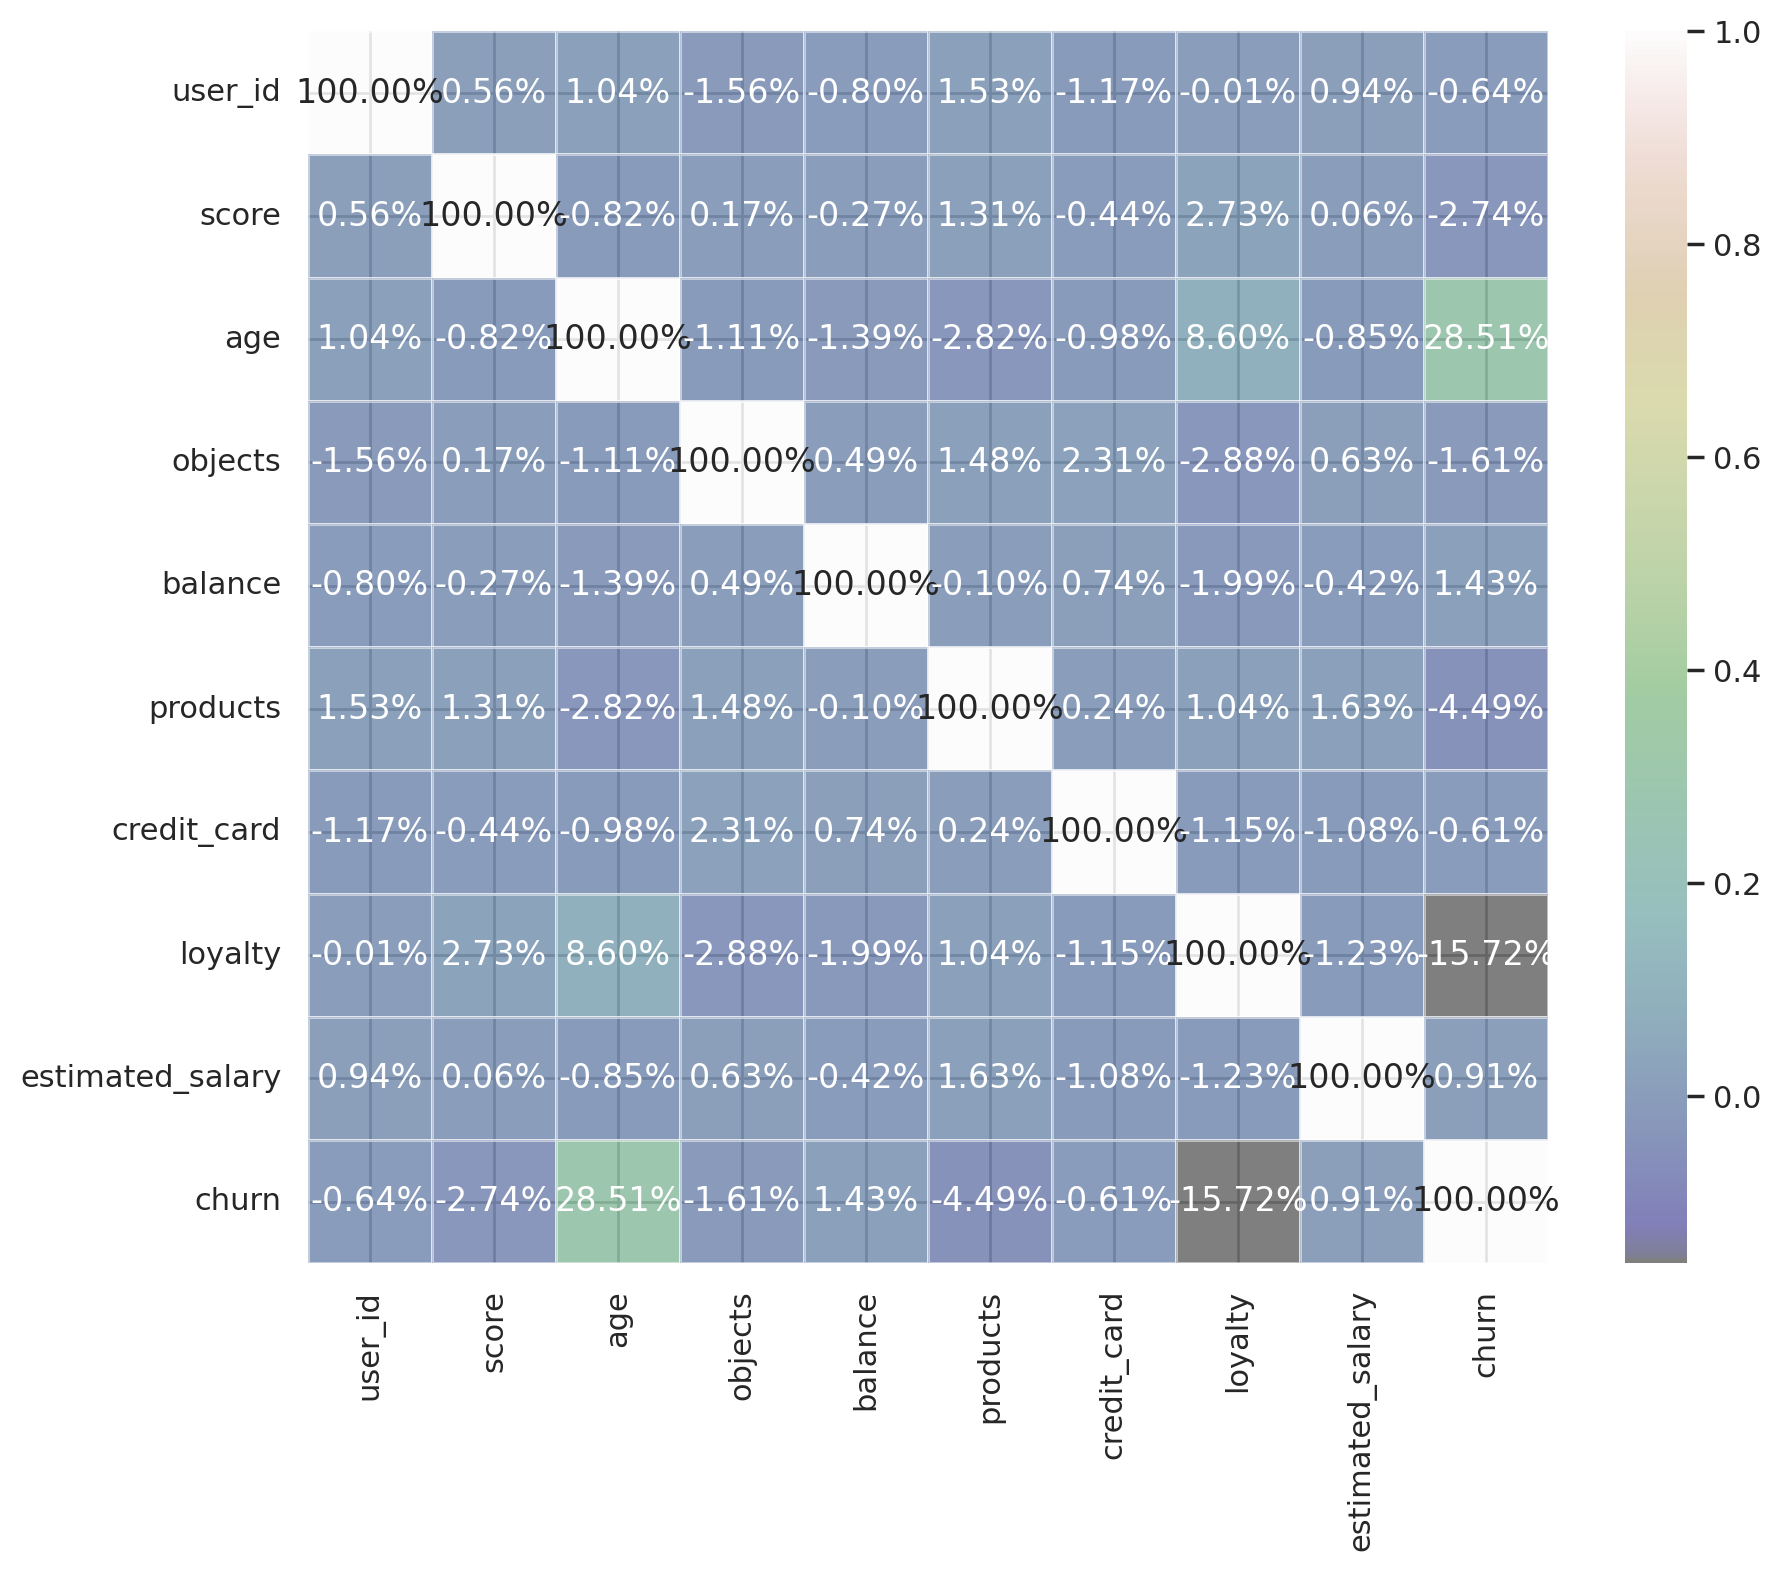

In [23]:
f, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(data.corr(), annot=True, linewidths=.5, ax=ax, cmap='gist_earth',fmt='.2%', alpha=.5)
plt.show()

**Выводы**

Сильно влияющих на отток признаков на тепловой карте не наблюдается.  
    
Больше остальных с целевой переменной коррелирует возраст клиента (`age`)  - чем он выше, тем больше вероятность оттока.   

Далее по значимости следует активность (`loyalty`) - менее активные клиенты с бОльшей вероятностью перестанут пользоваться услугами совсем.

Пар сильно коррелирующих между собой признаков не обнаружено.


### Сегментация пользователей по потреблению продуктов

Посмотрим, как распределены наши пользователи по поличеству потребляемых банковских продуктов.   
Напомним, что, по нашему мнению, речь идет о линейке кредитных продуктов.

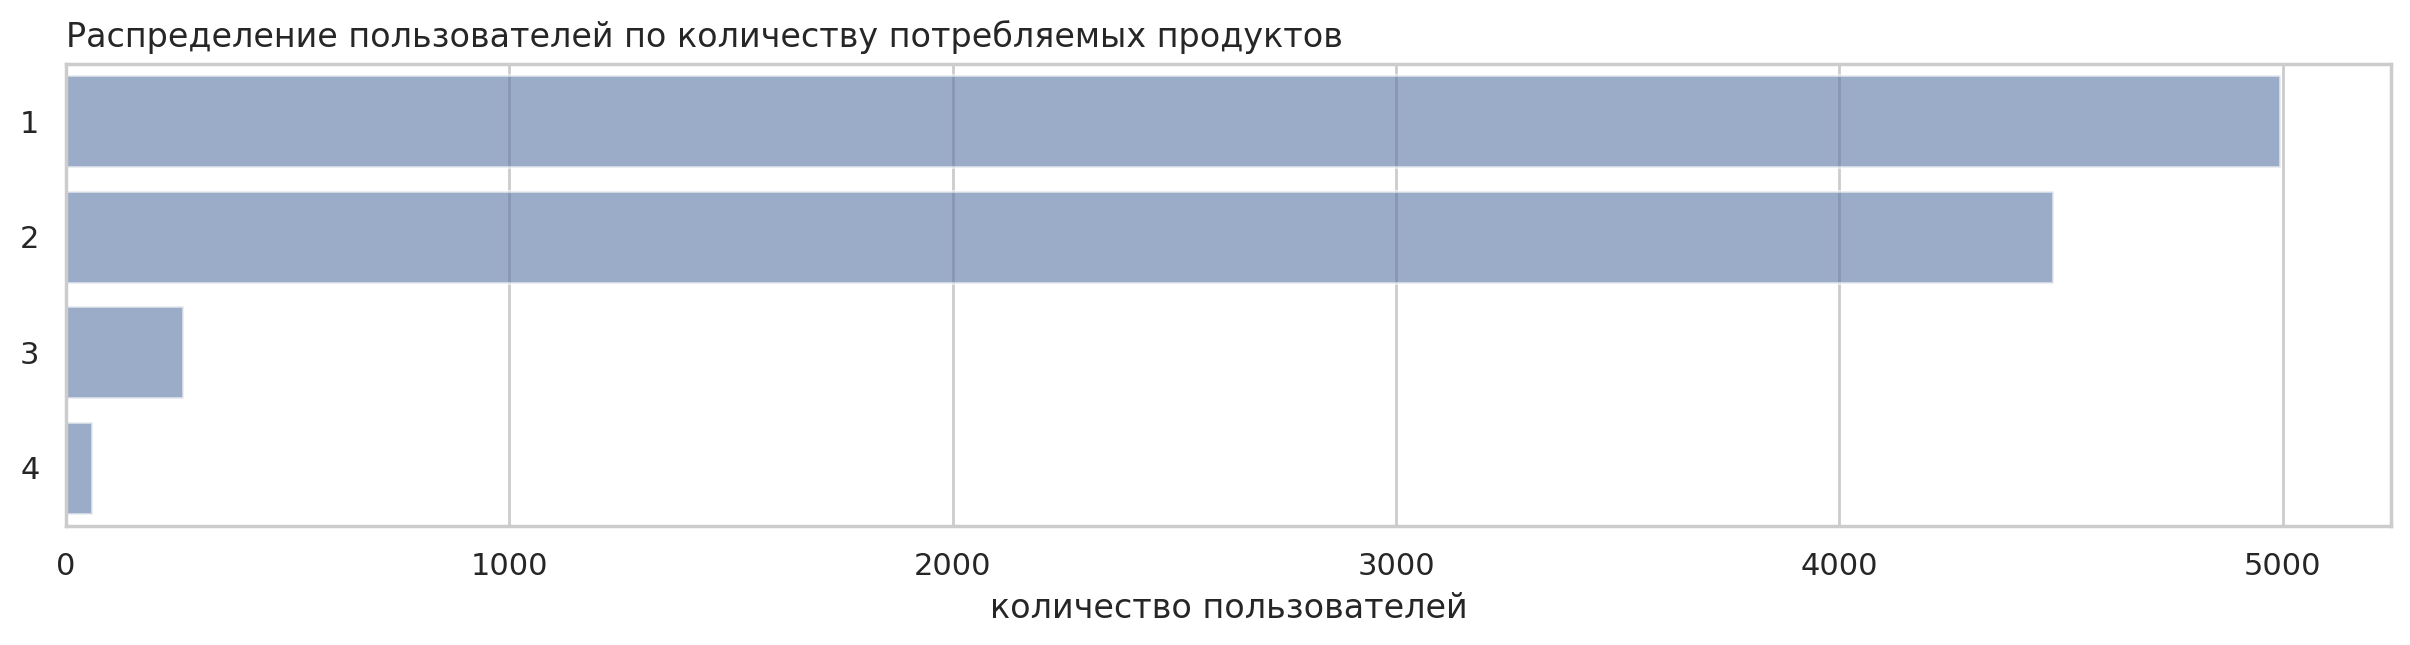

In [24]:
plt.figure(figsize=(15, 3))
ax = sns.barplot(x='count',
                 y='products',
                 data=data.groupby('products').agg(count=('user_id','count')).reset_index(),
                 orient='h', alpha=0.6)
ax.set_title('Распределение пользователей по количеству потребляемых продуктов', loc='left')
ax.set_xlabel('количество пользователей')
ax.set_ylabel('')
plt.show()

Подавляющее большинство клиентов использует один или два продукта.    

In [25]:
data.groupby('products').agg('mean').T

products,1,2,3,4
user_id,"15,732,743.80","15,735,004.80","15,741,758.43","15,719,361.27"
score,648.88,652.27,647.36,653.58
age,39.66,37.77,43.20,45.68
objects,4.97,5.06,5.00,5.30
balance,"119,929.45","119,709.29","119,475.69","122,260.61"
credit_card,0.70,0.71,0.71,0.68
loyalty,0.50,0.53,0.43,0.48
estimated_salary,"101,247.91","102,848.11","104,698.80","104,763.72"
churn,0.28,0.08,0.83,1.00


Какие отличительные признаки мы видим по таблице:

**Один продукт**
1. Отток  - 28%:
2. Половина пользователей - c повышенной автивностью;
3. Средняя зарплата ниже, чем у пользователей с другим количеством продуктов;
4. Среднее количество объектов недвижимости меньше, чем у других пользователей.

**Два продукта**
1. Самый низкий отток среди пользователей - 8%;
2. Самая высокая активность среди клиентов;
3. Средний возраст клиентов ниже аналогичных показателей других групп;
4. По остальным признакам группа похожа на клиентов с одним продуктом.

**Три продукта**
1. Очень высокий отток - 83%;
2. Самый низкий показатель активности (43%)

**Четыре продукта**
1. Отток 100%
2. Самая возрастная группа - средний возраст более 45 лет;
3. Самый низкий показатель по наличию кредитной карты.


#### Гистограммы и распределения признаков

При помощи функций построим столбчатые диаграммы для категориальных признаков и гистограммы распределения для числовых признаков, а так же диаграммы размаха.

In [26]:
# функция по отрисовке гистограммы распределения и диаграммы размаха для числовых признаков;
# на входе функции передем параметры: датафрейм, название столбца, по которому строим график, название графика;

def numeric_plots(df, col, title):
    fig, ax = plt.subplots(figsize = (15, 5))

    sns.histplot(df[df['products']==1][col], label = '1 продукт', color = '#EFC87B', ax = plt.subplot(1, 2, 1))
    sns.histplot(df[df['products']==2][col], label = '2 продукта', color = '#184562', ax = plt.subplot(1, 2, 1), alpha=.4)
    sns.histplot(df[df['products']==3][col], label = '3 продукта', color = '#189562', ax = plt.subplot(1, 2, 1), alpha=.4)
    sns.histplot(df[df['products']==4][col], label = '4 продукта', color = '#184532', ax = plt.subplot(1, 2, 1), alpha=.4)
    plt.xlabel('')
    plt.ylabel('количество пользователей')
    plt.legend()

    sns.boxplot(y = col, x = 'products', data = df, ax = plt.subplot(1, 2, 2), palette='Pastel2_r')
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(np.arange(4), ('1 продукт', '2 продукта','3 продукта', '4 продукта'))

    fig.suptitle(title + ' (' + col + ')')
    plt.show()

In [27]:
# функция по отрисовке столбчатых диаграмм и диаграммы размаха для категориальных признаков;
# на входе функции передем параметры: датафрейм, название столбца, по которому строим график, название графика;

def categorical_plots(df, col, title):
    fig, ax = plt.subplots(figsize = (15, 5))

    sns.countplot(x = col, hue = 'products', data = df, ax = plt.subplot(1, 2, 1),  palette='Pastel2')
    plt.ylabel('количество пользователей')
    plt.xlabel('')
    plt.legend()

    gr = df.groupby([col, 'products']).agg(count=('user_id', 'count')).reset_index()
    sns.boxplot(x = col, y = 'count', data = gr, ax = plt.subplot(1, 2, 2), palette='Pastel2_r')

    plt.xlabel('')
    plt.ylabel('')


    fig.suptitle(title + ' (' + col + ')')
    plt.show()


In [28]:
# соберём для удобства в DataFrame название колонок и названия графиков:

numeric = pd.DataFrame({'col' : ['score', 'age', 'objects', 'balance', 'estimated_salary'],
                        'title' : ['Баллы кредитного скорринга', 'Возраст',
                                   'Количество объектов недвижимости в собственности',
                                   'Баланс','Заработная плата клиента']
                       })

categorical = pd.DataFrame({'col' : ['gender', 'city', 'credit_card', 'loyalty', 'churn'],
                            'title' : ['Пол', 'Город', 'Наличие кредитной карты', 'Активность', 'Отток']
                            })


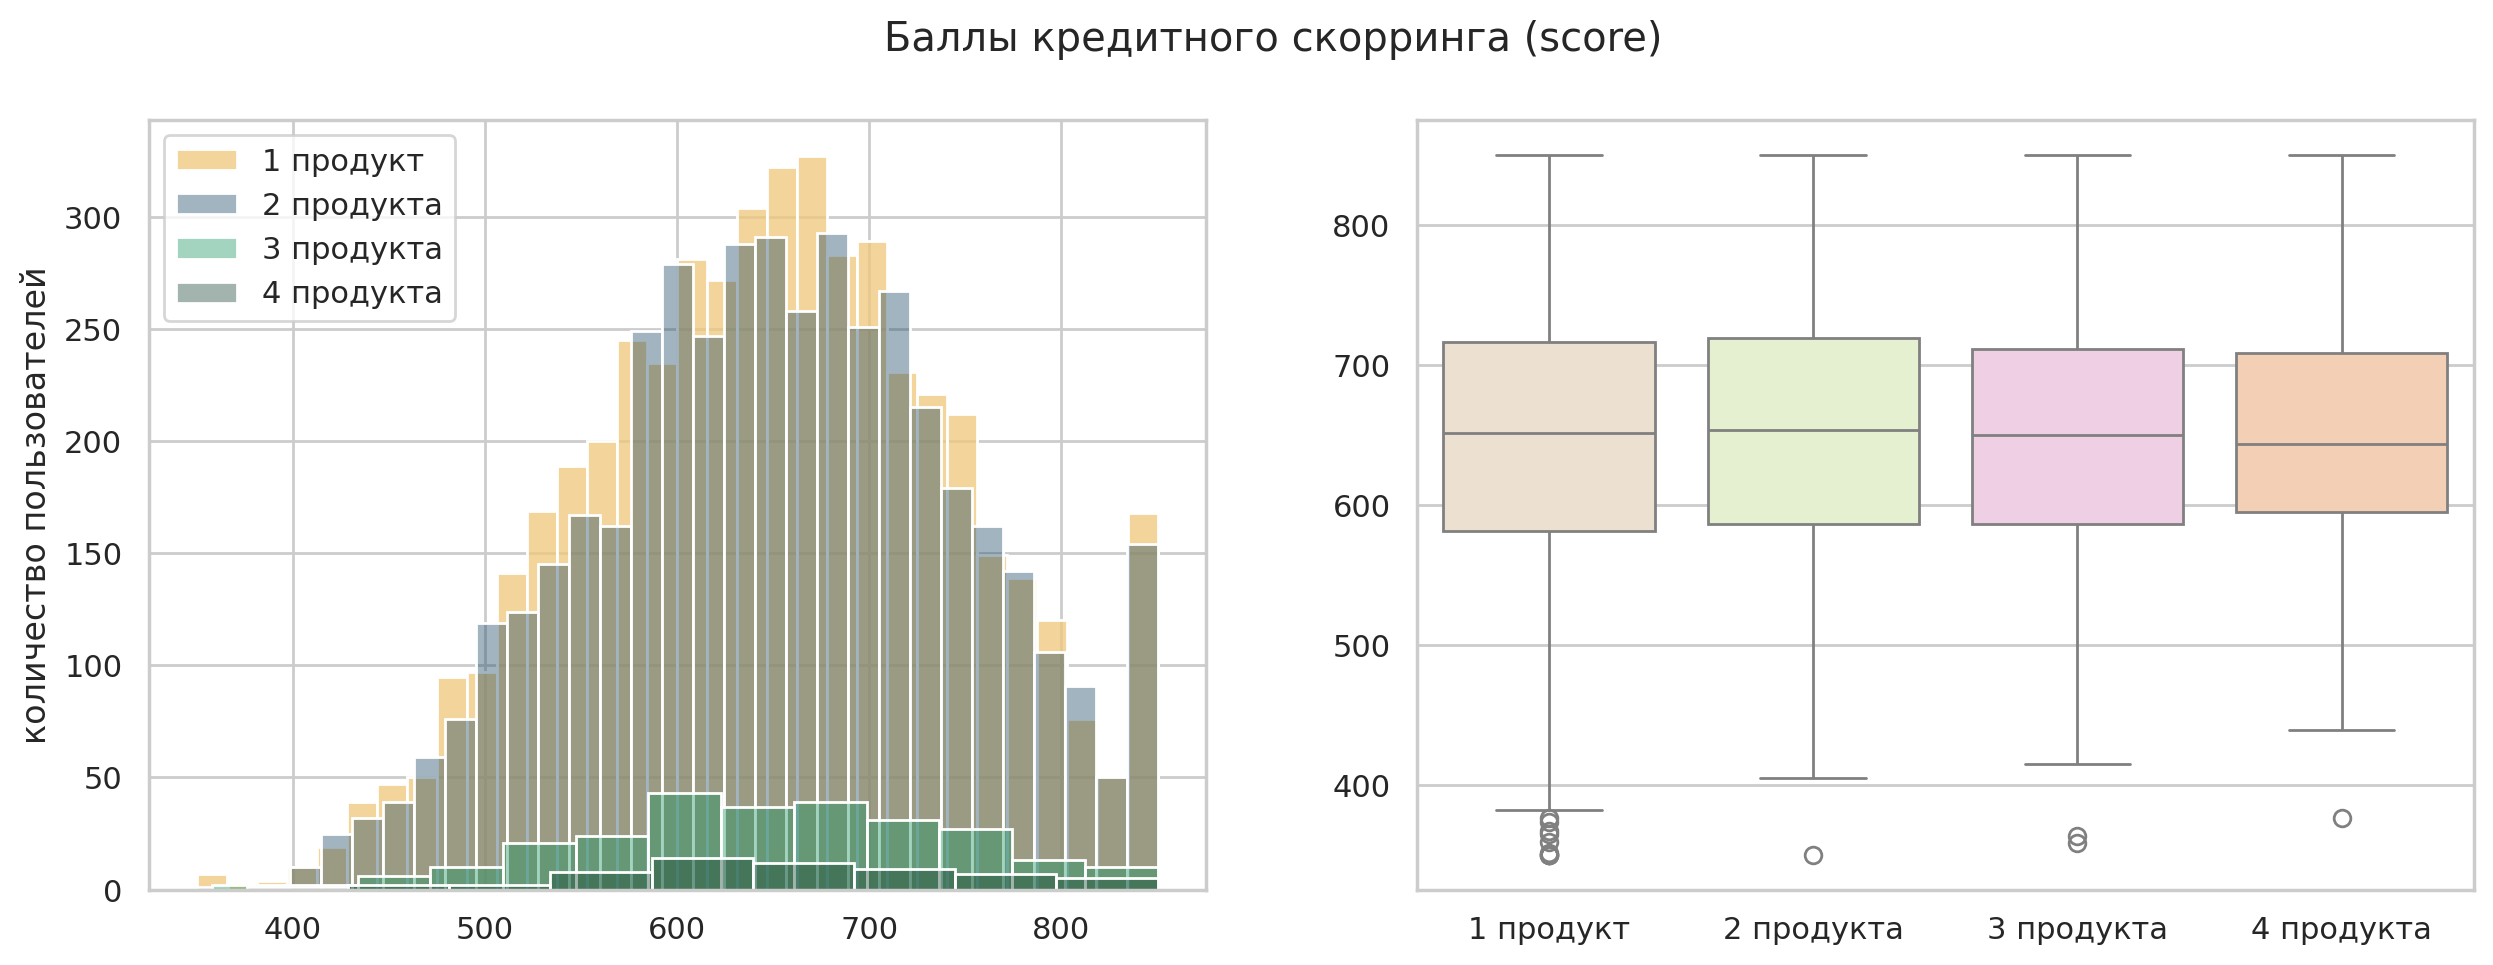

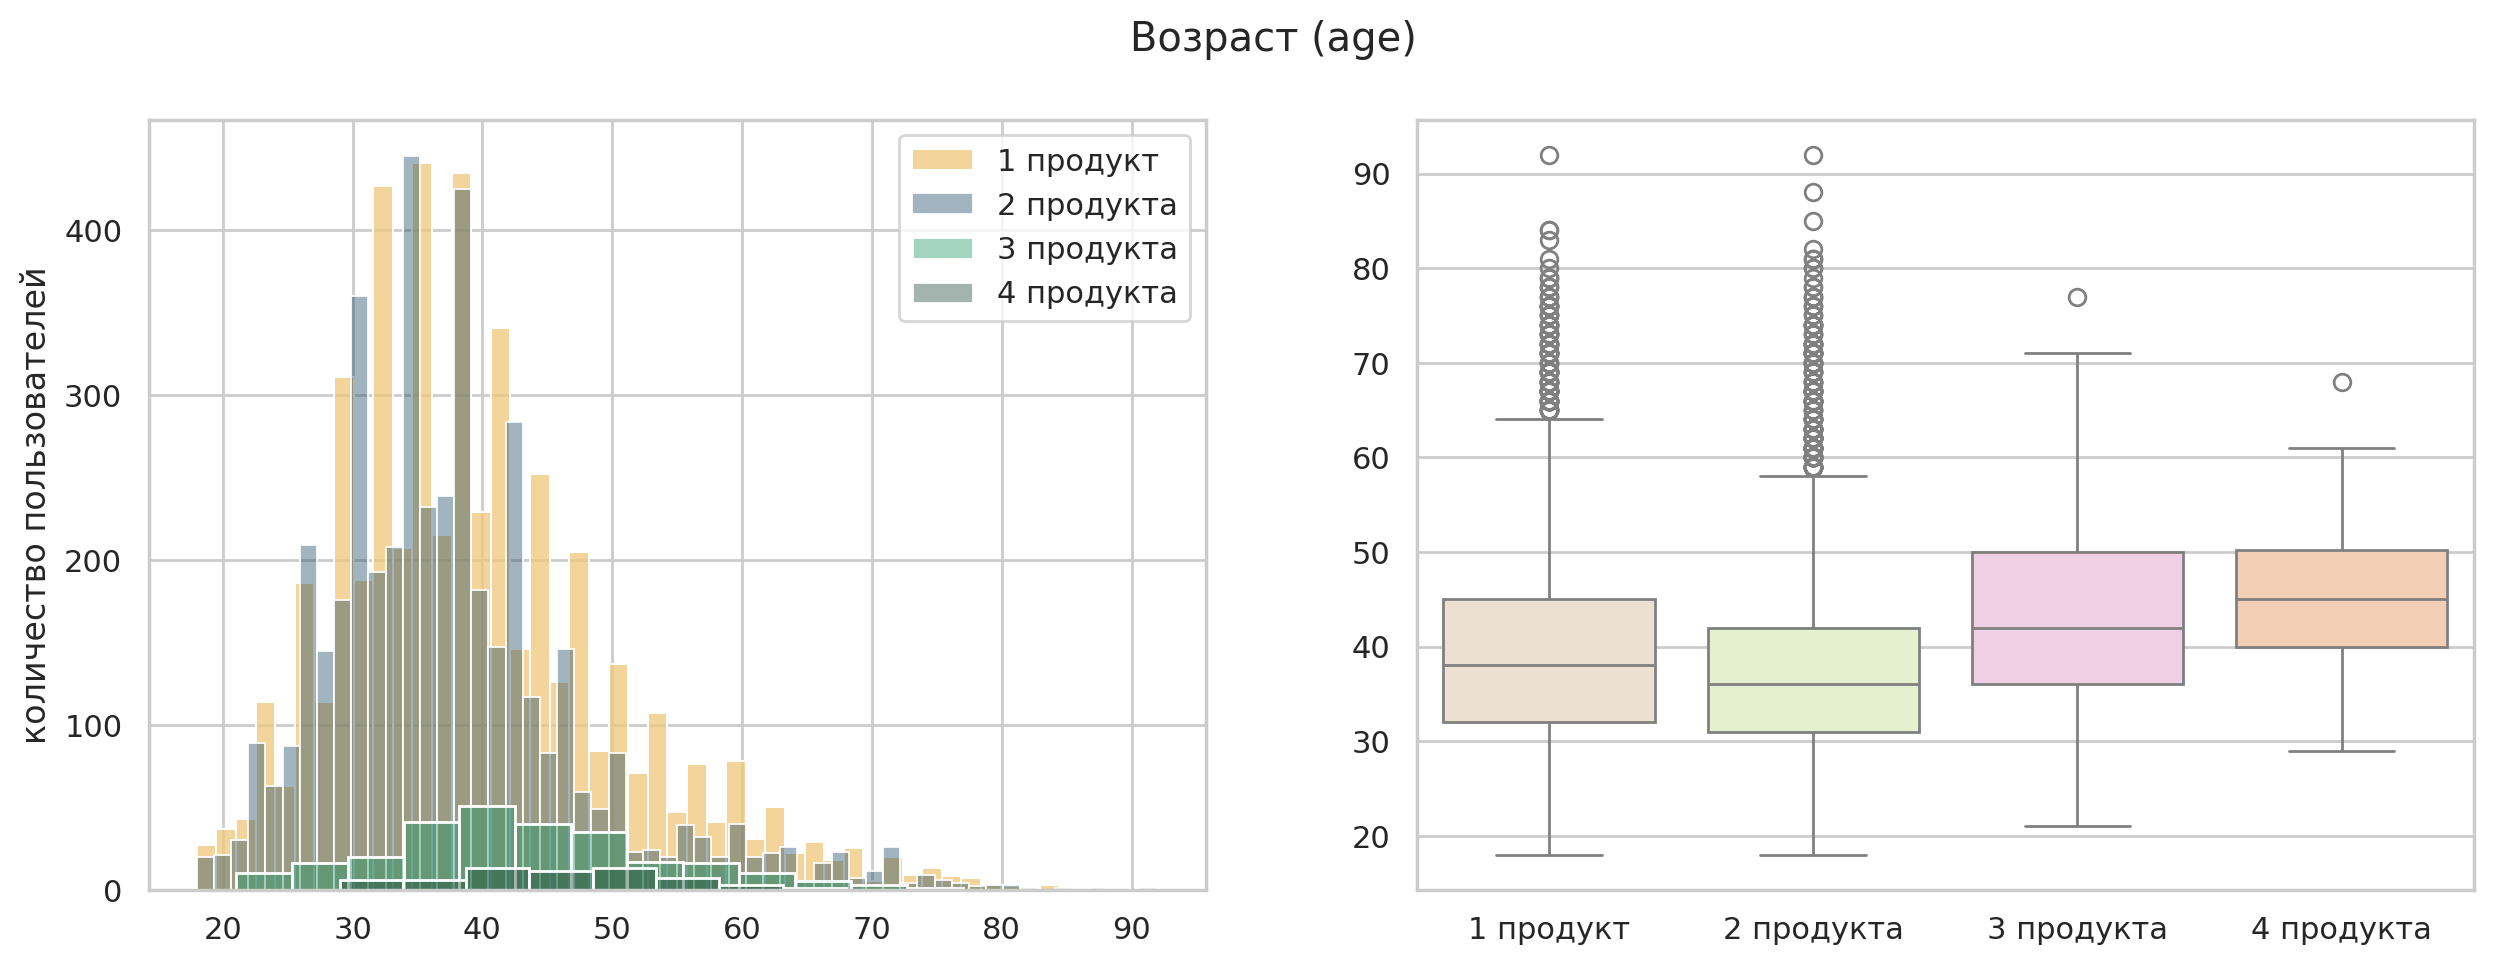

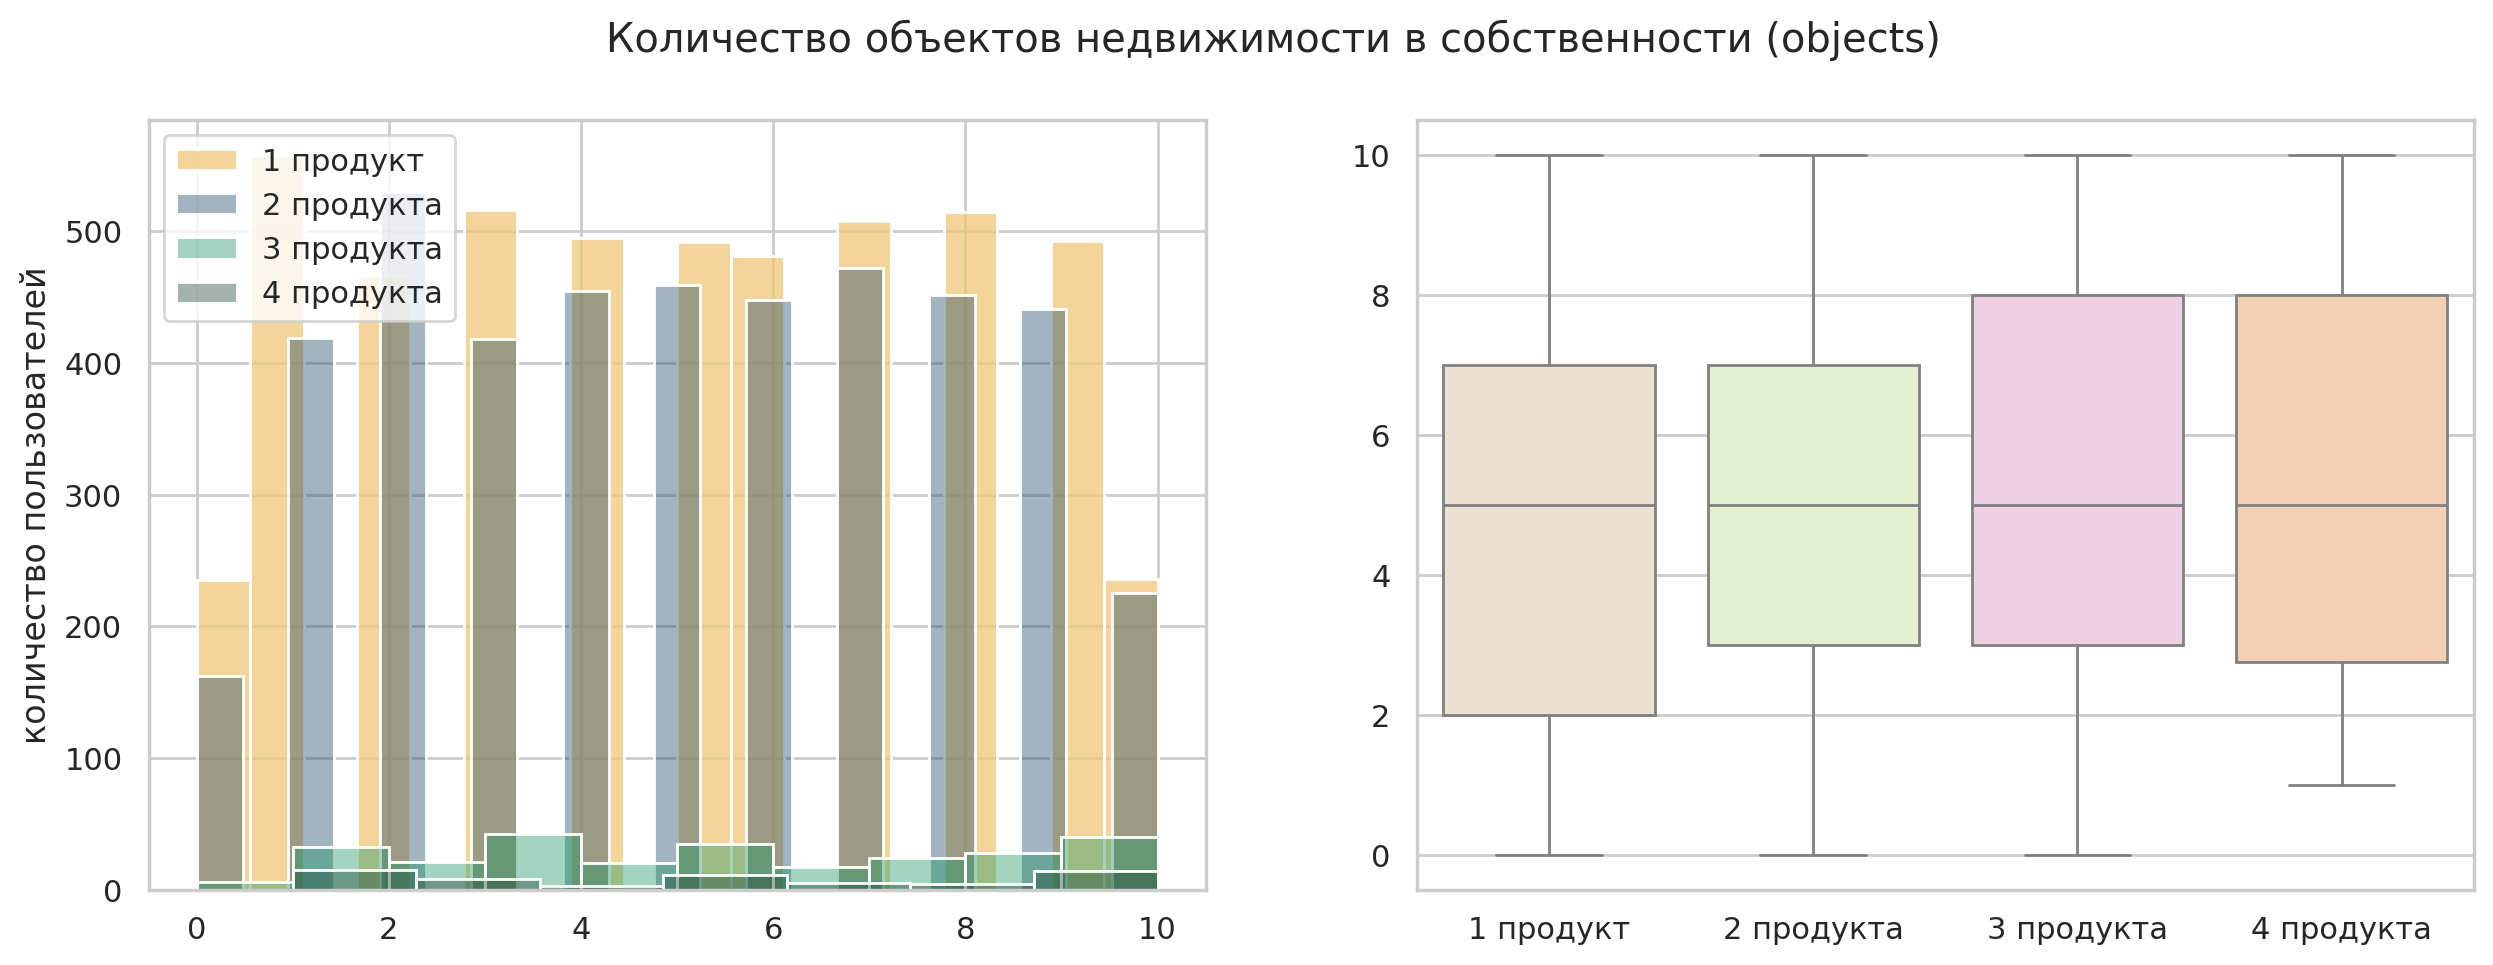

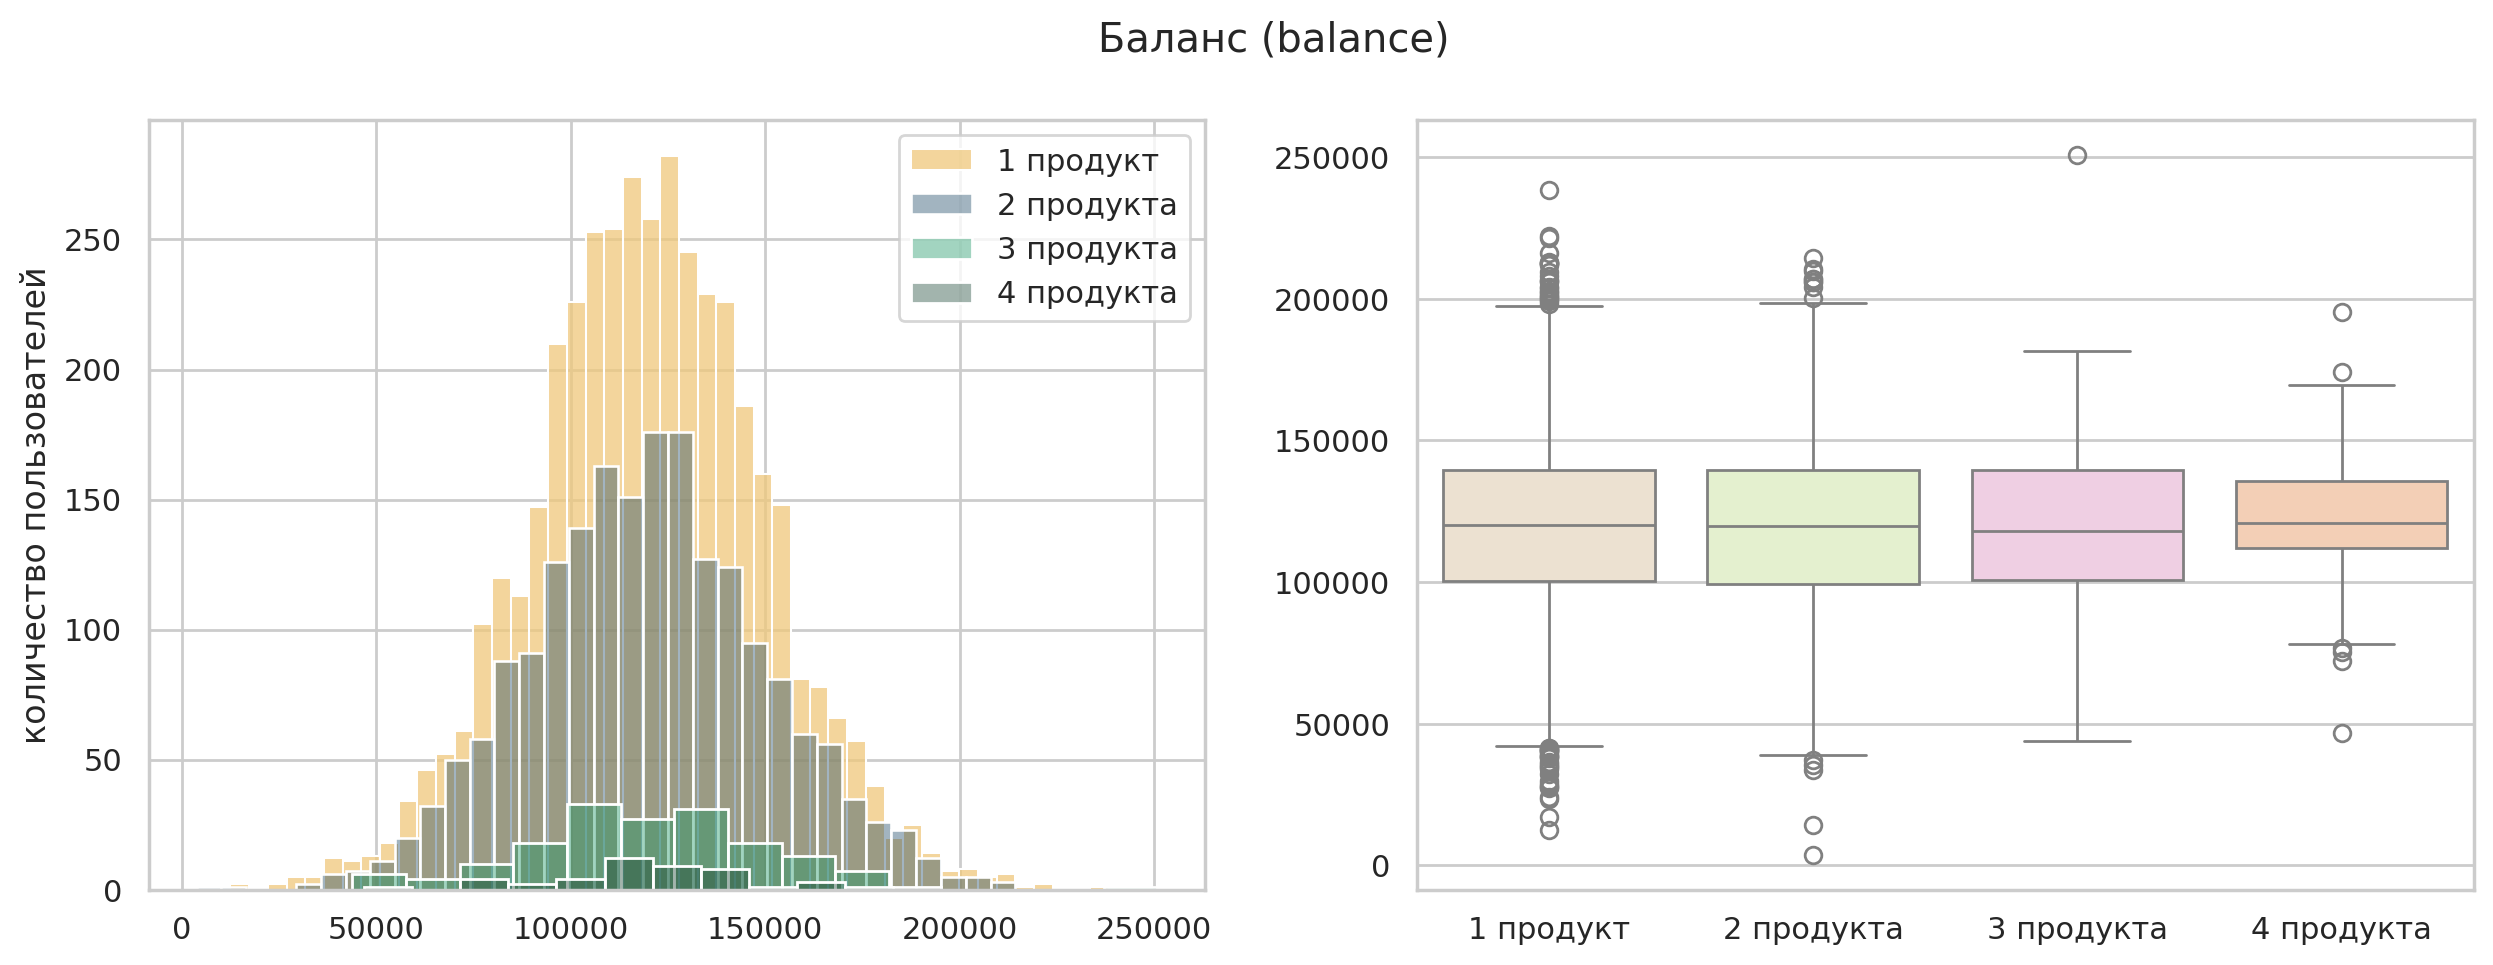

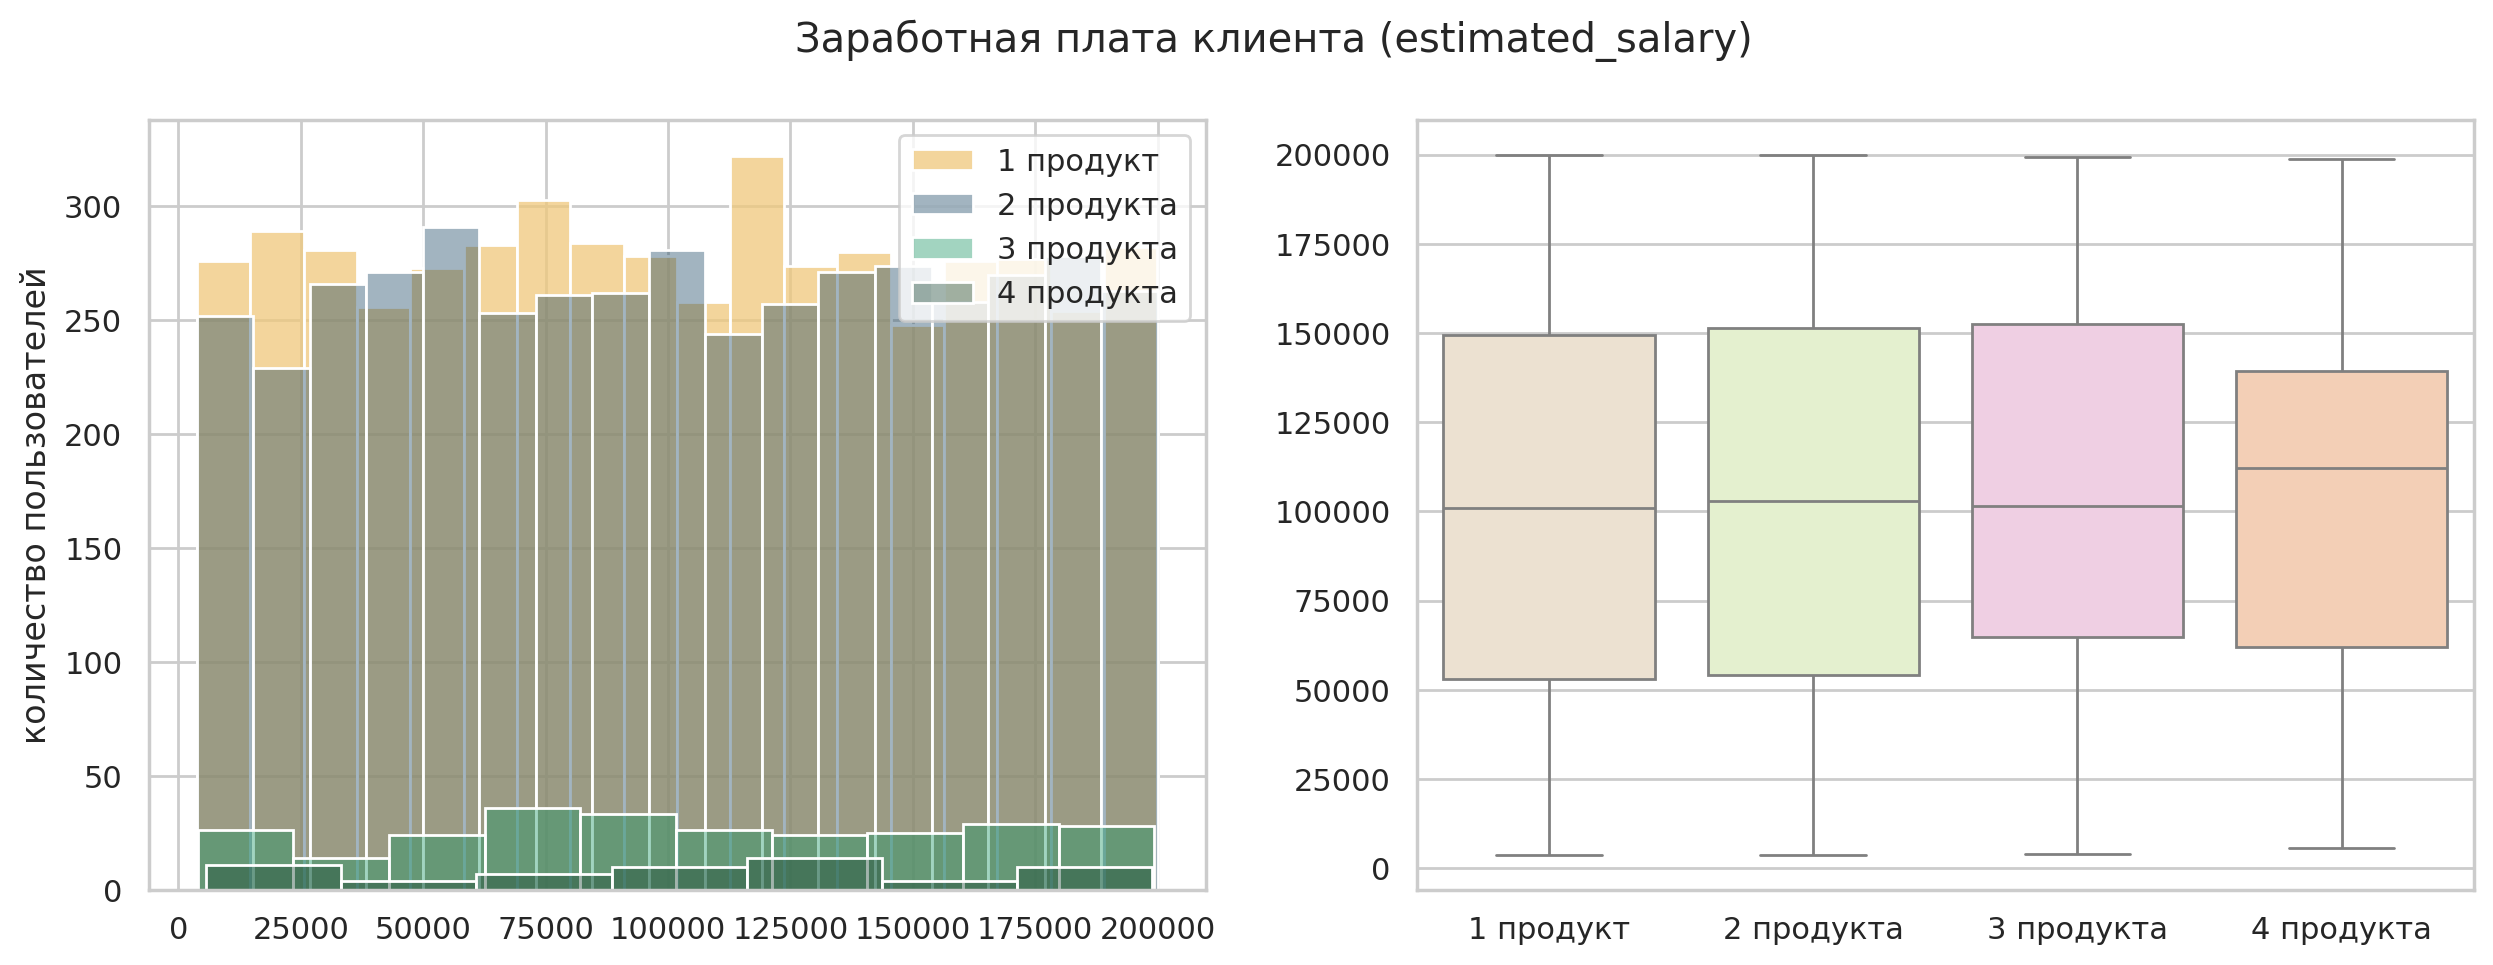

In [29]:
for index, row in numeric.iterrows():
    numeric_plots(data, row[0], row[1])

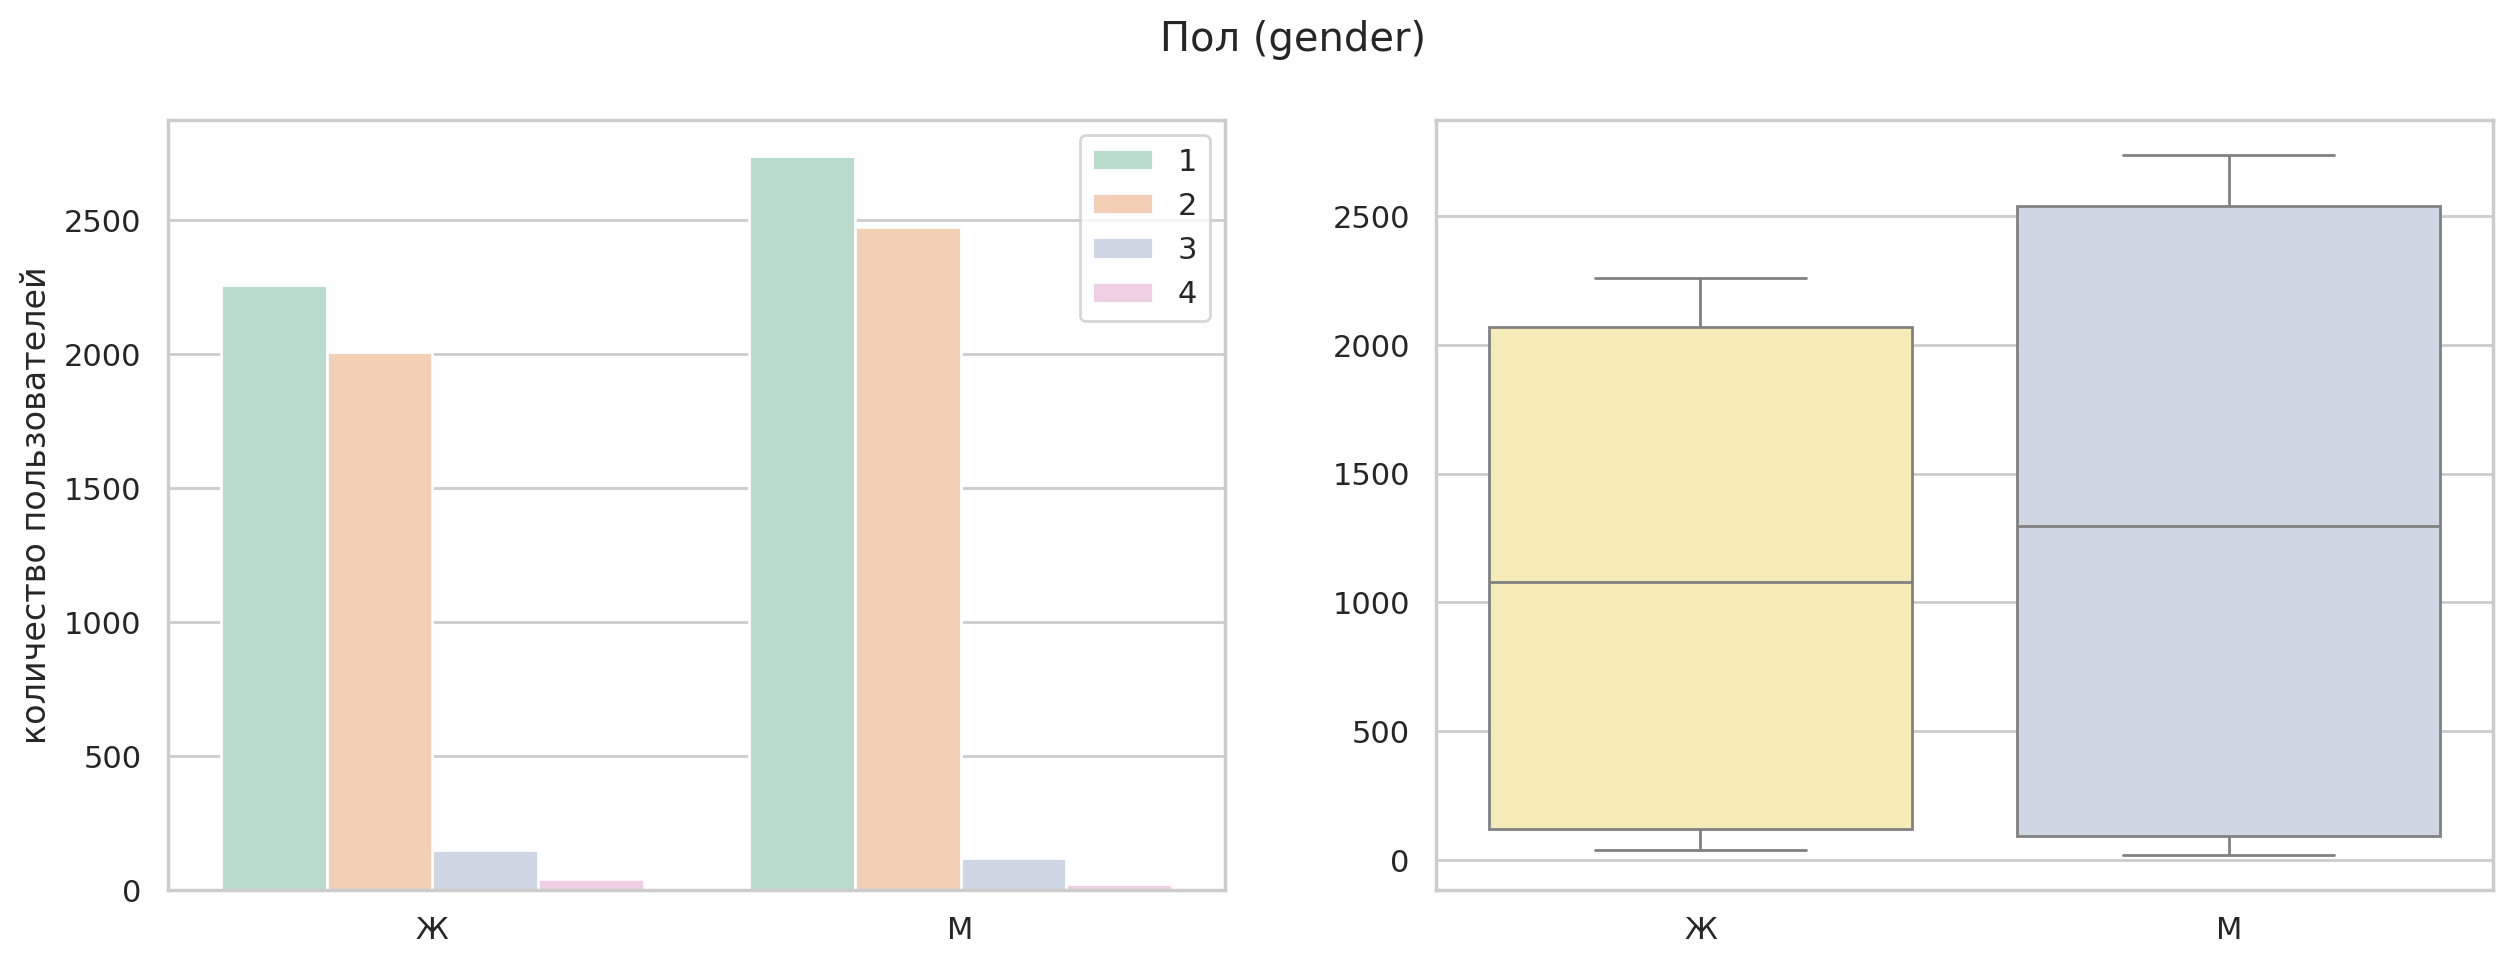

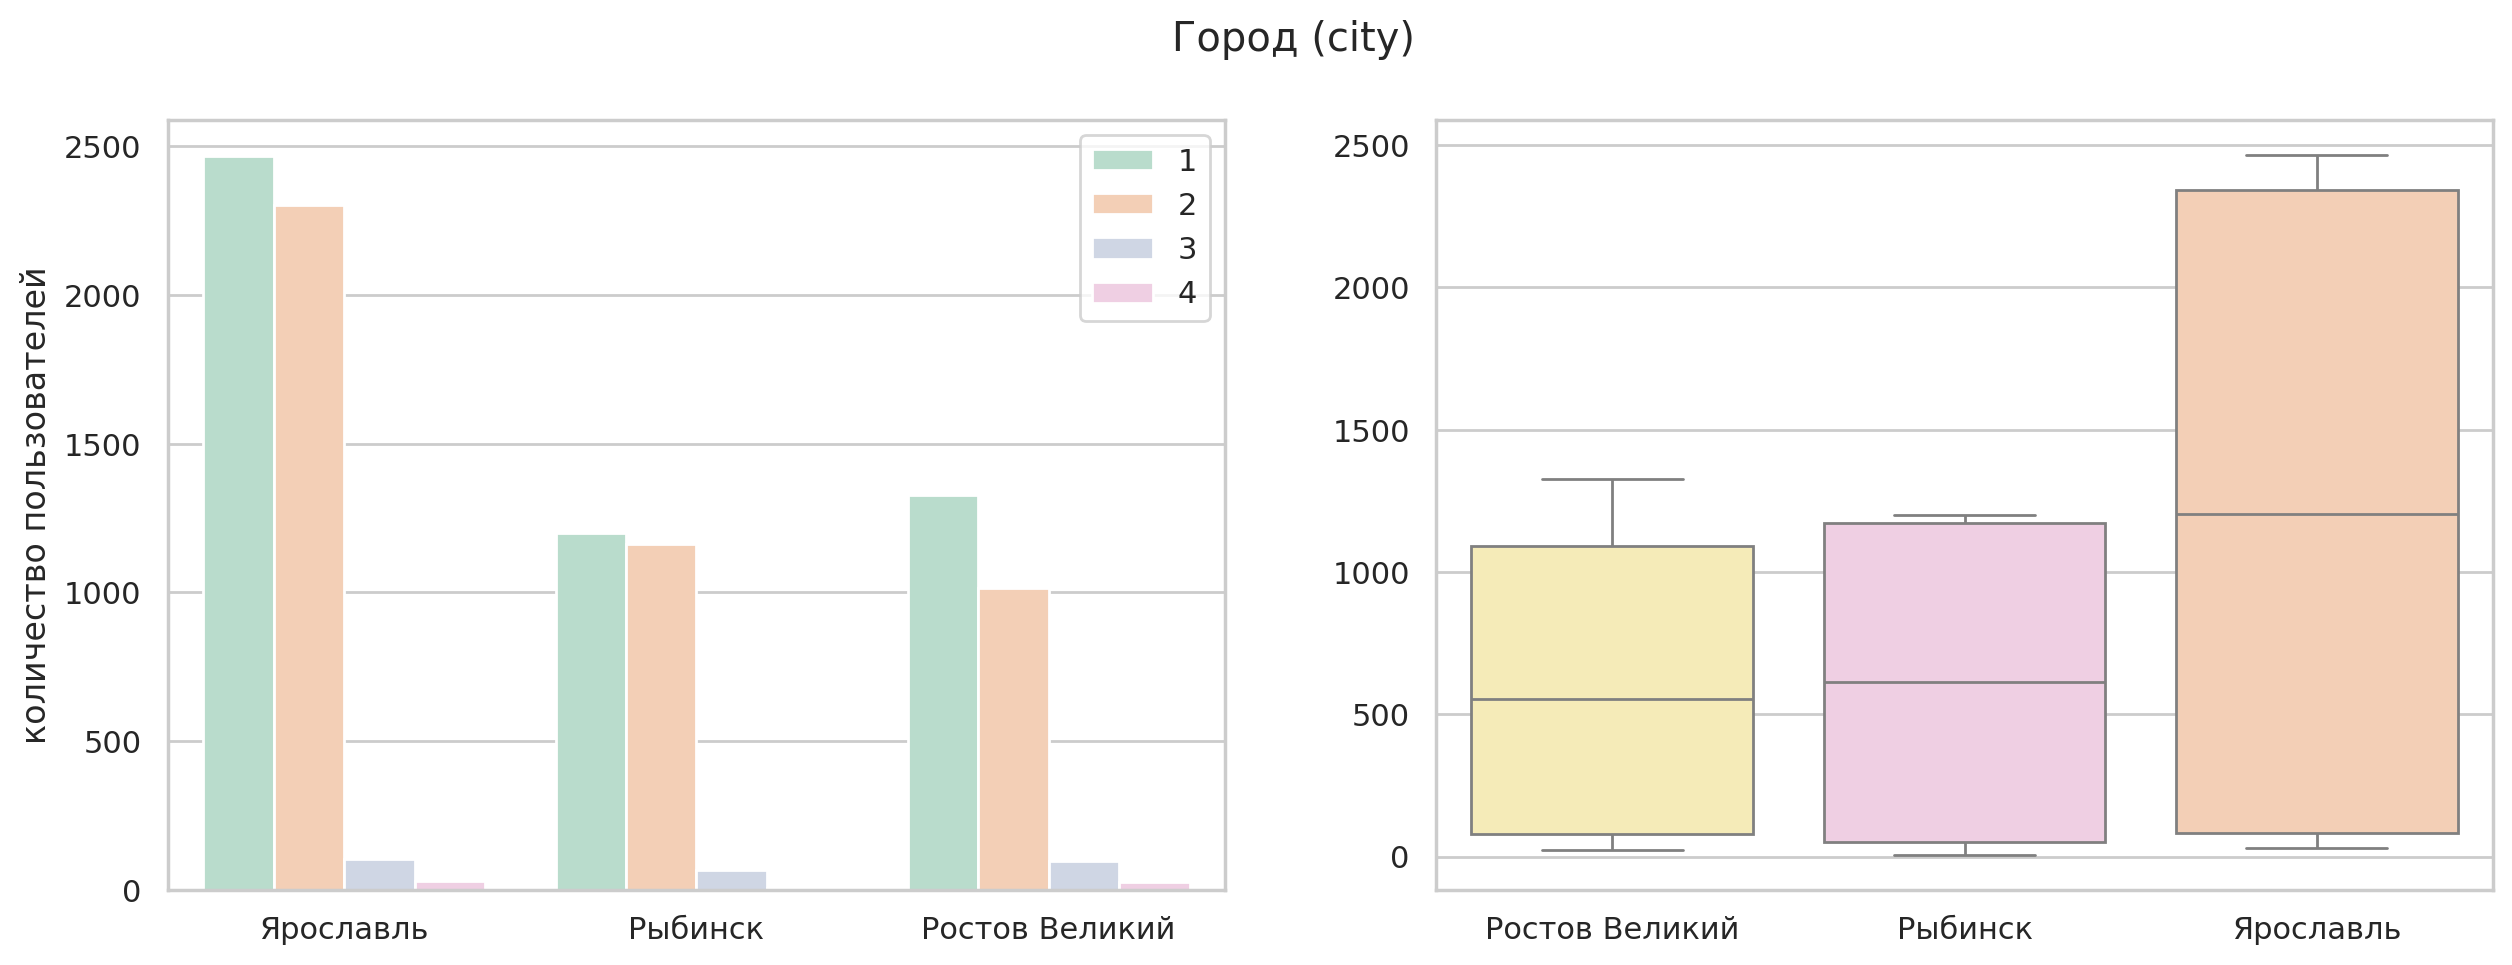

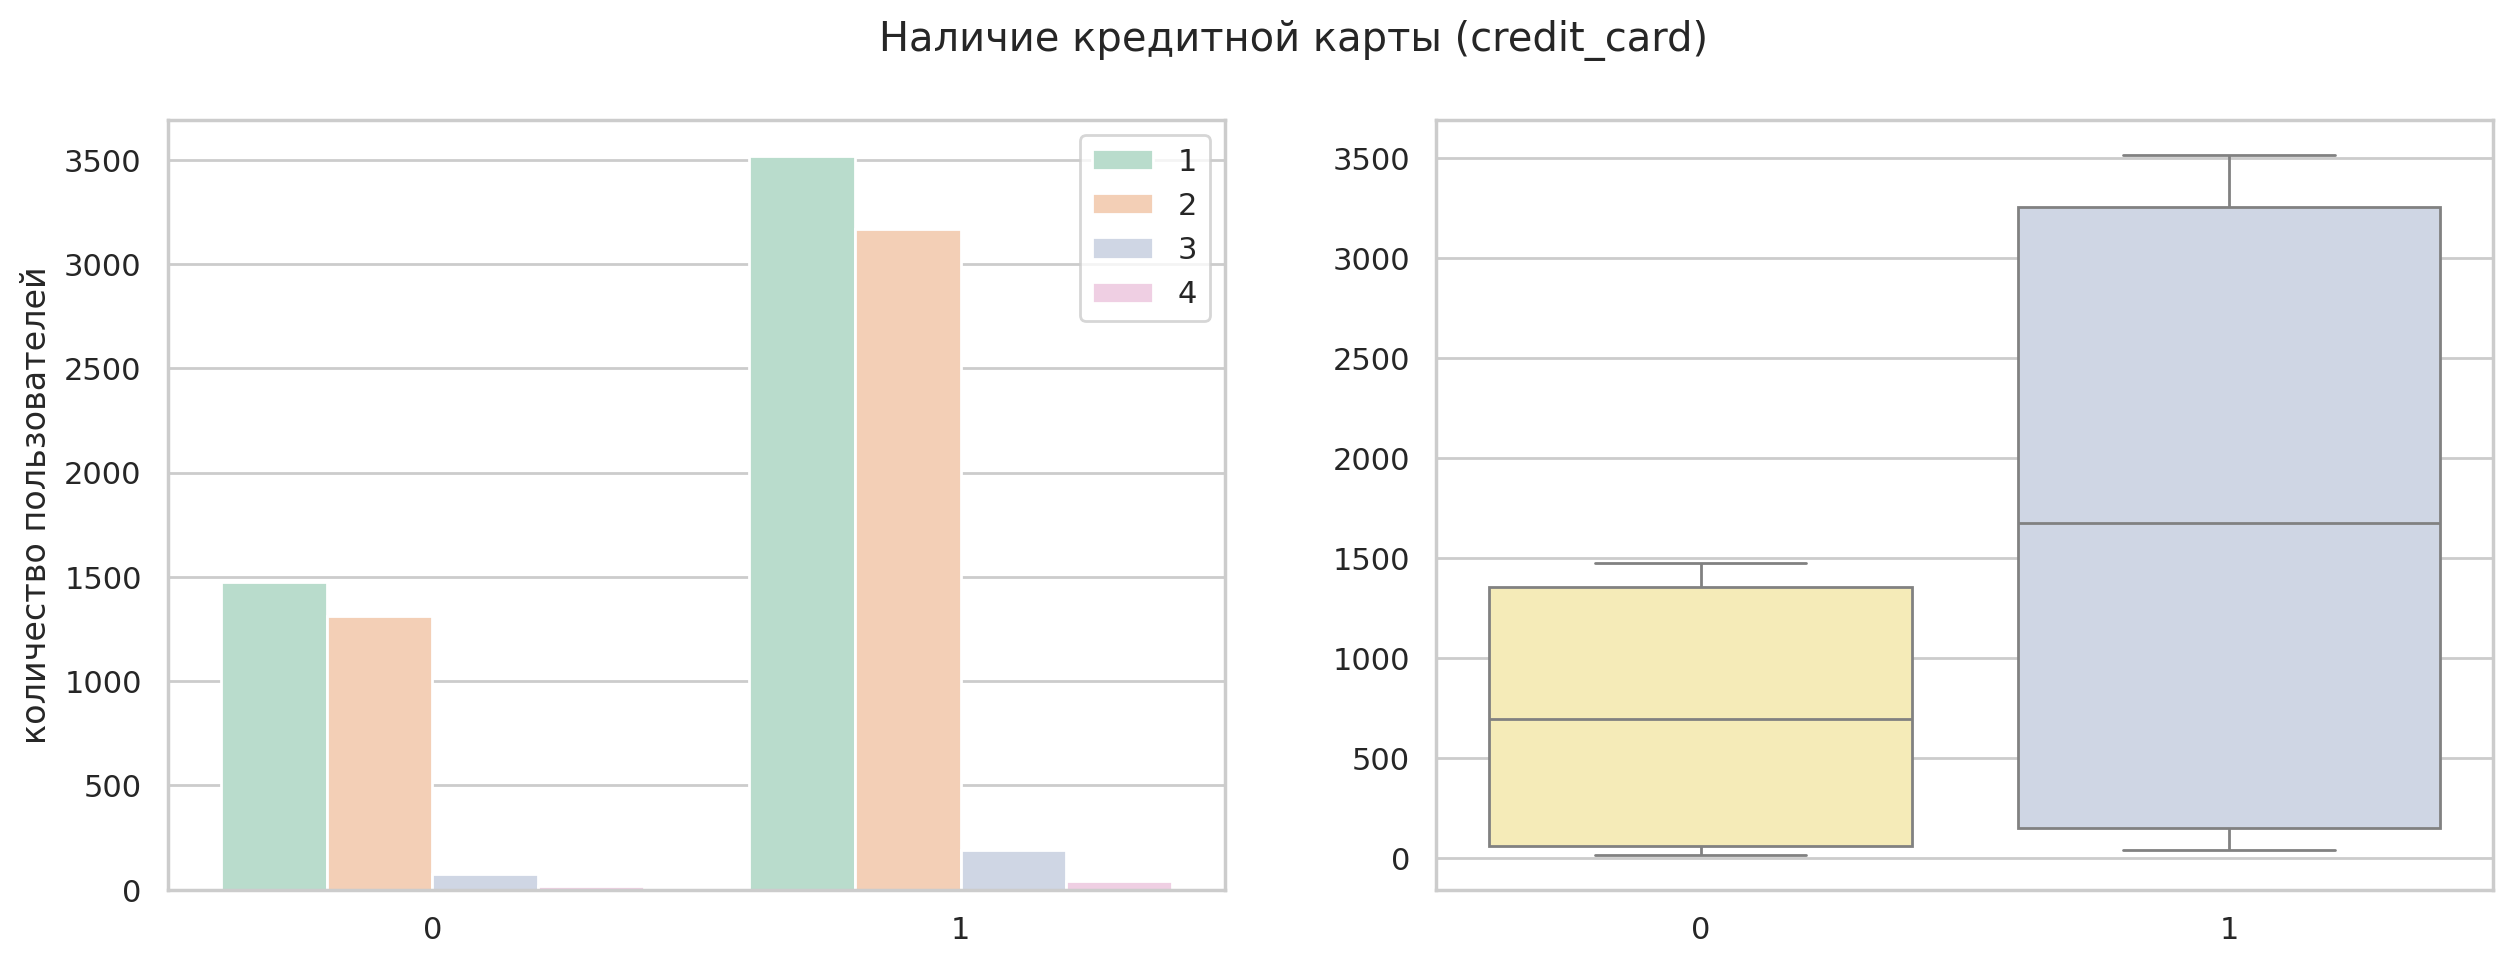

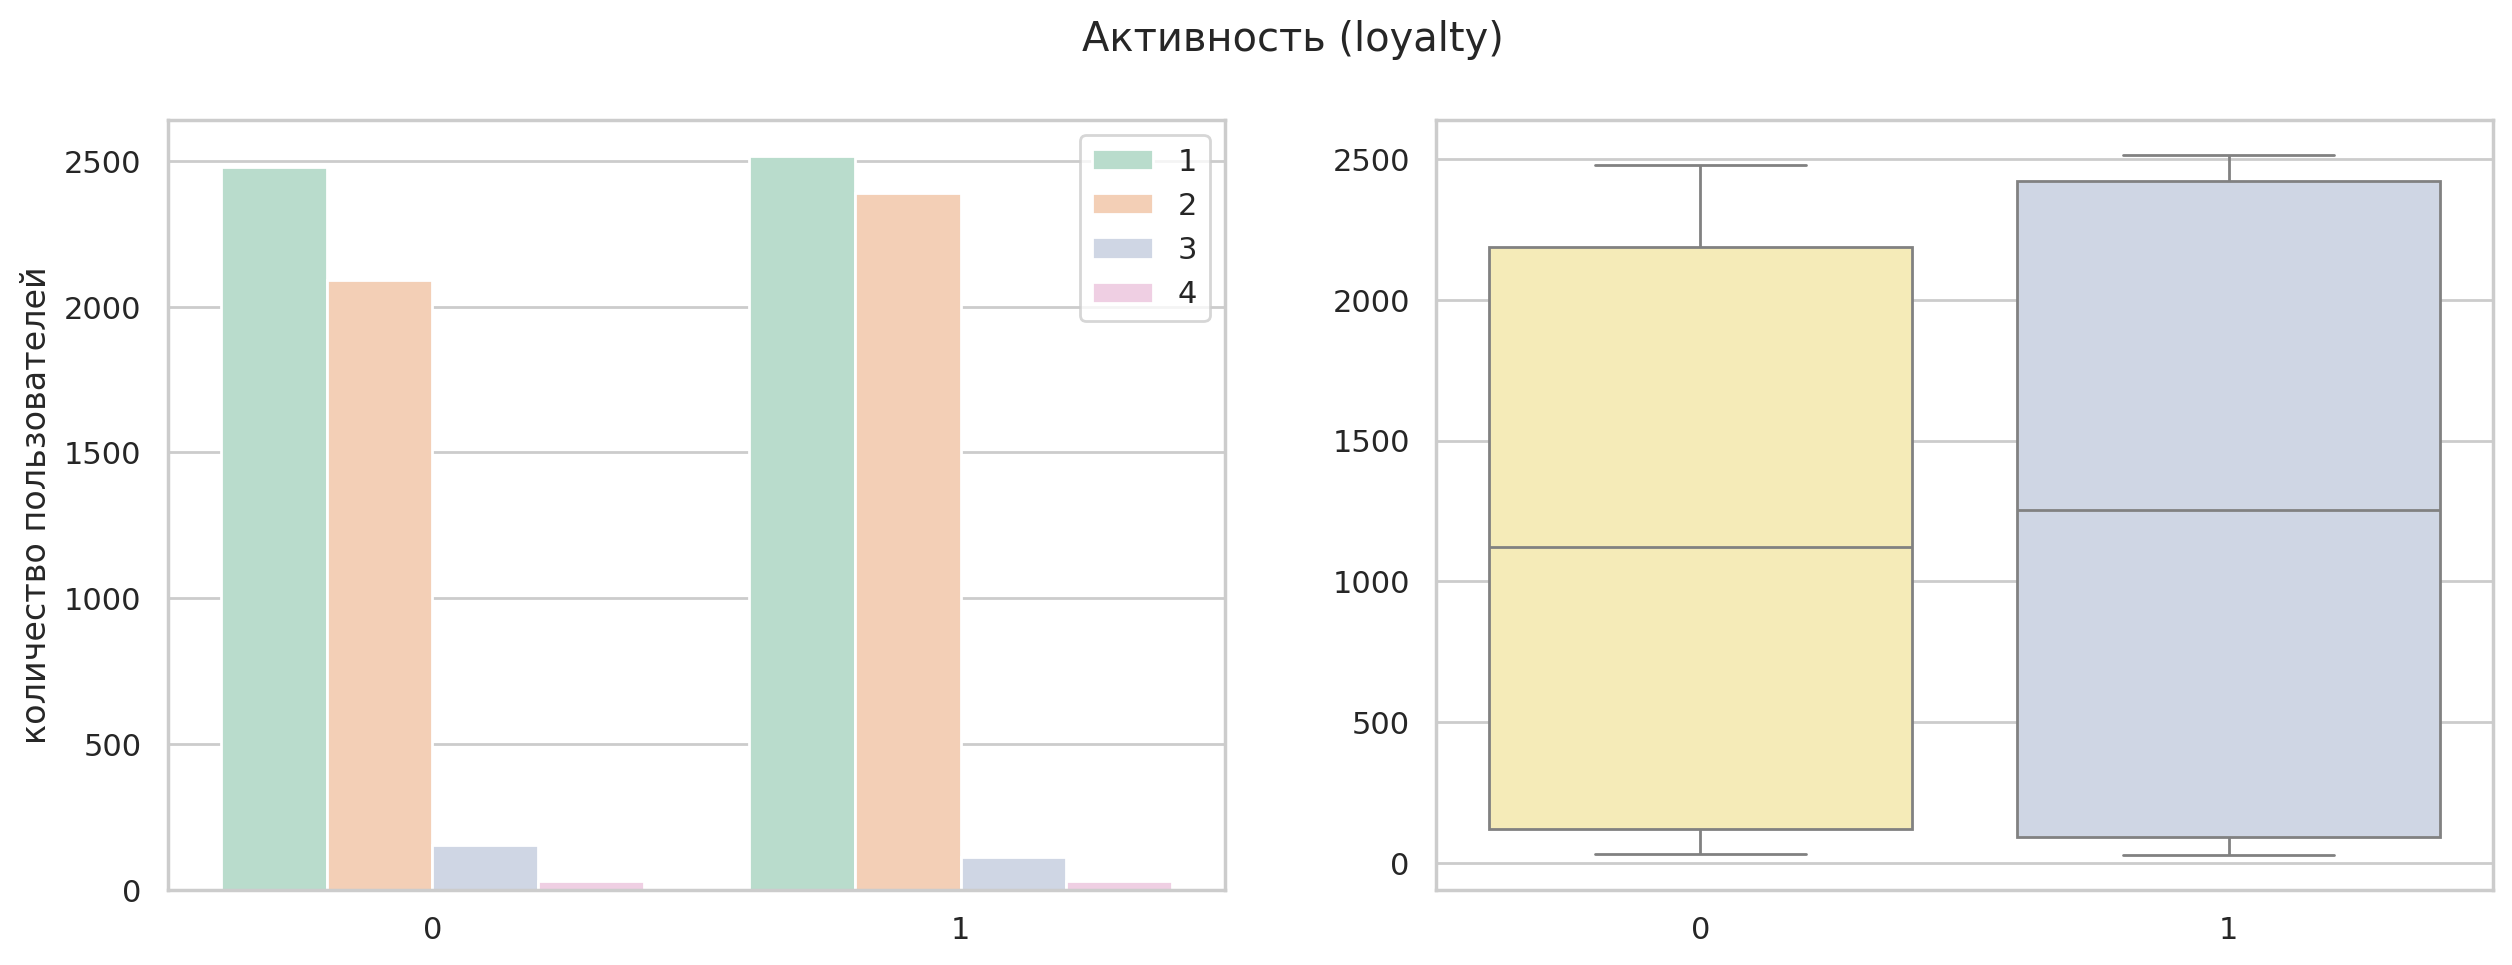

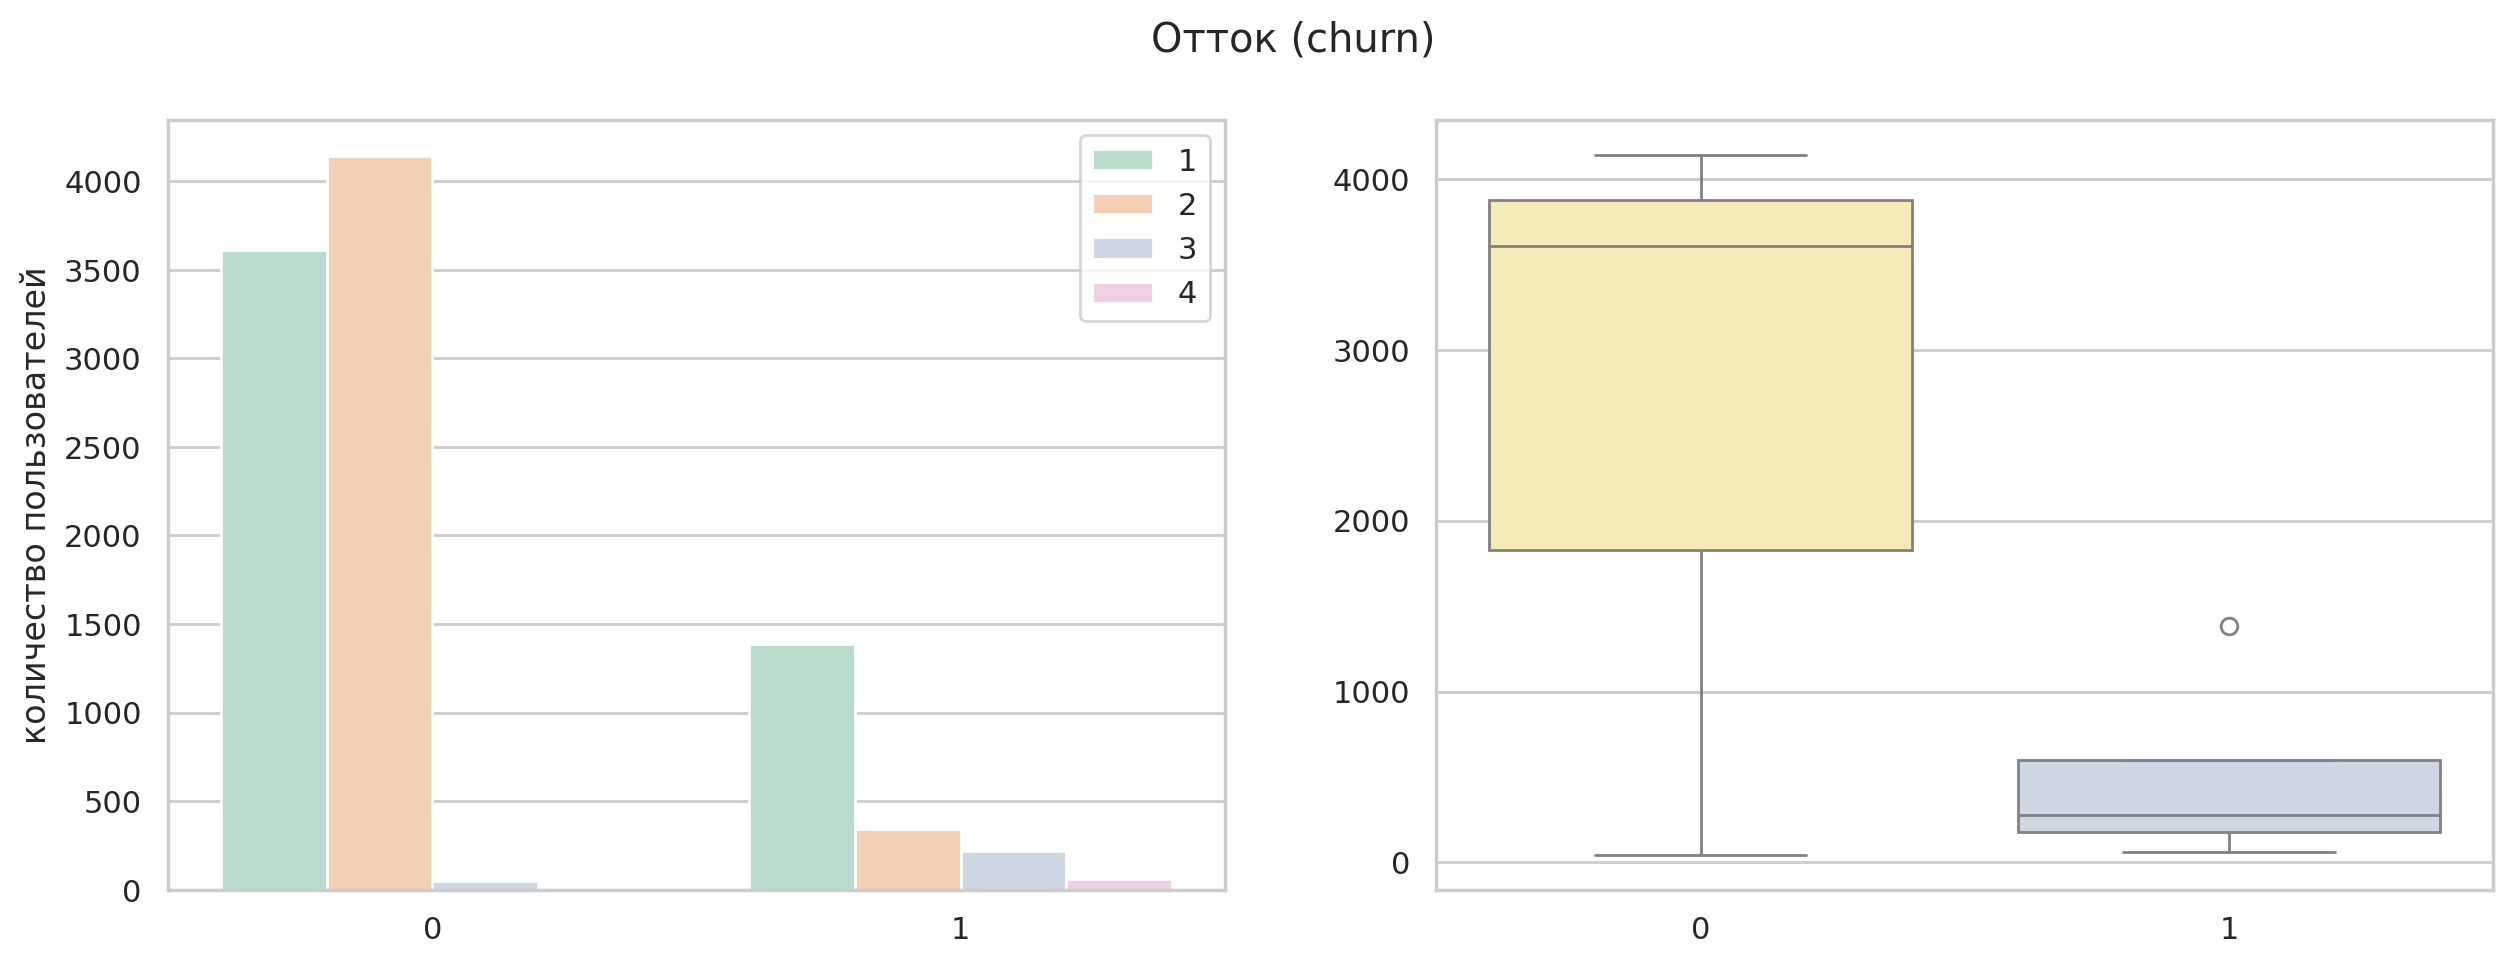

In [30]:
for index, row in categorical.iterrows():
    categorical_plots(data, row[0], row[1])

**Выводы**

Окончательно можно поделить клиентов банка на три группы:
- пользователи **одного продукта** (широкий возрастной диапазон, имеют чуть меньше баллов скорринга, чем владельцы двух продуктов, примущественно мужчины, чаще - жители Ярославля)
- пользователи **двух продуктов** (группа очень похожа на предыдущую, имеет наименьший отток и бОльший балл скорринга);
- пользователи **трех и более продуктов** (более страшего возраста, примущественно женщины, активность - низкая, сильный отток)



## Проверка гипотез

### Гипотеза №1

В ходе исследования нам необходимо проверить гипотезу различия дохода между теми клиентами, которые пользуются двумя продуктами банка, и теми, кто пользуются одним.


Проверим данные на нормальность.

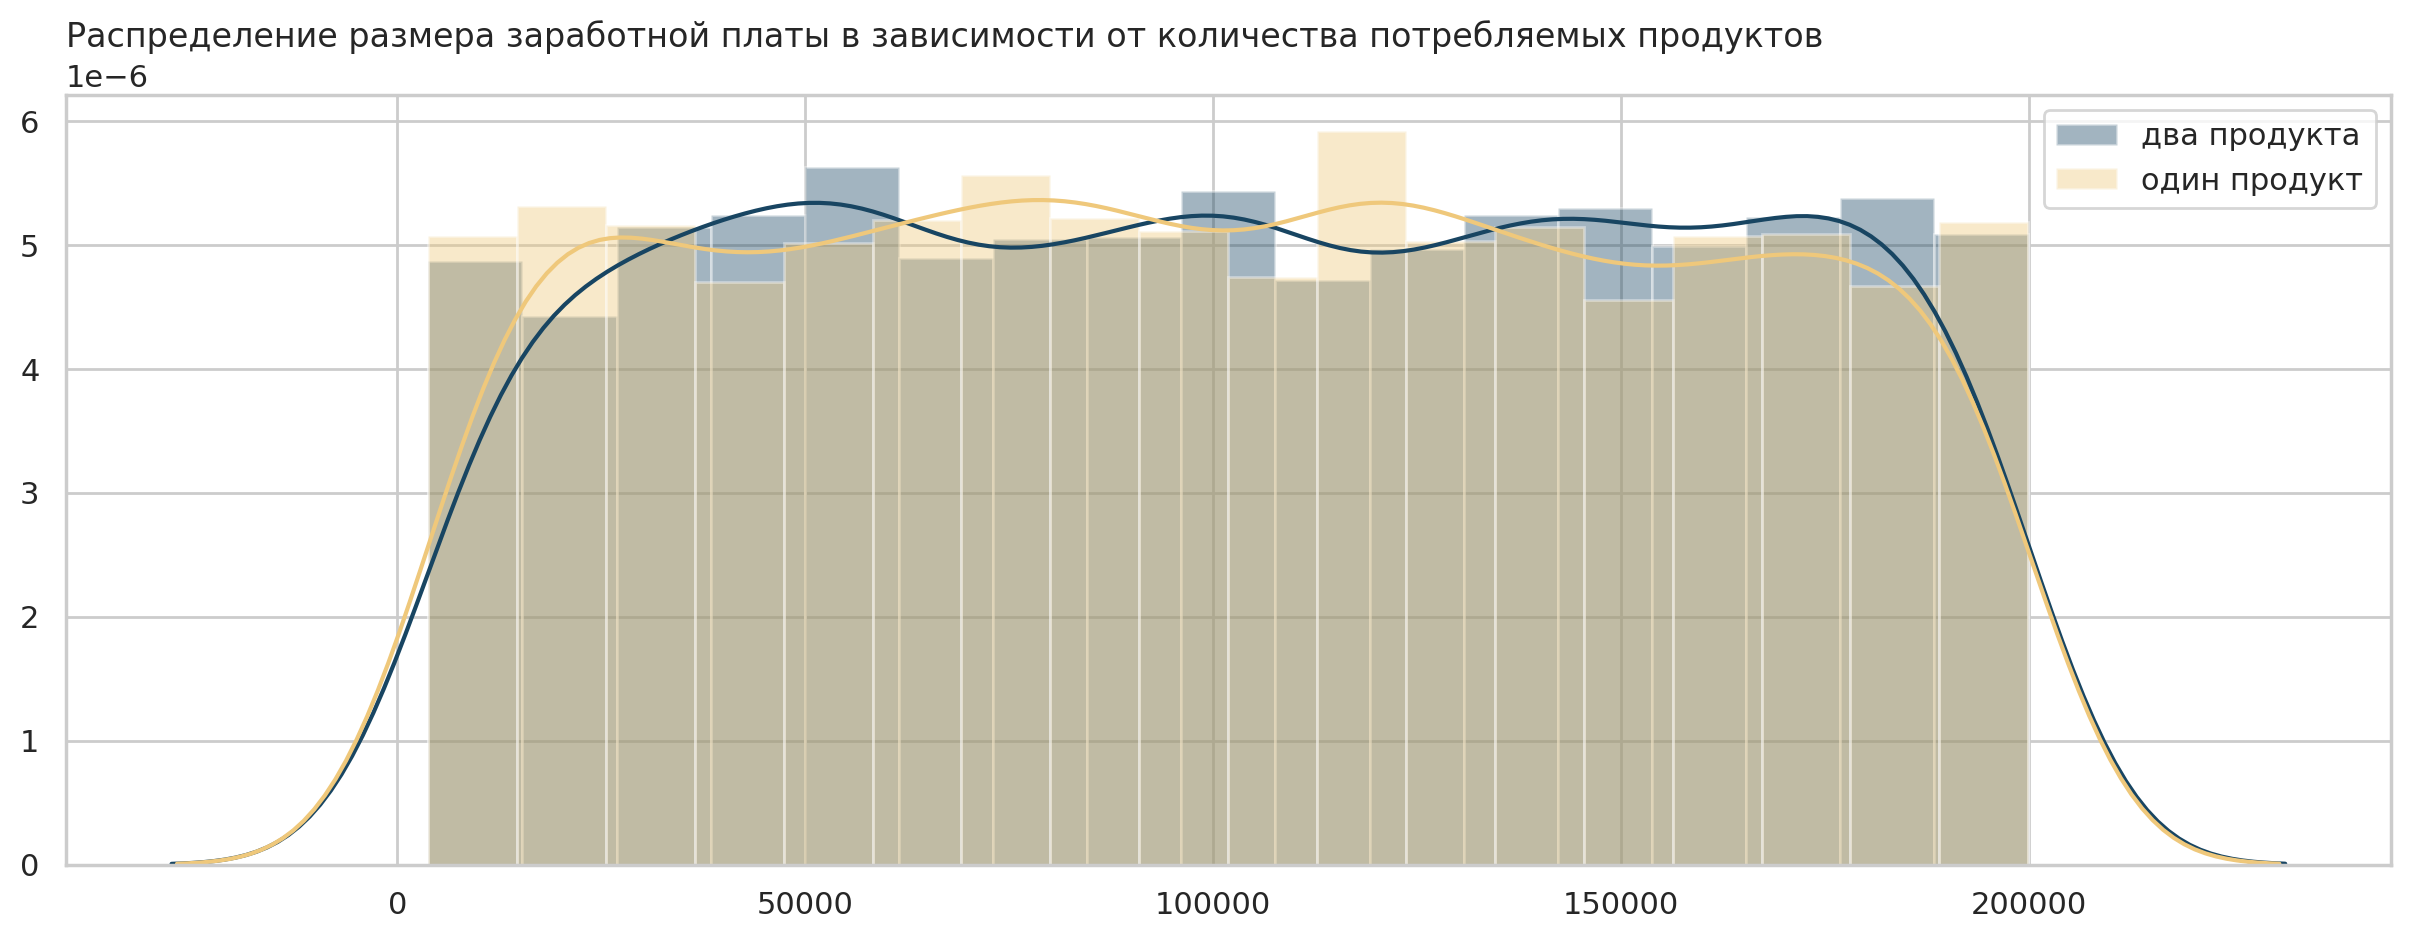

In [31]:
plt.figure(figsize=(15, 5))

sns.distplot(data[data['products'] == 2]['estimated_salary'], color = '#184562', label = 'два продукта')
sns.distplot(data[data['products'] < 2]['estimated_salary'], color = '#EFC87B', label = 'один продукт')

plt.title('Распределение размера заработной платы в зависимости от количества потребляемых продуктов', loc='left')
plt.xlabel('')
plt.ylabel('')
plt.legend()
plt.show()

Кажется, что данные распределены нормально.

<p>Введем основную и альтернативную  гипотезы:</p>

$\begin{equation*}
 \begin{cases}
   H_0 :\text{Доходы между клиентами, которые пользуются двумя продуктами банка, и теми, кто пользуются одним, одинаковы.}\\
   H_1 :\text{Доходы между клиентами, которые пользуются двумя продуктами банка, и теми, кто пользуются одним, отличаются.}
 \end{cases}
\end{equation*}$

Уровень значимости зададим обычный: $\alpha = 0.05$

Посчитаем p-value, используя `ttest` из библиотеки `scipy` для сравнения средних двух выборок.

Мы помним, что количество пользователей одного и двух продуктов сопоставимо.

Для подтверждения гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам иcпользуется метод `st.stats.ttest_ind`.

Если p-value будет меньше выбранного уровня значимости $\alpha = 0.05$, то нулевую гипотезу о равенстве средних отвергнем. В противном случае делаем вывод, что данные не позволили нам отвергнуть нулевую гипотезу.

In [32]:
alpha = .05   # критический уровень статистической значимости
results = st.stats.ttest_ind(data[data['products'] == 2]['estimated_salary'],
                             data[data['products'] < 2]['estimated_salary'])

print('p-значение: ', results.pvalue)    # тест двухсторонний

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.16769799693208315
Не получилось отвергнуть нулевую гипотезу


Мы не смогли опровергнуть гипотезу о различии дохода между теми клиентами, которые пользуются двумя продуктами банка, и теми, кто пользуются одним.

### Гипотеза №2

Вторая гипотеза, которую мы хотим проверить - различие в скоринговых баллах действующих и ушедших клиентов банка.   
Проверим данные на нормальность:

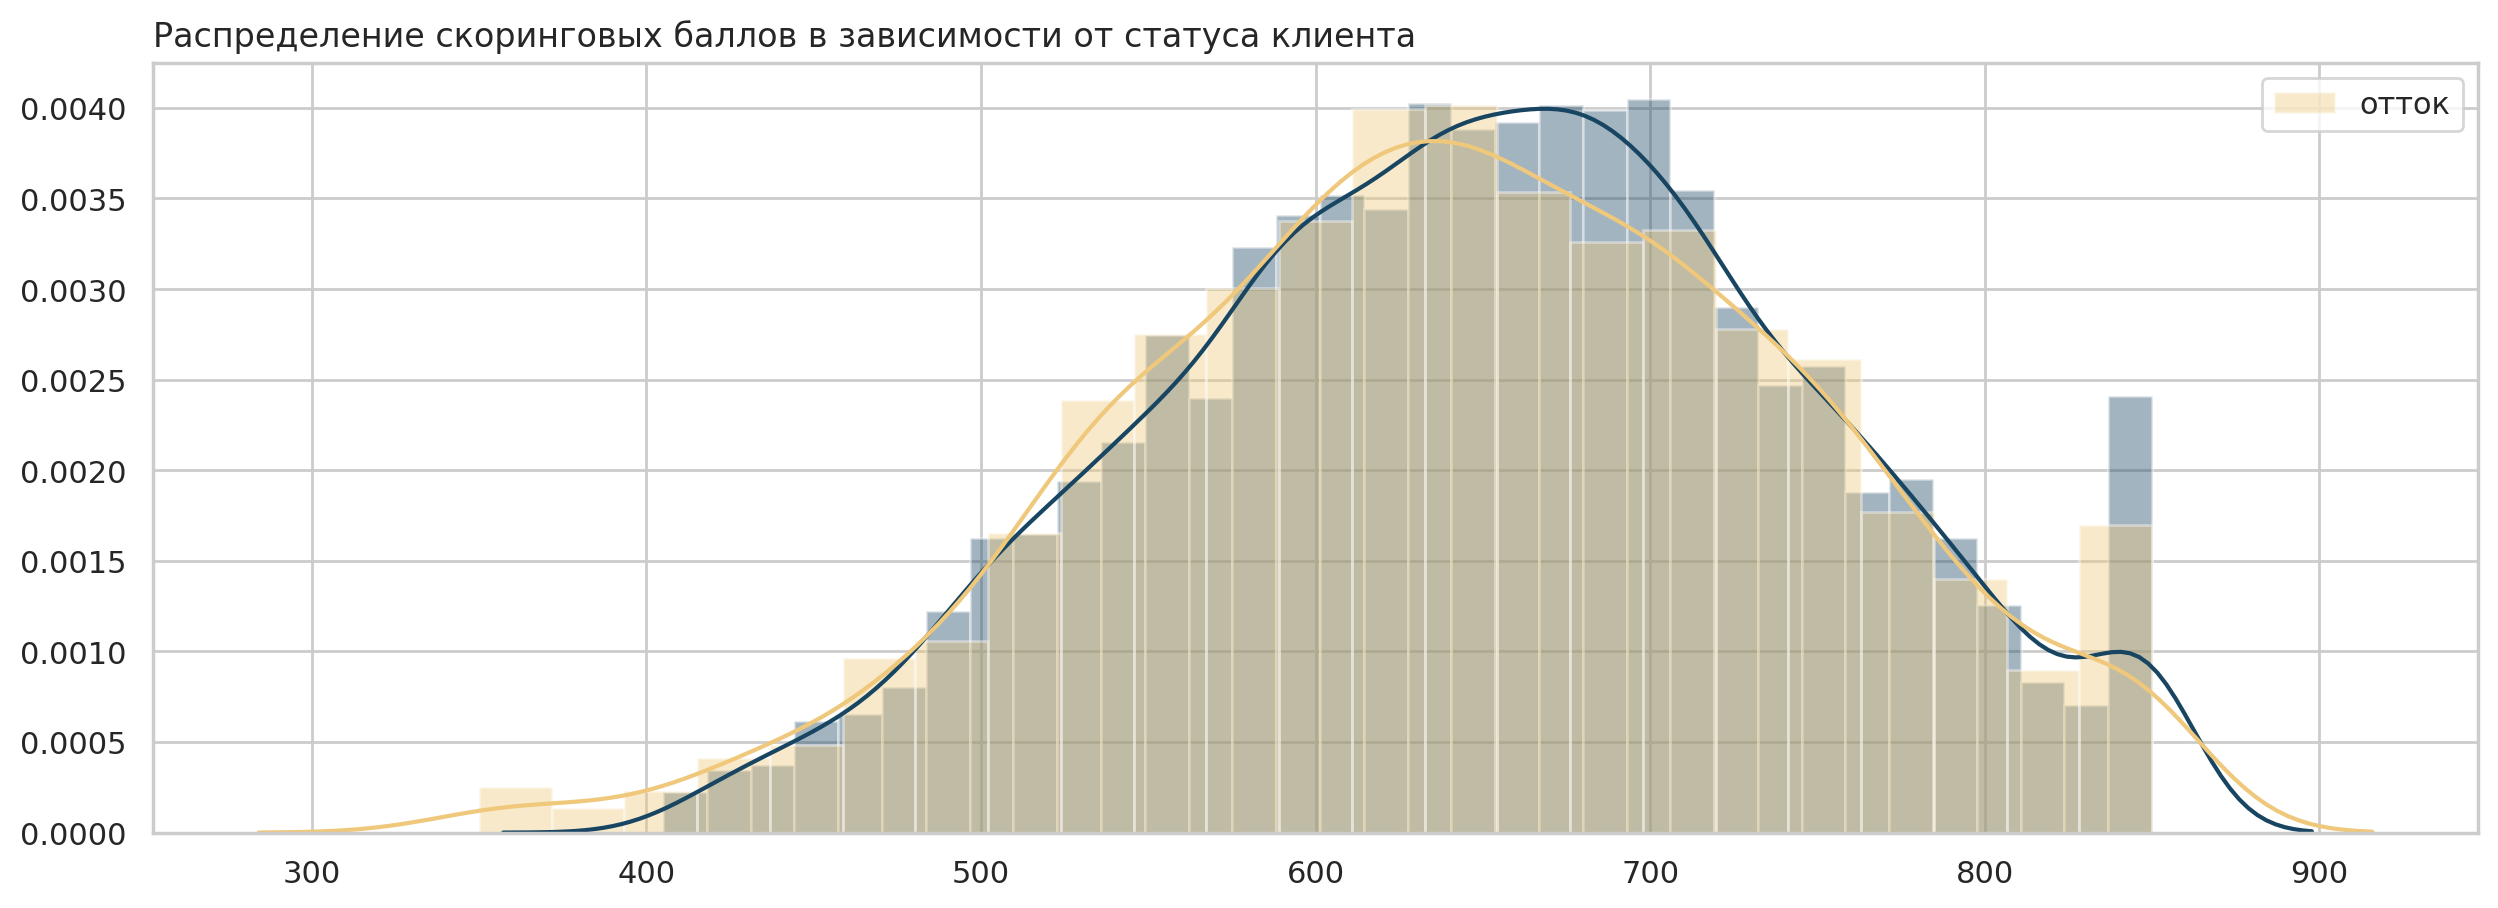

In [33]:
plt.figure(figsize=(15, 5))

sns.distplot(data[data['churn'] == 0]['score'], color = '#184562')
sns.distplot(data[data['churn'] == 1]['score'], color = '#EFC87B', label = 'отток')

plt.title('Распределение скоринговых баллов в зависимости от статуса клиента', loc='left')
plt.xlabel('')
plt.ylabel('')
plt.legend()
plt.show()

 Данные распределены нормально.

<p>Введем основную и альтернативную  гипотезы:</p>

$\begin{equation*}
 \begin{cases}
   H_0 :\text{Баллы скоринга у клиентов, которые попали в отток, и у действующих клиентов одинаковы.}\\   
   H_1 :\text{Баллы скоринга у клиентов, которые попали в отток, и у действующих клиентов отличаются.}
 \end{cases}
\end{equation*}$

Уровень значимости так же зададим обычный: $\alpha = 0.05$

Посчитаем p-value, используя `ttest` из библиотеки `scipy` для сравнения средних двух выборок.

Мы помним, что количество пользователей одного и двух продуктов сопоставимо.

Так же мы будем использовать параметр `equal_var=False`, т.к. есть сомнения по поводу нормального распределения дисперсий.

Если p-value будет меньше выбранного уровня значимости $\alpha = 0.05$, то нулевую гипотезу о равенстве средних отвергнем. В противном случае делаем вывод, что данные не позволили нам отвергнуть нулевую гипотезу.

In [34]:
alpha = .05   # критический уровень статистической значимости

results = st.stats.ttest_ind(data[data['churn'] == 0]['score'],
                             data[data['churn'] == 1]['score'],
                             equal_var=False)

print('p-значение: ', results.pvalue)    # тест двухсторонний

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.008543214579897854
Отвергаем нулевую гипотезу


Мы отвергаем гипотезу: различие в количестве  кредитных баллов скорингов имеет статистически значимую разницу.

## Кластеризация клиентов

Проведем класторизацию клиентов. Построим матрицу расстояний функцией `linkage()` на стандартизованной матрице признаков и нарисуем дендрограмму.

Мы предполагаем, что разделение (в разрезе количества потребляемых продуктов)  клиентов на кластеры будет довольно специфично, возможно - не верно. Но попробуем.

Так же, нам придется немного изменить датасет (перевести категориальные переменные в числовые, убрать пропуски, тем более, что на графиках мы не видели разницы в распределении в заполненных значениях).

Так, в столбце `gender` женский пол  заменен на 0, а мужской - на 1. Это работает для столбцов только с двумя категориями.   

Для столбца `city` с тремя категориями можно использовать значения 0, 1 и 2 для трех городов: Рыбинск, Ярославль и Ростов Великий. Однако, если мы сделаем это, алгоритмы машинного обучения будут предполагать, что между тремя городами существует порядковая связь. Другими словами, алгоритм будет предполагать, что 2 больше, чем 1 и 0, что на самом деле не так с точки зрения городов, которые представлены цифрами.

Лучшим способом преобразования таких категориальных столбцов в числовые является использование `one-hot encoding`. В этом процессе мы берем наши категории (три города) и представляем их столбцами. В каждом столбце мы используем 1, чтобы указать, что категория существует для текущей строки, и 0 в противном случае.

В данном же случае мы можем представить наши категориальные данные всего в двух столбцах (например, Рыбинск и Ярославль). Для Ростова Великого столбцы Рыбинск и Ярославль будут иметь значение 0.

In [35]:
# переводим категориальные данные в числовые
city = pd.get_dummies(data.city).iloc[:,1:]
gender = pd.get_dummies(data.gender).iloc[:,1:]

# объединяям новые столбцы с датасетом, удаляем старые столбцы city и gender  c категориальными значениями + balance
dataset = pd.concat([data, gender, city], axis=1)
dataset =  dataset.drop(['city', 'gender', 'balance'], axis=1)

dataset.head(5)

,user_id,score,age,objects,products,credit_card,loyalty,estimated_salary,churn,М,Рыбинск,Ярославль
0,15677338,619,42,2,1,1,1,"101,348.88",1,0,0,1
1,15690047,608,41,1,1,0,1,"112,542.58",0,0,1,0
2,15662040,502,42,8,3,1,0,"113,931.57",1,0,0,1
3,15744090,699,39,1,2,0,0,"93,826.63",0,0,0,1
4,15780624,850,43,2,1,1,1,"79,084.10",0,0,1,0


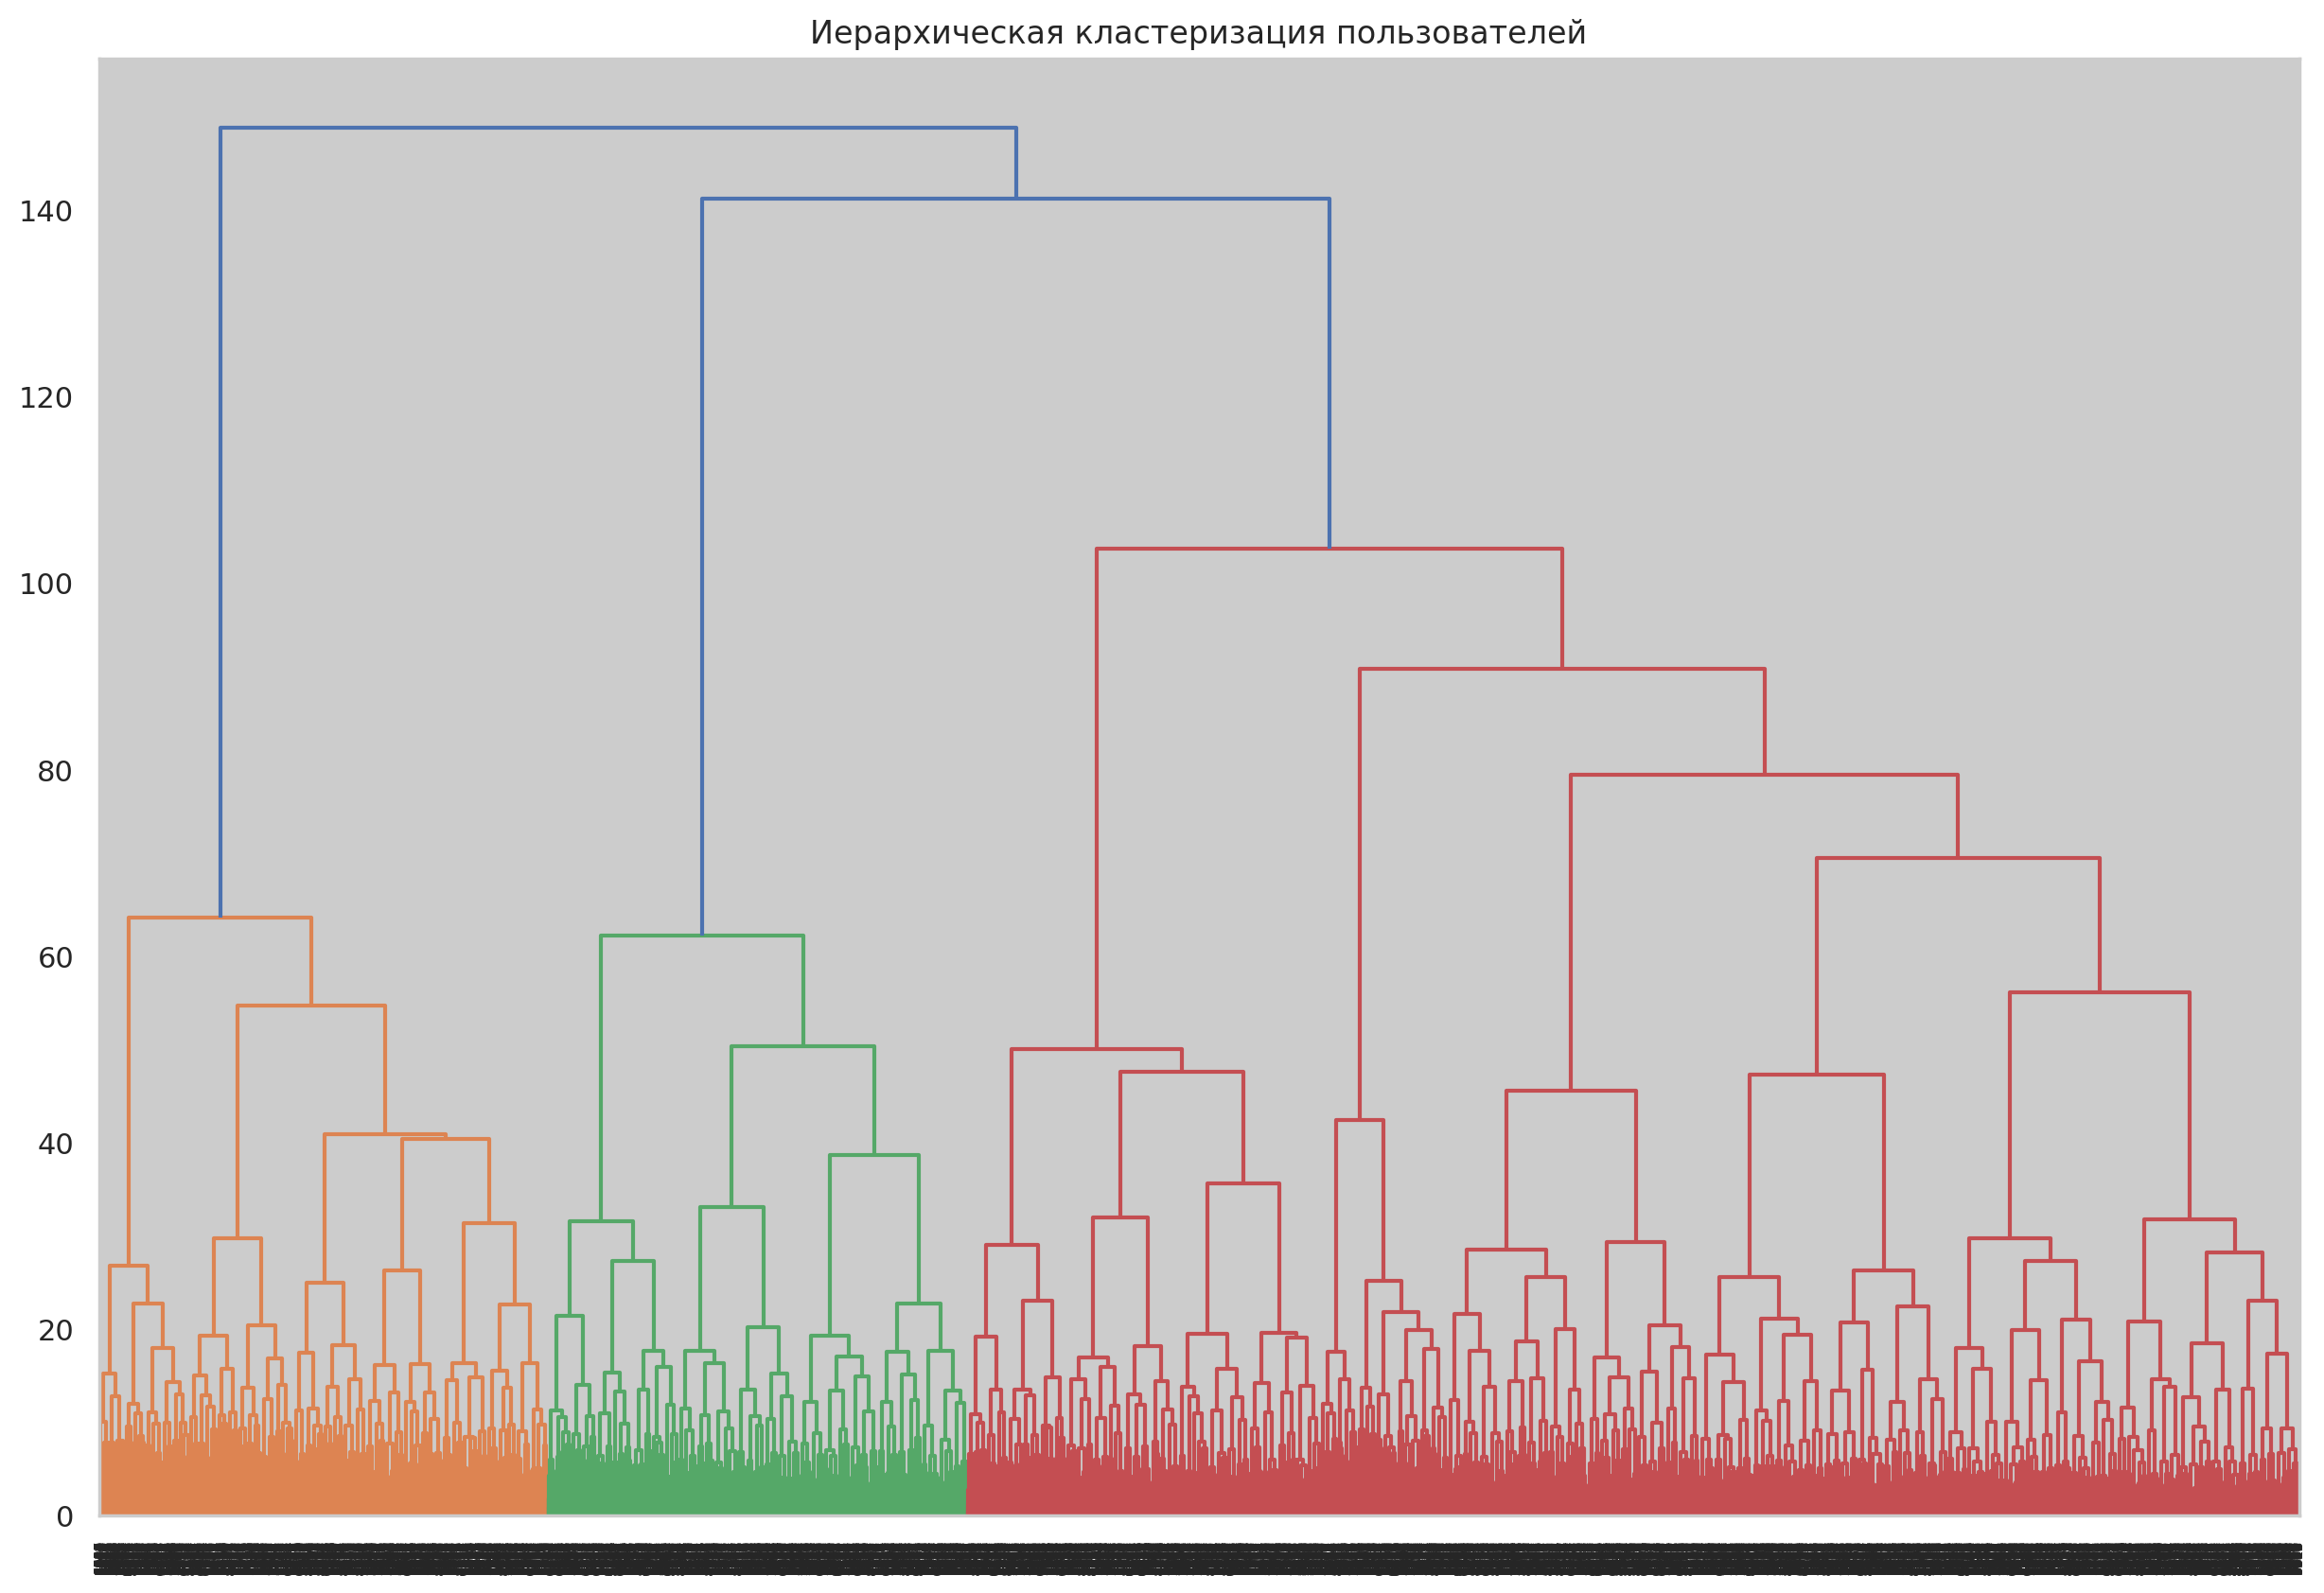

In [36]:
# выделим данные для кластеризации:
x = dataset.drop('products', axis = 1)

# обязательная стандартизация данных перед работой с алгоритмами
sc = StandardScaler()
x_sc = sc.fit_transform(x)

# строим таблицу расстояний между объектами:
linked = linkage(x_sc, method = 'ward')

# визуализируем (строим дендрограмму):
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация пользователей')
plt.show()

Задаем модель k_means с числом кластеров 3.

In [37]:
# задаём модель k_means с числом кластеров 3 и фиксируем значение random_state
km = KMeans(n_clusters=3, random_state=0)

# применяем алгоритм к данным и формируем вектор кластеров (алгоритм присваивает им номера от 0 до 4)
labels = km.fit_predict(x_sc)

# сохраняем метки кластера в поле нашего датасета
dataset['cluster_km'] = labels

# выводим статистику по средним значениям наших признаков по кластеру
display(dataset.groupby('cluster_km').mean().T)

# выведем размеры кластеров
print('Размеры кластеров:')
display(dataset.cluster_km.value_counts())

# посчитаем метрику силуэта для нашей кластеризации:
print('Silhouette_score (метрика силуэта): {:.2f}'.format(silhouette_score(x_sc, labels)))

cluster_km,0,1,2
user_id,"15,733,702.66","15,735,360.93","15,733,137.63"
score,651.57,651.87,645.50
age,37.24,37.72,45.14
objects,5.01,5.12,4.92
products,1.54,1.55,1.48
credit_card,0.71,0.70,0.70
loyalty,0.55,0.57,0.35
estimated_salary,"102,444.56","99,849.90","103,430.17"
churn,0.00,0.02,1.00
М,0.57,0.59,0.43


Размеры кластеров:


0    5762
1    2070
2    1968
Name: cluster_km, dtype: int64

Silhouette_score (метрика силуэта): 0.16


*Значение метрики силуэта оказалось не очень высоким. К сожалению, в наблюдениях редко можно встретить четкое разделение по признакам на группы, поэтому результат оценки желательно дополнительно обсудить с экспертами.*

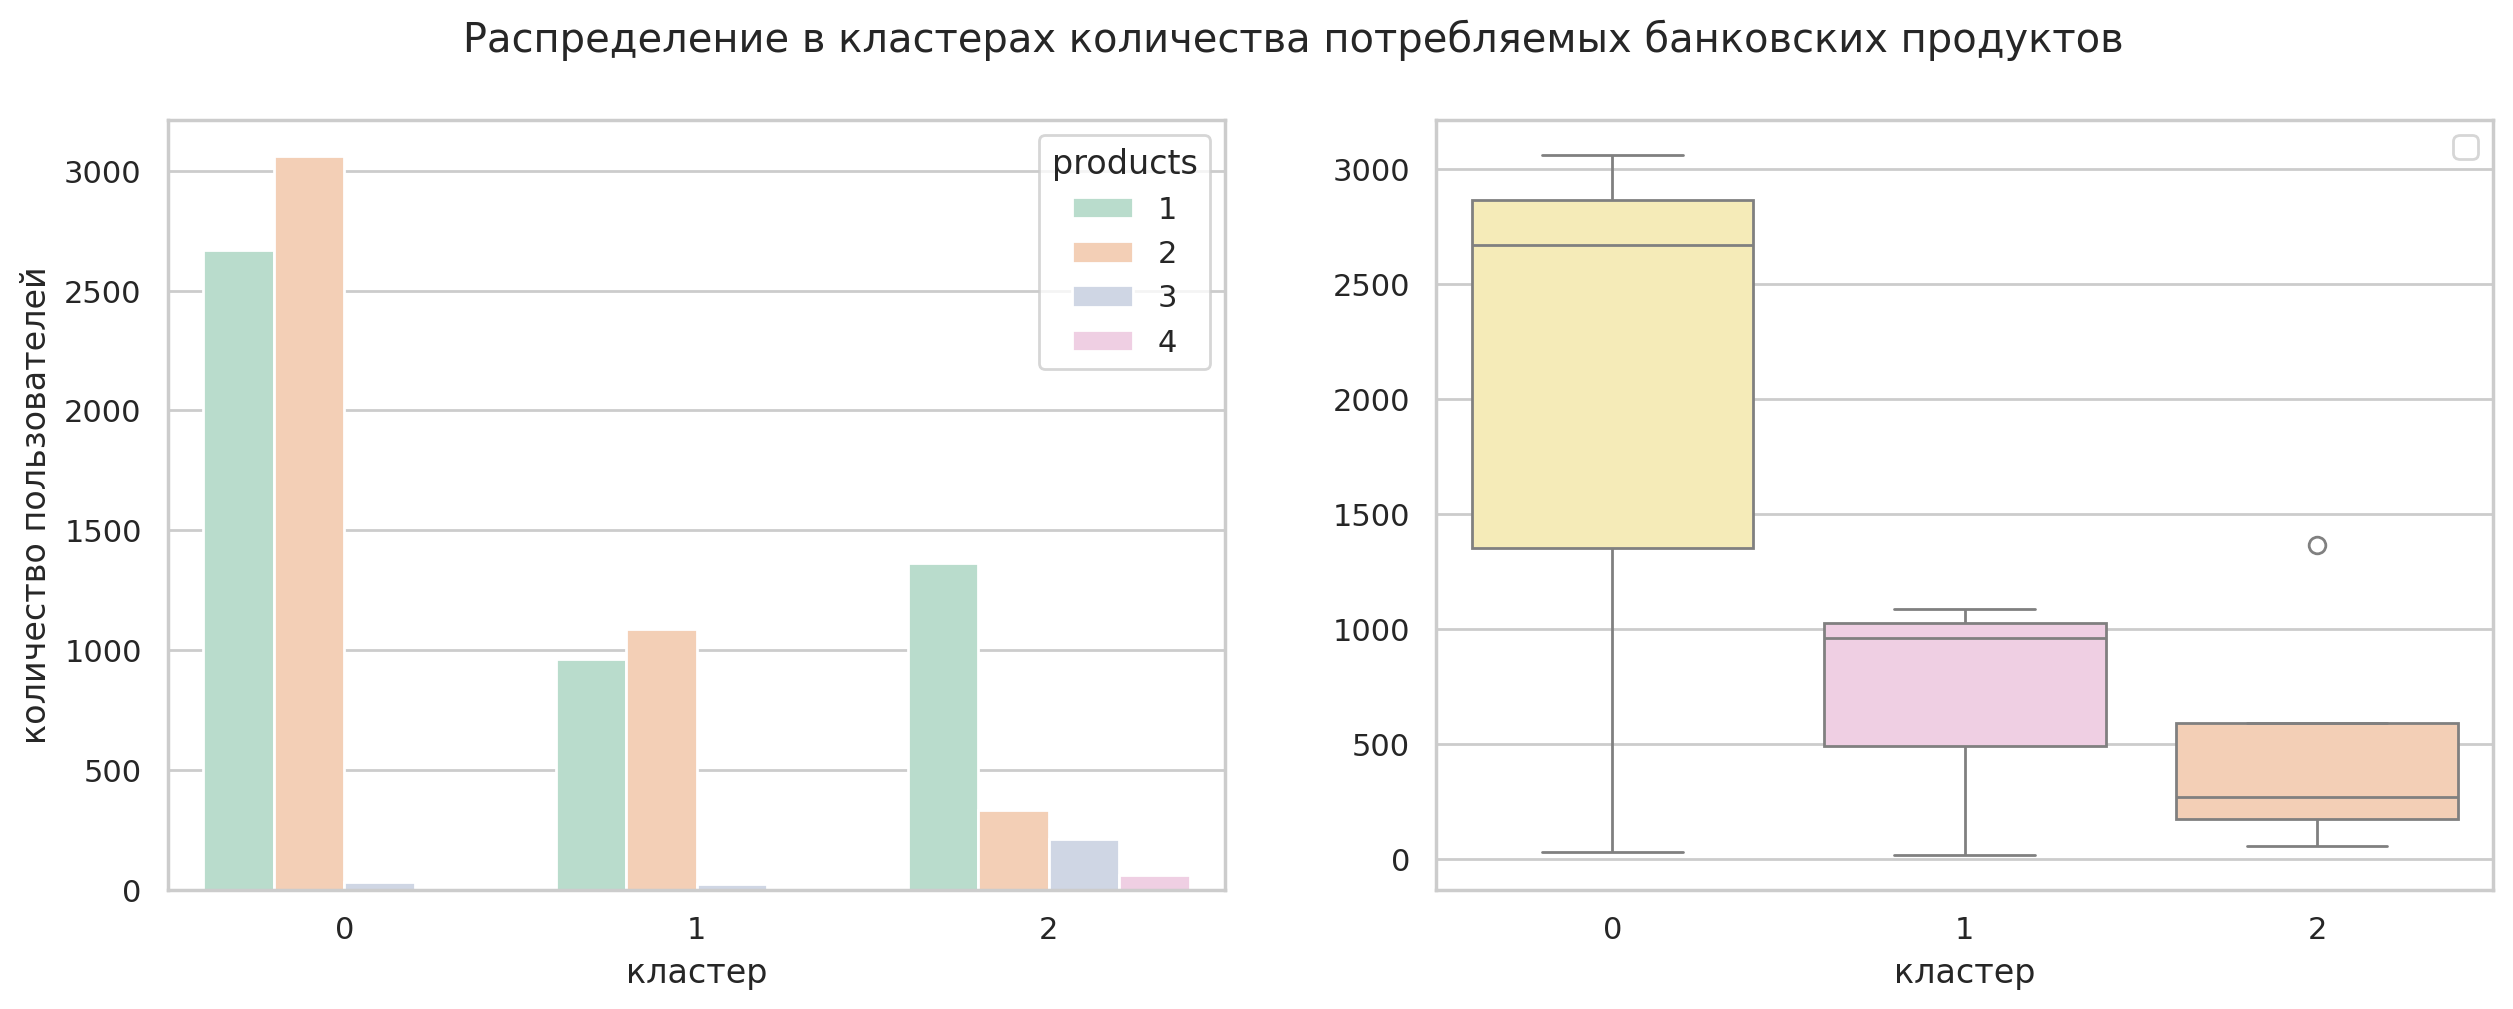

In [38]:
fig, ax = plt.subplots(figsize = (15, 5))

gr = dataset.groupby(['cluster_km', 'products']).agg(count=('user_id', 'count')).reset_index()
sns.boxplot(x = 'cluster_km', y = 'count', data = gr, ax = plt.subplot(1, 2, 2), palette='Pastel2_r')

plt.ylabel('')
plt.xlabel('кластер')
plt.legend()

sns.countplot(x = 'cluster_km', hue = 'products', data = dataset, ax = plt.subplot(1, 2, 1),  palette='Pastel2')

plt.xlabel('кластер')
plt.ylabel('количество пользователей')


fig.suptitle('Распределение в кластерах количества потребляемых банковских продуктов')
plt.show()


В общем и целом, мы подтвердили наше предположение.
Кластер 2  - полностью отточный. На его основе определяем портрет клиентов со 100% оттоком, а именно:
1. преобладание женщин (57%);
2. низкая активность (на уровне 35%);
3. большое количество пользователей с 3-4 продуктами, низкая доля пользователей 2х продуктов;
4. средний возраст - выше, чем у клиентов из остальных кластеров (45 лет).

## Выводы и рекомендации

Итак, в ходе исследования был проанализирован датасет клиентов банка "Метанпром", обслуживающихся в отделениях Ярославля, Ростове Великом и Рыбинске (клиентские данные обезличены).

Клиенты банка могут использовать от одного до четырех банковских продуктов. По набору полей (скоринг, ЗП, наличие недвижимости в собственности) можно предположить, что речь идет о кредитных продуктах банка (ипотека, потребительский кредит, автокредит, покупка товаров в рассрочку и т.д.).

___
В исследовании мы распределелили пользователей на три группы:
- пользователи **одного продукта** (широкий возрастной диапазон, имеют чуть меньше баллов скорринга, чем владельцы двух продуктов, примущественно мужчины, чаще - жители Ярославля)
- пользователи **двух продуктов** (группа очень похожа на предыдущую, имеет наименьший отток (8%) и бОльший балл скорринга);
- пользователи **трех и более продуктов** (более страшего возраста, примущественно женщины, активность - низкая, сильный отток). Пользователи 3 продуктов оттекают в 83% случаев, а пользователи 4 продуктов  - в 100% случаев.

___
Следующим этапом анализа была проверка двух гипотез:

-  гипотеза различия дохода между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним;
-  гипотеза различия в скоринговых баллах текущих и бывших клиентов банка.

В первом случае нулевая гипотеза о равенстве среднего дохода опровергнута не была.
Во втором случае мы опровергли нулевую гипотезу о равенстве среднего количества скоринговых баллов: у ушедших клиентов оно ниже.

___
Далее, мы провели класторизацию клиентов: построили матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисовали дендрограмму, после чего обучим модель кластеризации на основании алгоритма K-Means. В результате были получены 3 кластера, т.е. 3 портрета клиентов.

Наиболее интересным нам показался кластер №2 - **портрет клиента с 100% оттоком**:
* преимущественно женщина, средний возраст в районе 45 лет, с нулевым уровнем активности, пользуется 1 или 3-4 продуктами, локация - Ростов Великий;

___
На основании вышеизложенного предлагаем следующий **план действий**:

**1.** для клиентов, имеющих 3-4 продукта необходимо в срочном порядке проводить **консолидацию долга** с некоторым снижением процентной ставки (консолидация кредитов – это комплекс банковских мероприятий по объединению нескольких кредитов и займов в один). Эти меры помогут удержать клиентов, т.к. снизят нагрузку на плательщика. В противном случае клиенты уйдут в первую же кредитную организацию, которая сделает им такое предложение.   


**2.** для удержания клиентов старшего женского возраста предлагается провести **маркетинговые акции** с крупными сетевыми магазинами (преимущественно продуктовыми): программы кэшбэка, начисление пользовательских баллов, розыгрышами призов.    


**3.** так же, необходимо разработать и внедрить **новые продукты**:
- для пользователей-пенсионеров необходимо разработать продукт: карту платежной системы "Мир" с дополнительными преференциями (например, с программой кэшбэка или начислением баллов с возможностью зачета в счет основного долга; как вариант - введение дифференцированной ставки в зависимости от вида покупки). Это поможет как привлечению дополнительных денежных средств, так и одновременному снижению % оттока клиентов старшей возрастной группы;    

- для клиентов среднего возраста (пользователей одного кредитного продукта), которые хорошо зарекомендовали себя (нет просрочек) нужно предложить второй продукт по сниженной процентной ставке. Это поможет перевести клиента во вторую группу с самым низким % оттока.     


**4.** дополнительно необходимо провести **проверку** качества оказания услуг, включающий  в том числе анализ тарифов кредитных продуктов в городе Ростов Великий ввиду 50% оттока клиентов.   
